##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm as CM
import numpy as np
import pandas as pd
import random

####  <font color=SlateBlue>Google Colab</font>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


####  <font color=SlateBlue>Reading Images</font>

In [3]:
import os
from scipy.io import loadmat
from PIL import Image
import cv2

####  <font color=SlateBlue>Preprocessing</font>

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T

####  <font color=SlateBlue>CNN</font> ####

In [5]:
import torch.nn as nn
import torch.nn.functional as f
from torch.autograd import Variable

##  <font color=MediumSlateBlue>Classes and Functions</font> ##

####  <font color=SlateBlue>Loading Images and Transforming them</font> ####

In [ ]:
def GuassianKernel(size, sigma):
  return np.array([(1.0/(2.0*np.pi*sigma**2))*np.exp(-((x-int((size-1)/2))**2+(y-int((size-1)/2))**2)/(2.0*sigma**2)) for x in range(size) for y in range(size)]).reshape(size, size)

In [ ]:
class Transformer():
  def __init__(self, transformInfo):
    self.transformInfo = transformInfo

  def FindDensityMapWithFixedKernel(self, imgSize, points):
    '''
    Inputs:
    -imgSize: Input image's size in form of (row, clm).
    -points: People's position based on ground-truth in [x,y] format.

    Return:
    -dMap: Density-map of the inout image.
    '''
    kernelSize = transformInfo['Kernel Size'] if 'Kernel Size' in transformInfo else 11 #kernelSize: The fixed size of Gaussian kernel. (must be odd number.)
    sigma = transformInfo['Sigma'] if 'Sigma' in transformInfo else 3 #sigma: Variance of gaussian kernel.

    rows, clms = imgSize[0], imgSize[1] 

    guassianKernel = GuassianKernel(kernelSize, sigma)
    guassianKernel = (1.0/guassianKernel.sum())*guassianKernel
      
    dMap=np.zeros([rows, clms])

    if len(points)==0: return dMap
    else:
      for point in points:
        row, clm = int(point[1]), int(point[0])
        if (row>=rows) or (clm>=clms): continue

        for x in range(kernelSize):
          for y in range(kernelSize):
            if (x+(row+1)-int((kernelSize-1)/2)<0) or (x+(row+1)-int((kernelSize-1)/2)>rows-1) or (y+(clm+1)-int((kernelSize-1)/2)<0) or (y+(clm+1)-int((kernelSize-1)/2)>clms-1): continue
            else: dMap[x+(row+1)-int((kernelSize-1)/2),y+(clm+1)-int((kernelSize-1)/2)] += guassianKernel[x,y]
    return dMap 

  def RGB2Gray(self, img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

  def patchInput(self, img):
    patchImg = img 

    patchSize = self.transformInfo['Patch Size']
    patchStep = self.transformInfo['Patch Step']

    return img.unfold(0, patchSize, patchStep)

In [ ]:
class LoadTransformSave():
  def __init__(self, imgLoc, labelLoc):
    self.imgsPaths, self.labelsPaths = self.loadPathsFromFolder(imgLoc, labelLoc)
    self.numOfData = len(self.imgsPaths)

  def loadPathsFromFolder(self, imgLoc, labelLoc):
    '''
    Inputs:
    -imgLoc: Location of the folder containing images. 
    -labelLoc: Location of the folder containing labels (.mat files with the 
                pedesterians' axis points)

    Return:
    -imgsPaths, labelsPaths: A tuple containing two lists of the images 
                             and labels' path. 
    '''
    imgsPaths, labelsPaths = [], []

    for fileName in os.listdir(imgLoc):
      imgsPaths.append(os.path.join(imgLoc, fileName))
      labelsPaths.append(os.path.join(labelLoc, fileName.replace('.jpg','.mat').replace('IMG_','GT_IMG_')))

    return imgsPaths, labelsPaths

  def transformInput(self, index, transformInfo):
    myTransformer = Transformer(transformInfo)

    img = plt.imread(self.imgsPaths[index])
    points = loadmat(self.labelsPaths[index])["image_info"][0,0][0,0][0]
    
    pointsDensityMap = myTransformer.FindDensityMapWithFixedKernel((img.shape[0], img.shape[1]), points)

    imgGrayScale = myTransformer.RGB2Gray(img)

    patchedDesityMap = myTransformer.patchInput(torch.tensor(pointsDensityMap))
    patchedImg = myTransformer.patchInput(torch.tensor(imgGrayScale))

    return patchedImg.permute(0, 2, 1).contiguous(), patchedDesityMap.permute(0, 2, 1).contiguous()

  def saveTransInputs(self, transformInfo, saveLoc):
    for i in range(self.numOfData):
      transImg, transLabel = self.transformInput(i, transformInfo)

      for k in range(3):
        for j in range(0,1024,256):
          np.save(saveLoc+'/Image'+str(i)+'_'+str(4*k+j//256), transImg[k,:, j:j+255])
          np.save(saveLoc+'/DMap'+str(i)+'_'+str(4*k+j//256), transLabel[k,:, j:j+255])
      





In [6]:
class DatasetLoader(Dataset):
  def __init__(self, loc, size):
    self.dataSize = size
    self.imgsPaths, self.labelsPaths = self.getNamesFromLoc(loc)

  def getNamesFromLoc(self, loc):
    img, label = [], []

    for i in range(self.dataSize):
      for j in range(12):
        img.append(loc+'/Image'+str(i)+'_'+str(j)+ '.npy')
        label.append(loc+'/DMap'+str(i)+'_'+str(j)+ '.npy')

    return img, label

  def __len__(self): return len(self.imgsPaths)

  def __getitem__(self, index):
    trans = T.Compose([T.ToTensor()])
    img =  np.load(self.imgsPaths[index])
    
    label = np.load(self.labelsPaths[index])
    label = cv2.resize(label,(63,64)) * 16

    return trans(img), torch.from_numpy(label)


In [7]:
class CCNN(nn.Module):
  def __init__(self):
    super(CCNN, self).__init__()
    
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, 
                           kernel_size=11, stride=1, padding=5)
    
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, 
                           kernel_size=7, stride=1, padding=3)
    
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, 
                           kernel_size=5, stride=1, padding=2)
    
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=1000, 
                           kernel_size=1, stride=1, padding=0)
    
    self.conv5 = nn.Conv2d(in_channels=1000, out_channels=400, 
                           kernel_size=1, stride=1, padding=0)
    
    self.conv6 = nn.Conv2d(in_channels=400, out_channels=1, 
                           kernel_size=1, stride=1, padding=0)
    
    self.maxPool1=nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=False)
    self.maxPool2=nn.MaxPool2d(kernel_size=2, stride=2, padding=0, return_indices=False)
    
  def forward(self, input):

    out1 = f.relu(self.conv1(input))
    out2 = f.relu(self.maxPool1(self.conv2(out1)))
    out3 = f.relu(self.maxPool2(self.conv3(out2)))
    out4 = f.relu(self.conv4(out3))
    out5 = f.relu(self.conv5(out4))
    return self.conv6(out5)

In [8]:
def train(net, criterion1, criterion2, optimizer, batchTrainDataset, batchTestDataset, numEpochs):
  trainLossEpoch1, trainLossEpoch2 = [], []

  for numEpoch in range(numEpochs):
    print('Epoch %d has started......' %(numEpoch+1))

    trainDataLoss1, trainDataLoss2 = 0, 0 
    trainPrintFlag = 0

    trainLossIter1, trainLossIter2 = [], []

    print('Training the network......')
    net = net.train()

    for data, labels in batchTrainDataset:
      trainPrintFlag += 1
      
      if torch.cuda.is_available():
         data = Variable(data).cuda()
         labels = Variable(labels).cuda()
      else:
        data = Variable(data)
        labels = Variable(labels)

      allTrainPredLabels = net(data.float())
      allTrainPredLabels = allTrainPredLabels[0]

      loss1 = criterion1(allTrainPredLabels.float(), labels.float())  
      loss2 = criterion2(allTrainPredLabels.float(), labels.float())  

      optimizer.zero_grad()
      loss1.backward()
      optimizer.step()

      trainDataLoss1 += loss1.item()
      trainDataLoss2 += loss2.item()

      trainLossIter1.append(trainDataLoss1/trainPrintFlag)
      trainLossIter2.append(trainDataLoss2/trainPrintFlag)

      if trainPrintFlag % 100 == 0:
        print('Train Results:') 
        print('Iteration:%d \t Loss MSE:%1.5f' %(trainPrintFlag, trainDataLoss1/trainPrintFlag))
        print('Iteration:%d \t Loss MAE:%1.5f' %(trainPrintFlag, trainDataLoss2/trainPrintFlag))

        fig, axes = plt.subplots(1,2)
        fig.suptitle('Prediction and True Density Map in Iteration '+ str(trainPrintFlag)) 
        axes[0].imshow(allTrainPredLabels[0,:,:].data.cpu().numpy(), cmap=plt.get_cmap('gray'), interpolation='nearest', aspect='auto')
        axes[0].set_title('Predicted Label')
        axes[0].set_xticks(())
        axes[0].set_yticks(())
        axes[1].imshow(labels[0,:,:].data.cpu().numpy(), cmap=CM.Greys, interpolation='nearest', aspect='auto')
        axes[1].set_title('True Label')
        axes[1].set_xticks(())
        axes[1].set_yticks(())
        plt.show()

        plt.plot(trainLossIter1, label='MSE Loss', color='slateblue')
        plt.plot(trainLossIter2, label='MAE Loss', color='mediumpurple')
        plt.title('Loss vs. Iterations')
        plt.xlabel('Number of Iterations Untill Now')
        plt.ylabel('Loss')
        plt.legend(loc='best')
        plt.show()

        print('\n')
        print('Testing the network......')

        net.eval()

        i = 0
        testDataLoss1, testDataLoss2 = 0, 0 

        with torch.no_grad():
          for testData, testLabels in batchTestDataset:

            if i == 100:
              print('Test Results:')
              print('After 100 data, MSE loss is:%1.5f' %(testDataLoss1/i))
              print('After 100 data, MAE loss is:%1.5f' %(testDataLoss2/i))
              print('\n')
              break

            if torch.cuda.is_available():
              testData = Variable(testData).cuda()
              testLabels = Variable(testLabels).cuda()
            else:
              testData = Variable(testData)
              testLabels = Variable(testLabels)

            allTestPredLabels = net(testData.float())
            allTestPredLabels = allTestPredLabels[0]

            loss1 = criterion1(allTestPredLabels.float(), testLabels.float())
            loss2 = criterion2(allTestPredLabels.float(), testLabels.float())

            testDataLoss1 += loss1.item()
            testDataLoss2 += loss2.item()

            i += 1

    print('At the end of epoch %d the average train loss of MSE is: %1.5f' %(numEpoch+1, trainDataLoss1/len(batchTrainDataset)))
    trainLossEpoch1.append(trainDataLoss1/len(batchTrainDataset))

    print('At the end of epoch %d the average train loss of MAE is: %1.5f' %(numEpoch+1, trainDataLoss2/len(batchTrainDataset)))
    trainLossEpoch2.append(trainDataLoss2/len(batchTrainDataset))


  plt.plot(trainLossEpoch1, label='MSE Loss', color='slateblue')
  plt.plot(trainLossEpoch2, label='MAE Loss', color='mediumpurple')
  plt.title('Loss vs. Epochs')
  plt.xlabel('Number of Epochs Untill Now')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show()

##  <font color=MediumSlateBlue>Loading Data and Storing</font> ##

####  <font color=SlateBlue>Reading Images and Labels</font> ####

In [ ]:
trainImgsLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/part_B/train_data/images' #Direction of train images
trainGTLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/part_B/train_data/ground-truth' #Direction of ground-truth images

In [ ]:
myLoadTransformSave = LoadTransformSave(trainImgsLoc, trainGTLoc)

####  <font color=SlateBlue>Saving Images and Labels' patches</font> ####

In [ ]:
saveLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/TrainDataset'
transformInfo = {'Kernel Size':11, 'Sigma':3, 'Patch Size':256, 'Patch Step':256}
myLoadTransformSave.saveTransInputs(transformInfo, saveLoc)

####  <font color=SlateBlue>Reading Images and Labels</font> ####

In [ ]:
testImgsLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/part_B/test_data/images' #Direction of train images
testGTLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/part_B/test_data/ground-truth' #Direction of ground-truth images

In [ ]:
myLoadTransformSave = LoadTransformSave(testImgsLoc, testGTLoc)

####  <font color=SlateBlue>Saving Images and Labels' patches</font> ####

In [ ]:
saveLoc = '/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/TestDataset'
transformInfo = {'Kernel Size':11, 'Sigma':3, 'Patch Size':256, 'Patch Step':256}
myLoadTransformSave.saveTransInputs(transformInfo, saveLoc)

####  <font color=SlateBlue>Plotting Images and Labels' Patches</font> ####

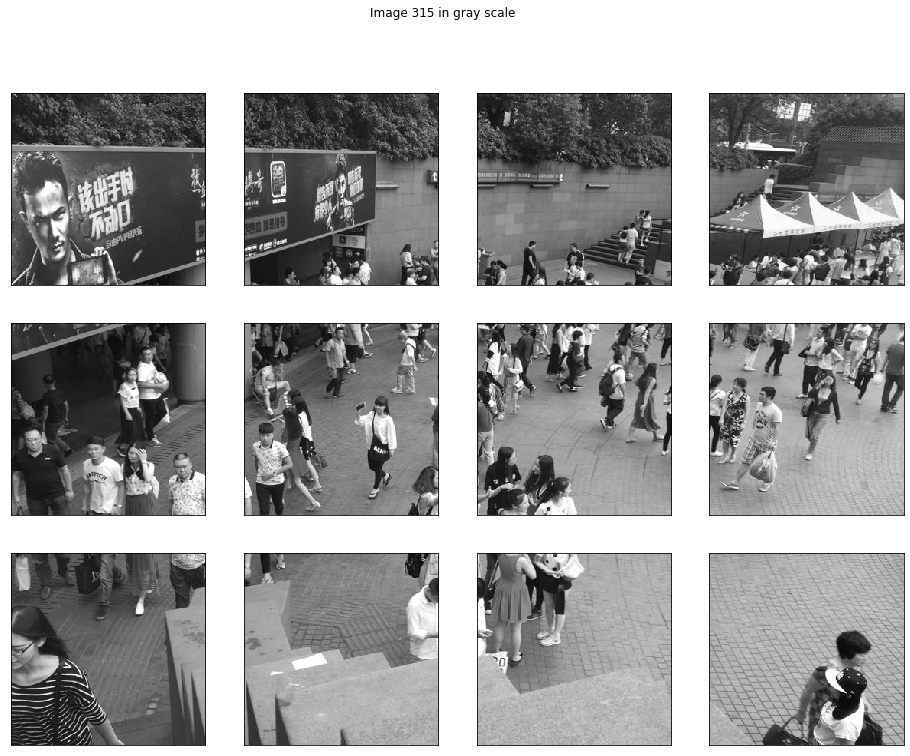

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(16,12))
fig.suptitle('Image 315 in gray scale') 
for i in range(0,3):
  for j in range(0,4):
    temp = np.load('/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/TestDataset/Image315_'+str(4*i+j)+'.npy')
    axs[i,j].imshow(temp,cmap=plt.get_cmap('gray'), interpolation='nearest', aspect='auto')
    axs[i,j].set_xticks(())
    axs[i,j].set_yticks(())

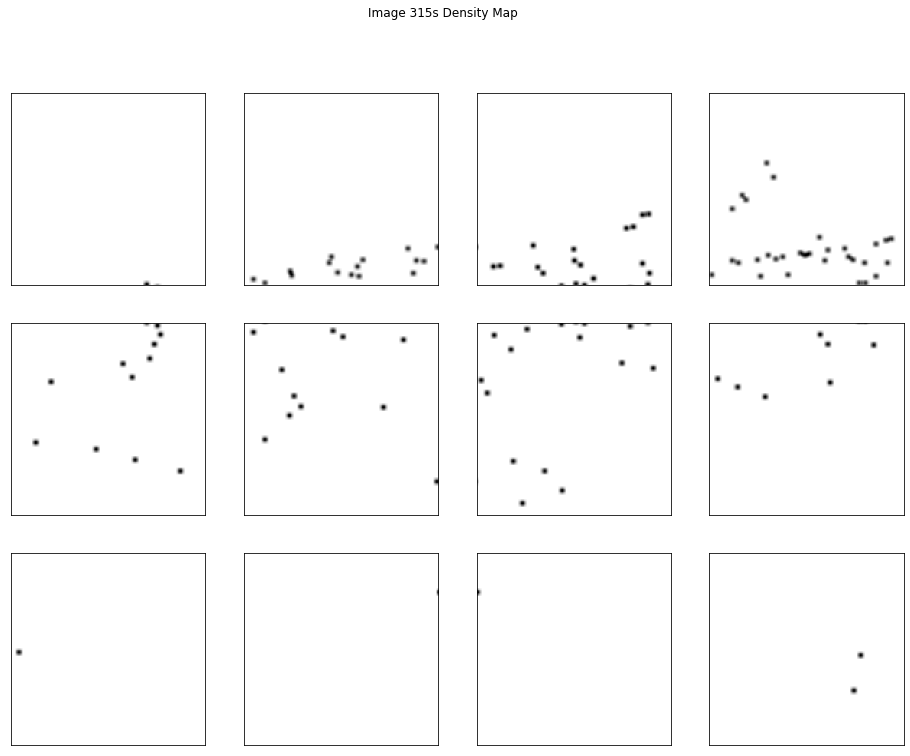

In [ ]:
fig, axs = plt.subplots(3,4, figsize=(16,12))
fig.suptitle('Image 315''s Density Map') 
for i in range(0,3):
  for j in range(0,4):
    temp = np.load('/content/gdrive/My Drive/Colab Notebooks/Atena Stuff/Dataset/TestDataset/DMap315_'+str(4*i+j)+'.npy')
    axs[i,j].imshow(temp, cmap=CM.Greys, interpolation='nearest', aspect='auto')
    axs[i,j].set_xticks(())
    axs[i,j].set_yticks(())

##  <font color=MediumSlateBlue>Loading Patches of Data and Creating Batches</font> ##

In [9]:
myTrainDatasetLoader = DatasetLoader('/content/gdrive/MyDrive/Dataset/TrainDataset', 400)

In [10]:
batchTrainDataset = DataLoader(myTrainDatasetLoader, batch_size=1, 
                               shuffle=True, pin_memory=True)

In [11]:
myTestDatasetLoader = DatasetLoader('/content/gdrive/MyDrive/Dataset/TestDataset', 316)

In [12]:
batchTestDataset = DataLoader(myTestDatasetLoader, batch_size=1, 
                               shuffle=True, pin_memory=True)

##  <font color=MediumSlateBlue>Training</font> ##

In [20]:
myCCNN = CCNN()

if torch.cuda.is_available():
     myCCNN = myCCNN.cuda()

criterionMSE = nn.MSELoss()
criterionMAE = nn.L1Loss()
optimizer = torch.optim.SGD(myCCNN.parameters(), lr=0.001, momentum=0.95)

Epoch 1 has started......
Training the network......
Train Results:
Iteration:100 	 Loss1:0.06162
Iteration:100 	 Loss2:0.08174


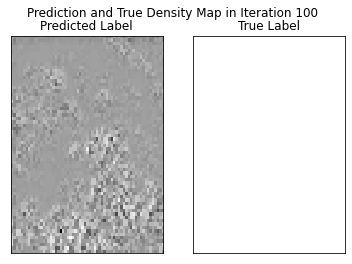

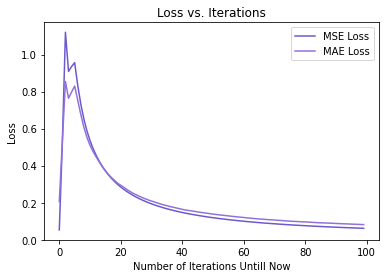



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00156
After 100 data, MAE loss is:0.01961


Train Results:
Iteration:200 	 Loss1:0.03153
Iteration:200 	 Loss2:0.05033


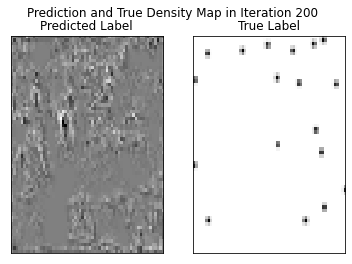

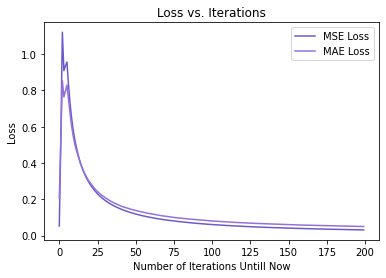



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00125
After 100 data, MAE loss is:0.01684


Train Results:
Iteration:300 	 Loss1:0.02137
Iteration:300 	 Loss2:0.03834


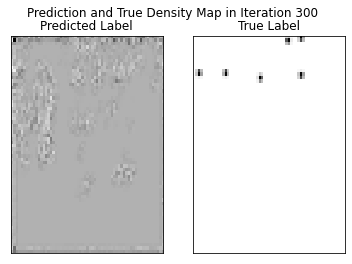

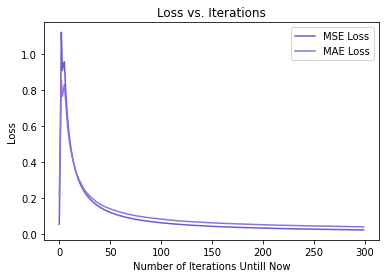



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00117
After 100 data, MAE loss is:0.01411


Train Results:
Iteration:400 	 Loss1:0.01636
Iteration:400 	 Loss2:0.03262


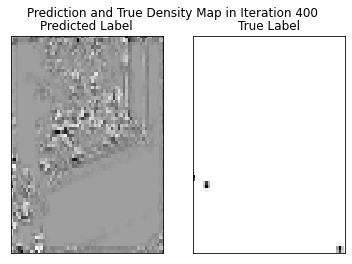

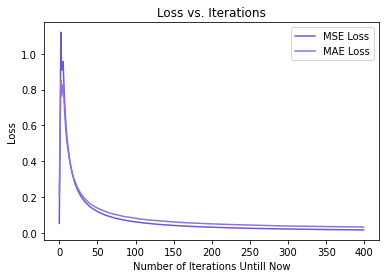



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00122
After 100 data, MAE loss is:0.01540


Train Results:
Iteration:500 	 Loss1:0.01328
Iteration:500 	 Loss2:0.02875


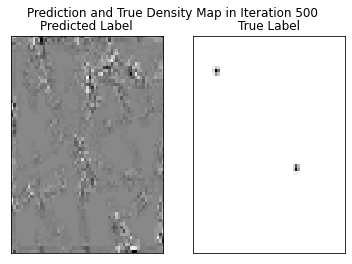

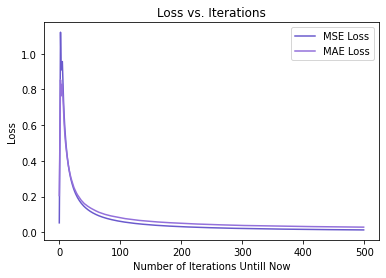



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00117
After 100 data, MAE loss is:0.01331


Train Results:
Iteration:600 	 Loss1:0.01121
Iteration:600 	 Loss2:0.02606


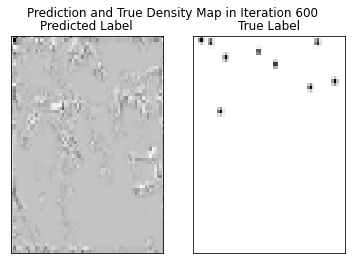

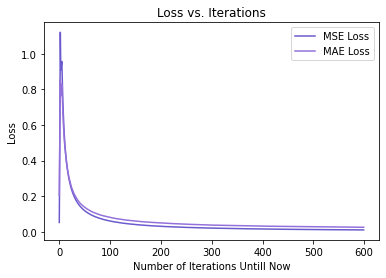



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00082
After 100 data, MAE loss is:0.01130


Train Results:
Iteration:700 	 Loss1:0.00974
Iteration:700 	 Loss2:0.02408


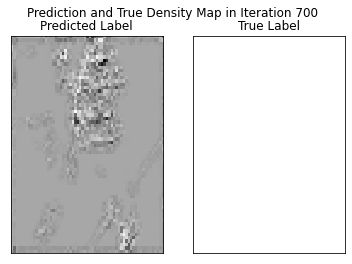

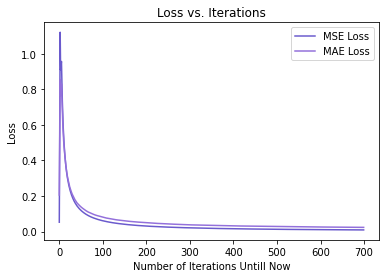



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00072
After 100 data, MAE loss is:0.01053


Train Results:
Iteration:800 	 Loss1:0.00863
Iteration:800 	 Loss2:0.02248


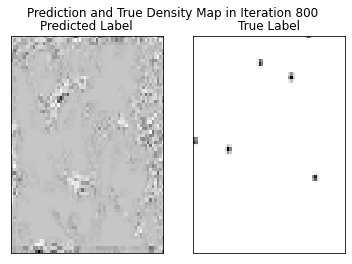

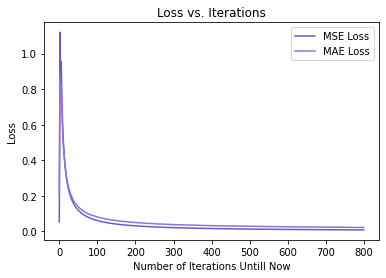



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00054
After 100 data, MAE loss is:0.00859


Train Results:
Iteration:900 	 Loss1:0.00774
Iteration:900 	 Loss2:0.02113


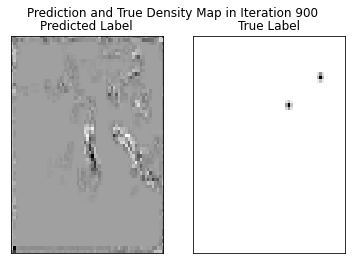

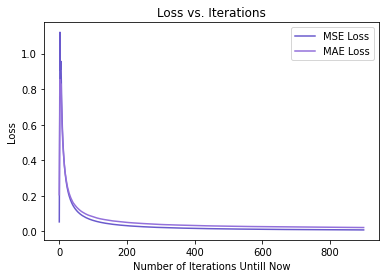



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00076
After 100 data, MAE loss is:0.01057


Train Results:
Iteration:1000 	 Loss1:0.00703
Iteration:1000 	 Loss2:0.02000


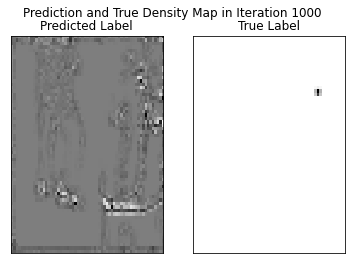

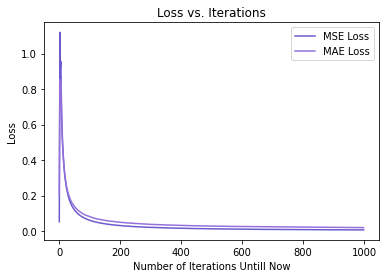



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00072
After 100 data, MAE loss is:0.01037


Train Results:
Iteration:1100 	 Loss1:0.00645
Iteration:1100 	 Loss2:0.01901


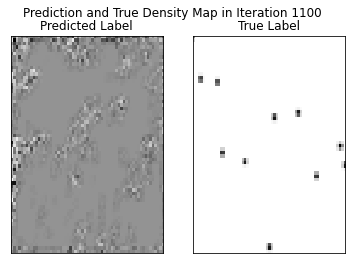

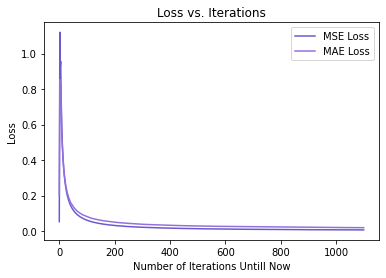



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00083
After 100 data, MAE loss is:0.01080


Train Results:
Iteration:1200 	 Loss1:0.00598
Iteration:1200 	 Loss2:0.01827


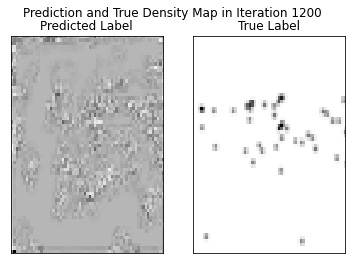

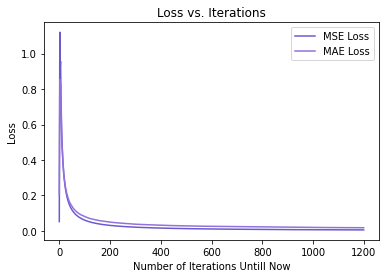



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00870


Train Results:
Iteration:1300 	 Loss1:0.00558
Iteration:1300 	 Loss2:0.01758


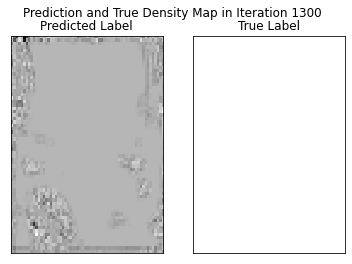

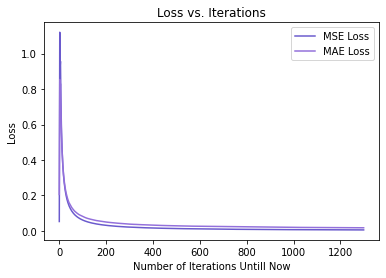



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00091
After 100 data, MAE loss is:0.01055


Train Results:
Iteration:1400 	 Loss1:0.00522
Iteration:1400 	 Loss2:0.01695


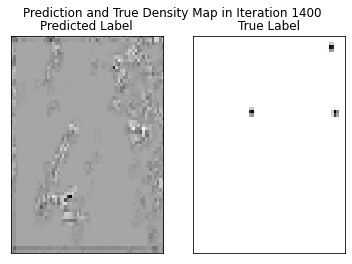

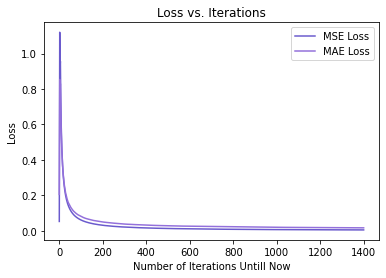



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00074
After 100 data, MAE loss is:0.00970


Train Results:
Iteration:1500 	 Loss1:0.00492
Iteration:1500 	 Loss2:0.01637


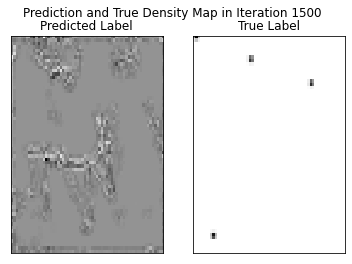

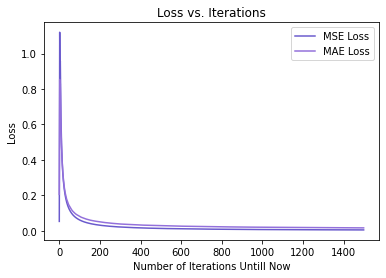



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00052
After 100 data, MAE loss is:0.00802


Train Results:
Iteration:1600 	 Loss1:0.00465
Iteration:1600 	 Loss2:0.01589


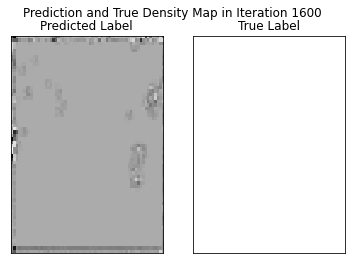

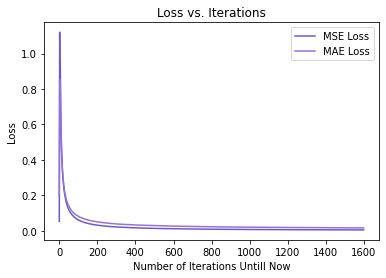



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00078
After 100 data, MAE loss is:0.00892


Train Results:
Iteration:1700 	 Loss1:0.00441
Iteration:1700 	 Loss2:0.01550


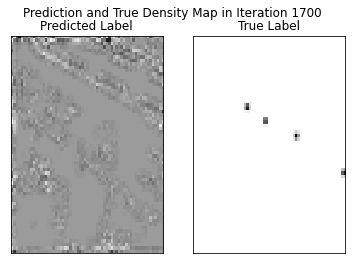

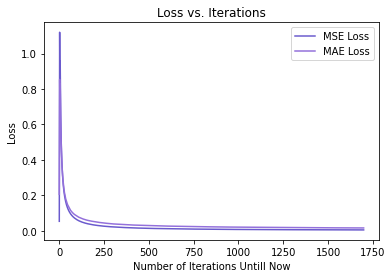



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00078
After 100 data, MAE loss is:0.00925


Train Results:
Iteration:1800 	 Loss1:0.00422
Iteration:1800 	 Loss2:0.01514


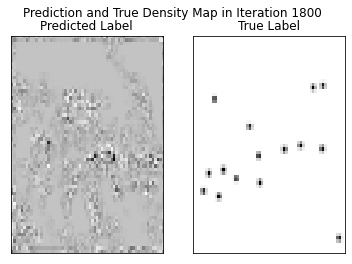

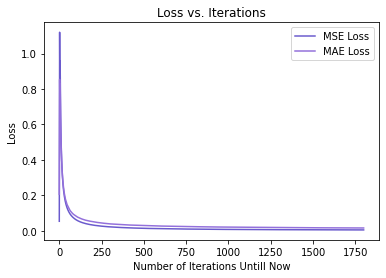



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00077
After 100 data, MAE loss is:0.00867


Train Results:
Iteration:1900 	 Loss1:0.00404
Iteration:1900 	 Loss2:0.01483


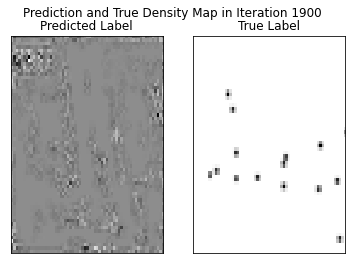

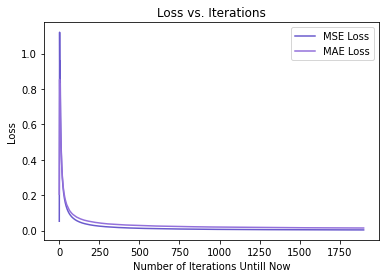



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00059
After 100 data, MAE loss is:0.00817


Train Results:
Iteration:2000 	 Loss1:0.00386
Iteration:2000 	 Loss2:0.01444


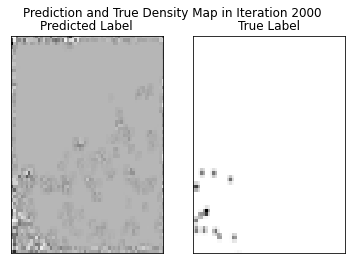

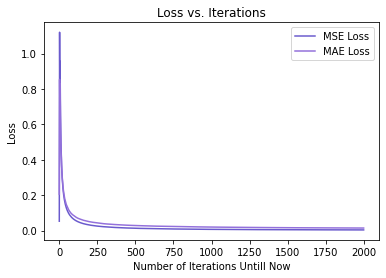



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00054
After 100 data, MAE loss is:0.00776


Train Results:
Iteration:2100 	 Loss1:0.00370
Iteration:2100 	 Loss2:0.01409


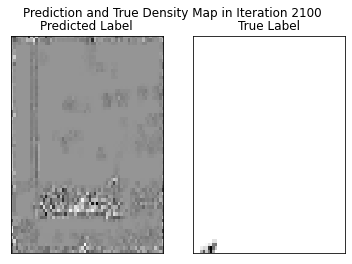

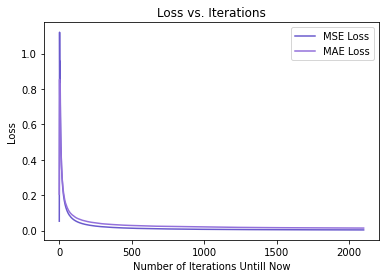



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00067
After 100 data, MAE loss is:0.00767


Train Results:
Iteration:2200 	 Loss1:0.00356
Iteration:2200 	 Loss2:0.01379


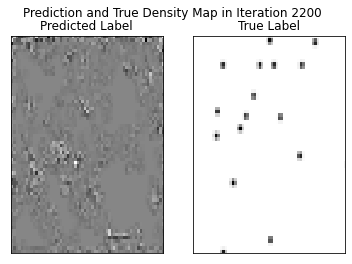

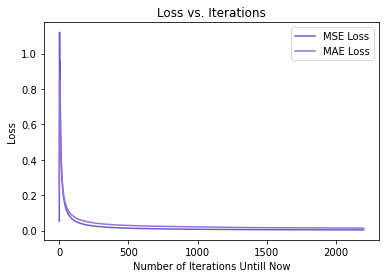



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00047
After 100 data, MAE loss is:0.00718


Train Results:
Iteration:2300 	 Loss1:0.00343
Iteration:2300 	 Loss2:0.01354


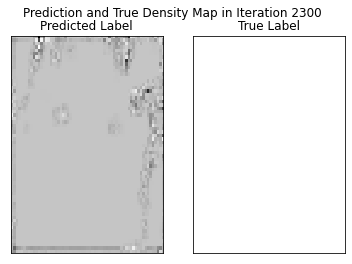

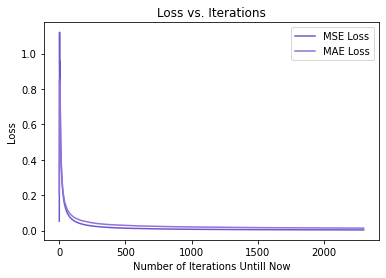



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00657


Train Results:
Iteration:2400 	 Loss1:0.00332
Iteration:2400 	 Loss2:0.01327


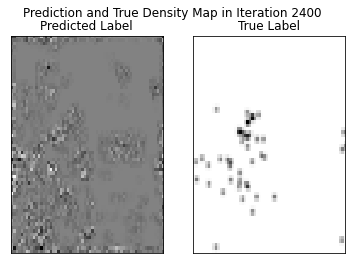

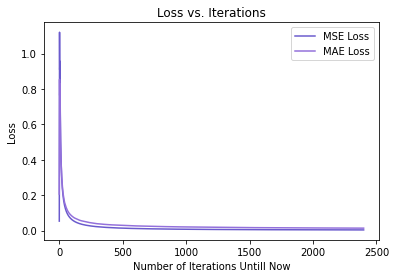



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00065
After 100 data, MAE loss is:0.00750


Train Results:
Iteration:2500 	 Loss1:0.00321
Iteration:2500 	 Loss2:0.01303


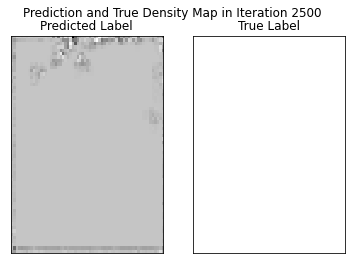

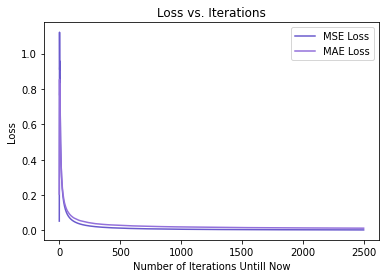



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00087
After 100 data, MAE loss is:0.00840


Train Results:
Iteration:2600 	 Loss1:0.00311
Iteration:2600 	 Loss2:0.01281


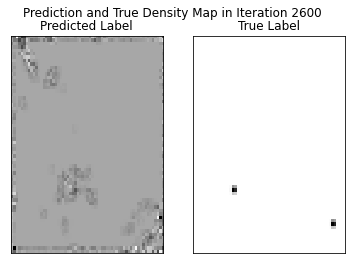

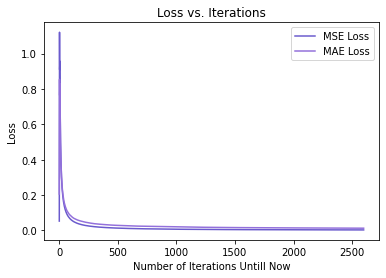



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00076
After 100 data, MAE loss is:0.00782


Train Results:
Iteration:2700 	 Loss1:0.00301
Iteration:2700 	 Loss2:0.01261


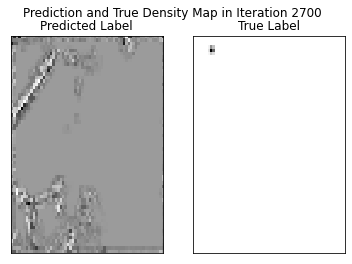

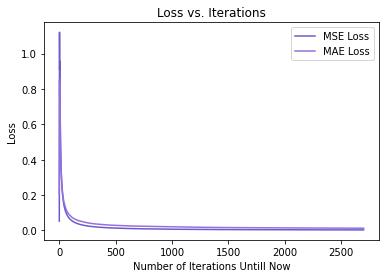



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00067
After 100 data, MAE loss is:0.00696


Train Results:
Iteration:2800 	 Loss1:0.00293
Iteration:2800 	 Loss2:0.01242


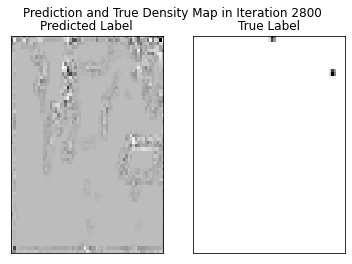

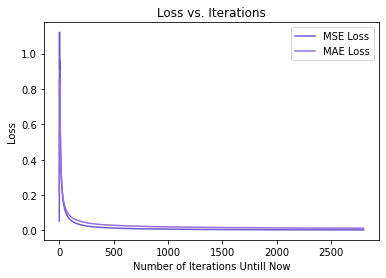



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00679


Train Results:
Iteration:2900 	 Loss1:0.00284
Iteration:2900 	 Loss2:0.01222


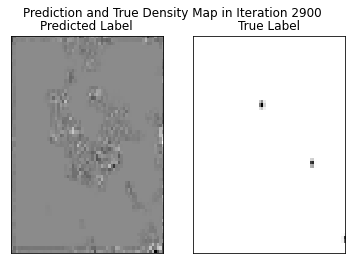

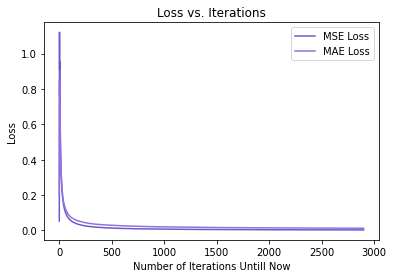



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00049
After 100 data, MAE loss is:0.00629


Train Results:
Iteration:3000 	 Loss1:0.00277
Iteration:3000 	 Loss2:0.01204


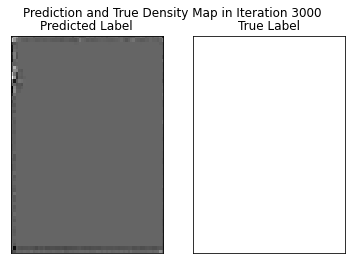

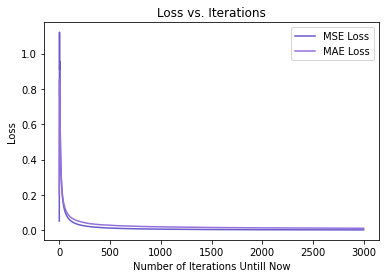



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00062
After 100 data, MAE loss is:0.00708


Train Results:
Iteration:3100 	 Loss1:0.00270
Iteration:3100 	 Loss2:0.01191


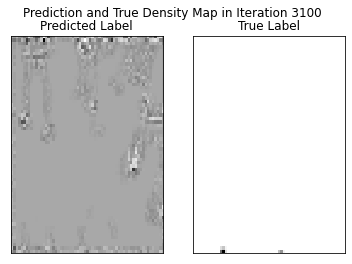

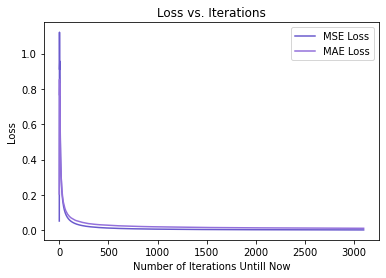



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00086
After 100 data, MAE loss is:0.00749


Train Results:
Iteration:3200 	 Loss1:0.00263
Iteration:3200 	 Loss2:0.01175


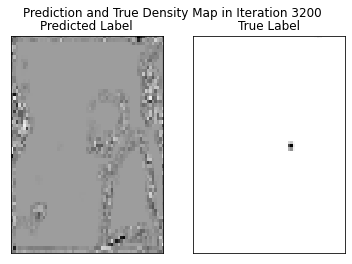

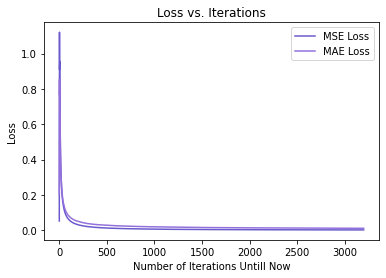



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00771


Train Results:
Iteration:3300 	 Loss1:0.00257
Iteration:3300 	 Loss2:0.01161


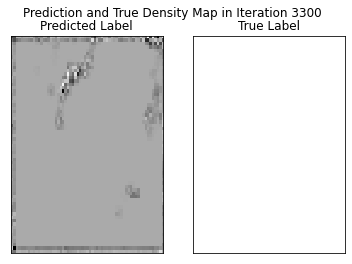

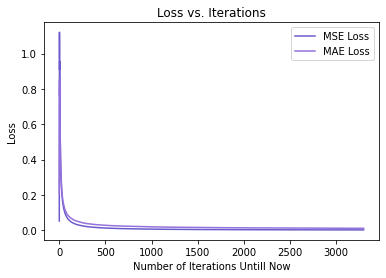



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00699


Train Results:
Iteration:3400 	 Loss1:0.00252
Iteration:3400 	 Loss2:0.01149


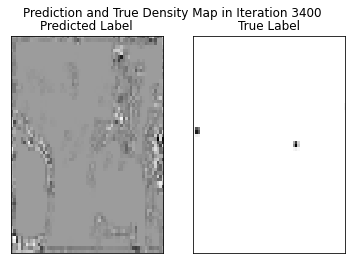

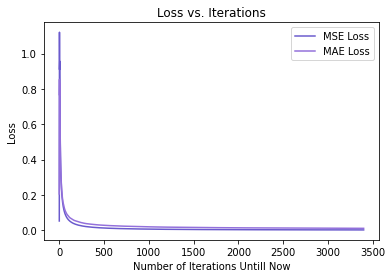



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00622


Train Results:
Iteration:3500 	 Loss1:0.00246
Iteration:3500 	 Loss2:0.01133


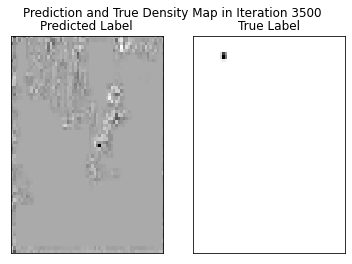

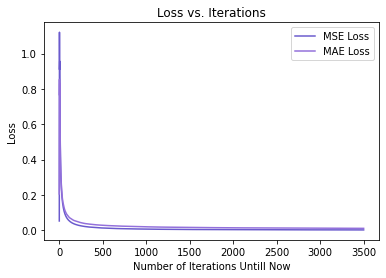



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00647


Train Results:
Iteration:3600 	 Loss1:0.00240
Iteration:3600 	 Loss2:0.01116


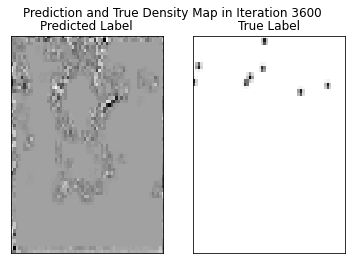

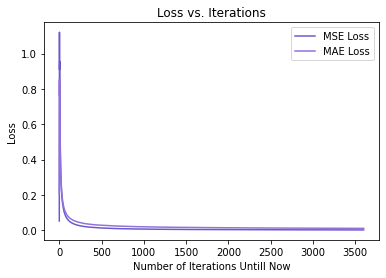



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00057
After 100 data, MAE loss is:0.00645


Train Results:
Iteration:3700 	 Loss1:0.00235
Iteration:3700 	 Loss2:0.01103


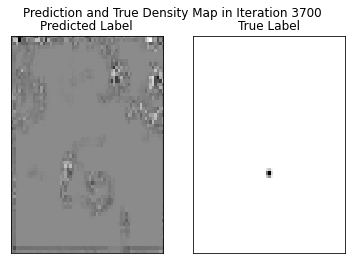

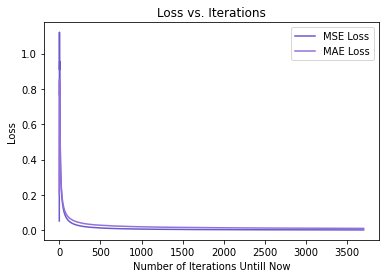



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00629


Train Results:
Iteration:3800 	 Loss1:0.00231
Iteration:3800 	 Loss2:0.01090


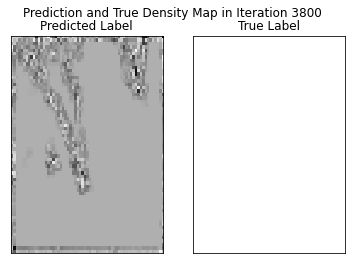

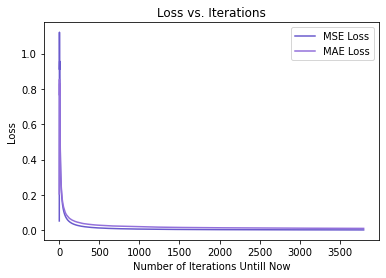



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00041
After 100 data, MAE loss is:0.00576


Train Results:
Iteration:3900 	 Loss1:0.00226
Iteration:3900 	 Loss2:0.01077


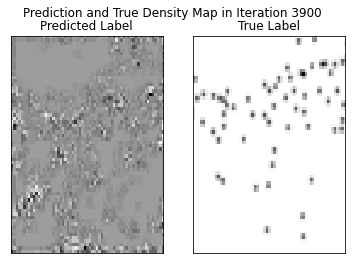

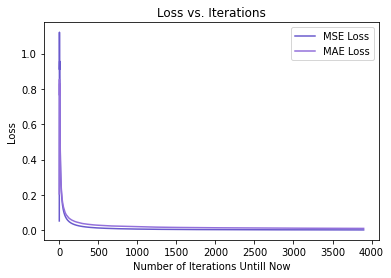



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00058
After 100 data, MAE loss is:0.00636


Train Results:
Iteration:4000 	 Loss1:0.00222
Iteration:4000 	 Loss2:0.01069


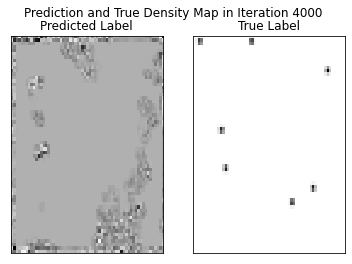

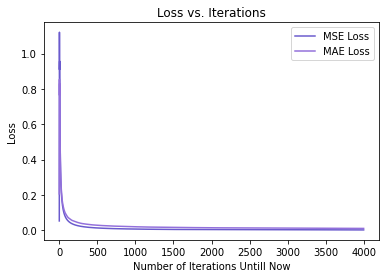



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00054
After 100 data, MAE loss is:0.00663


Train Results:
Iteration:4100 	 Loss1:0.00219
Iteration:4100 	 Loss2:0.01060


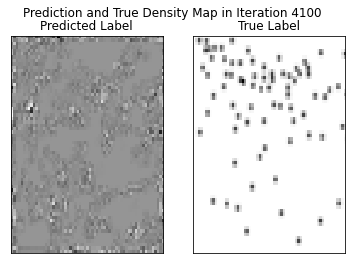

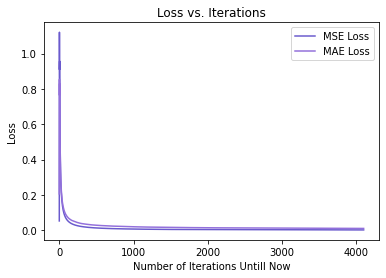



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00718


Train Results:
Iteration:4200 	 Loss1:0.00215
Iteration:4200 	 Loss2:0.01051


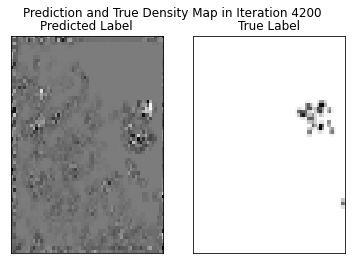

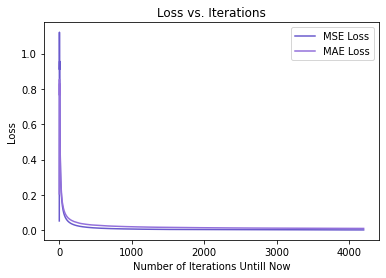



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00104
After 100 data, MAE loss is:0.00834


Train Results:
Iteration:4300 	 Loss1:0.00211
Iteration:4300 	 Loss2:0.01039


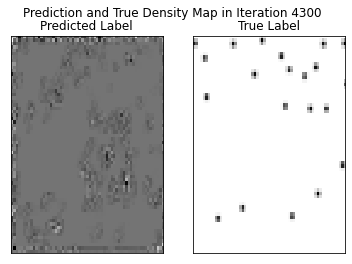

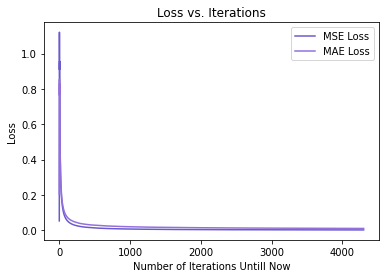



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00082
After 100 data, MAE loss is:0.00758


Train Results:
Iteration:4400 	 Loss1:0.00207
Iteration:4400 	 Loss2:0.01026


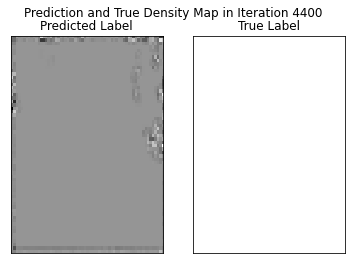

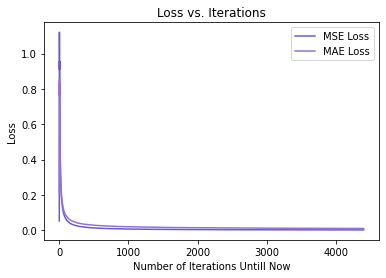



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00074
After 100 data, MAE loss is:0.00664


Train Results:
Iteration:4500 	 Loss1:0.00204
Iteration:4500 	 Loss2:0.01019


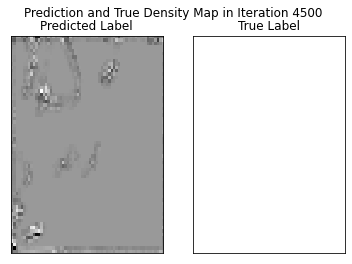

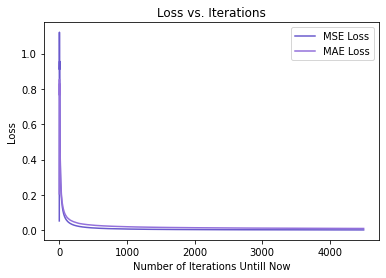



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00569


Train Results:
Iteration:4600 	 Loss1:0.00200
Iteration:4600 	 Loss2:0.01009


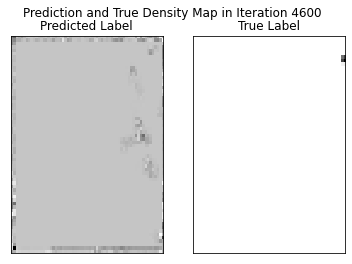

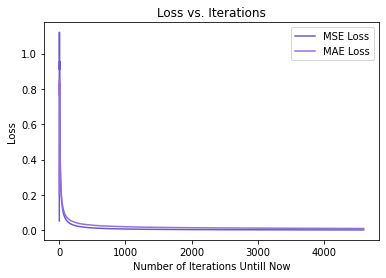



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00074
After 100 data, MAE loss is:0.00631


Train Results:
Iteration:4700 	 Loss1:0.00197
Iteration:4700 	 Loss2:0.00999


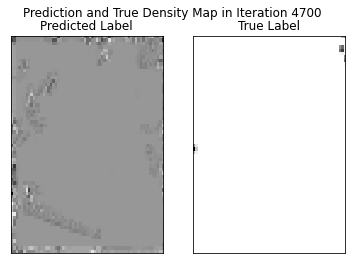

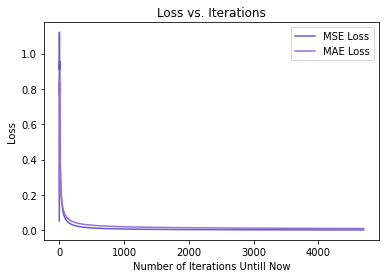



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00582


Train Results:
Iteration:4800 	 Loss1:0.00194
Iteration:4800 	 Loss2:0.00992


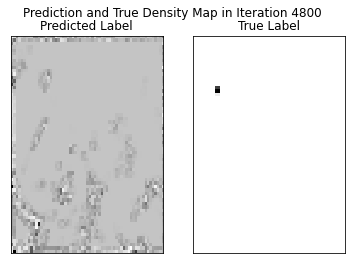

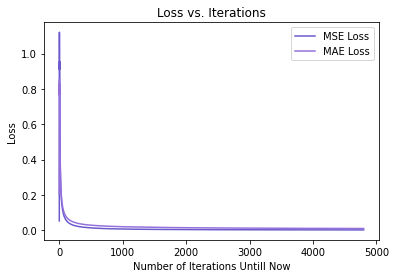



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00600


At the end of epoch 1 the average train loss of MSE is: 0.00194
At the end of epoch 1 the average train loss of MAE is: 0.00992
Epoch 2 has started......
Training the network......
Train Results:
Iteration:100 	 Loss1:0.00045
Iteration:100 	 Loss2:0.00557


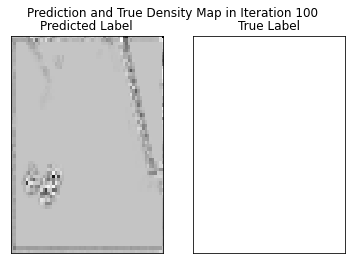

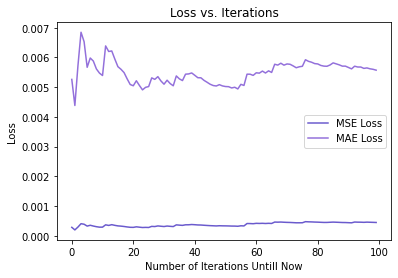



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00504


Train Results:
Iteration:200 	 Loss1:0.00044
Iteration:200 	 Loss2:0.00550


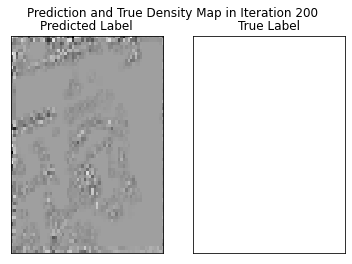

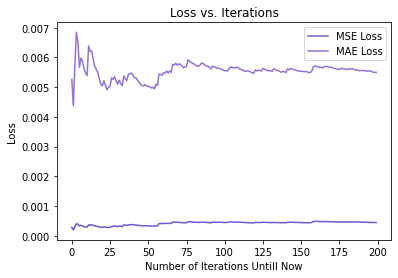



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00061
After 100 data, MAE loss is:0.00621


Train Results:
Iteration:300 	 Loss1:0.00049
Iteration:300 	 Loss2:0.00572


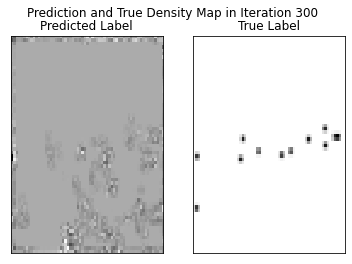

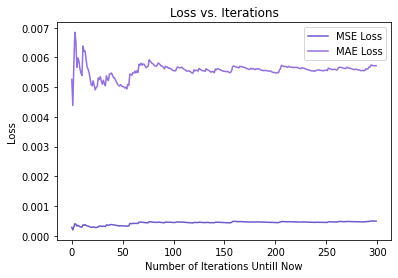



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00072
After 100 data, MAE loss is:0.00708


Train Results:
Iteration:400 	 Loss1:0.00058
Iteration:400 	 Loss2:0.00616


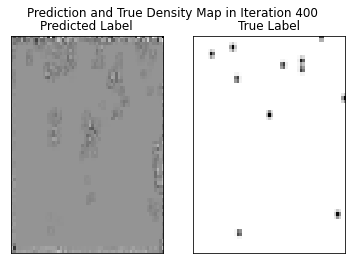

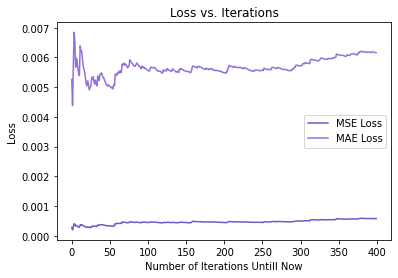



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00056
After 100 data, MAE loss is:0.00655


Train Results:
Iteration:500 	 Loss1:0.00053
Iteration:500 	 Loss2:0.00600


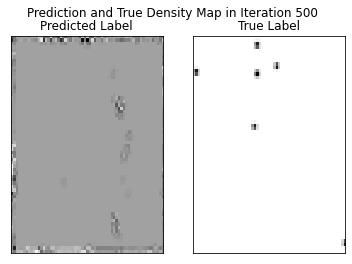

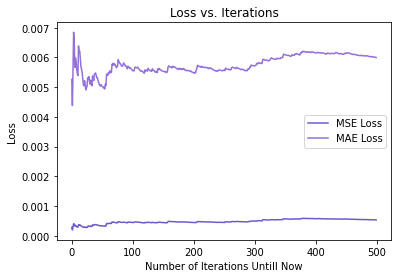



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00031
After 100 data, MAE loss is:0.00448


Train Results:
Iteration:600 	 Loss1:0.00053
Iteration:600 	 Loss2:0.00598


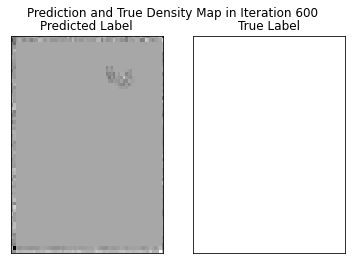

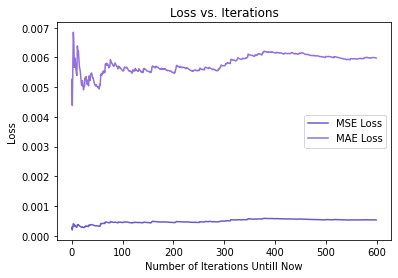



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00080
After 100 data, MAE loss is:0.00681


Train Results:
Iteration:700 	 Loss1:0.00052
Iteration:700 	 Loss2:0.00584


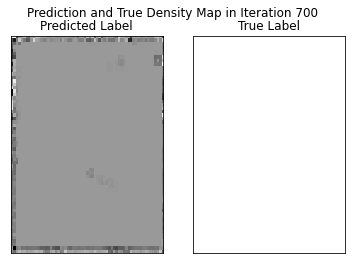

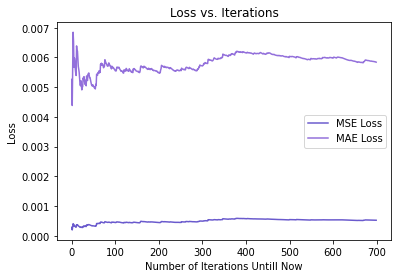



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00692


Train Results:
Iteration:800 	 Loss1:0.00053
Iteration:800 	 Loss2:0.00587


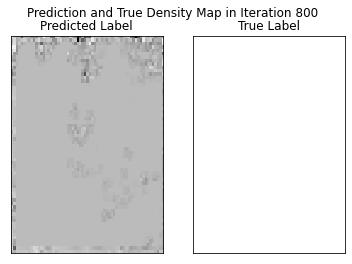

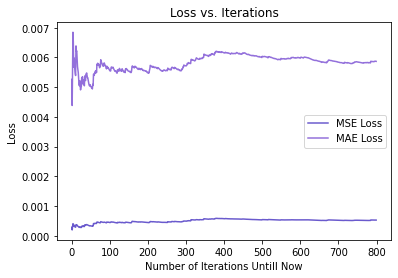



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00567


Train Results:
Iteration:900 	 Loss1:0.00054
Iteration:900 	 Loss2:0.00596


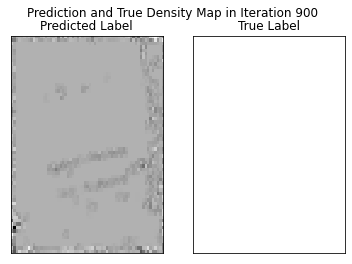

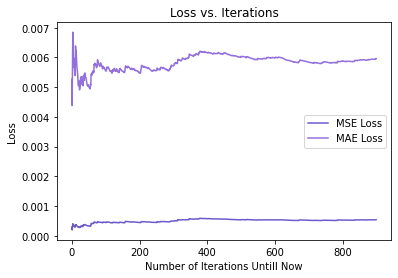



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00034
After 100 data, MAE loss is:0.00508


Train Results:
Iteration:1000 	 Loss1:0.00054
Iteration:1000 	 Loss2:0.00597


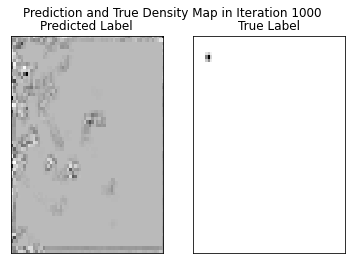

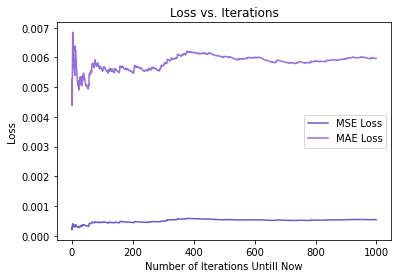



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00550


Train Results:
Iteration:1100 	 Loss1:0.00054
Iteration:1100 	 Loss2:0.00599


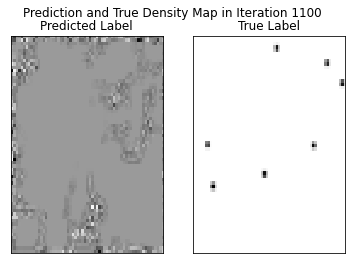

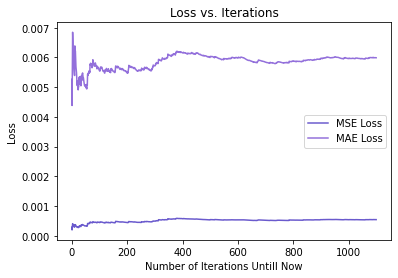



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00666


Train Results:
Iteration:1200 	 Loss1:0.00055
Iteration:1200 	 Loss2:0.00604


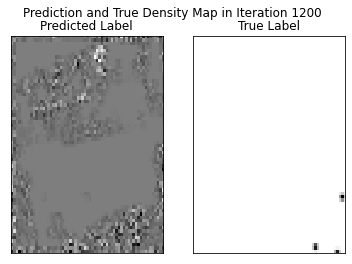

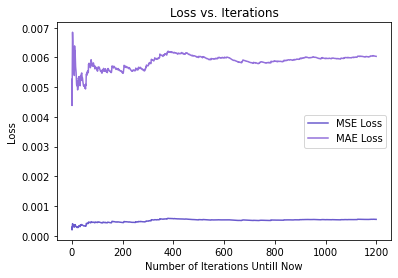



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00034
After 100 data, MAE loss is:0.00506


Train Results:
Iteration:1300 	 Loss1:0.00058
Iteration:1300 	 Loss2:0.00618


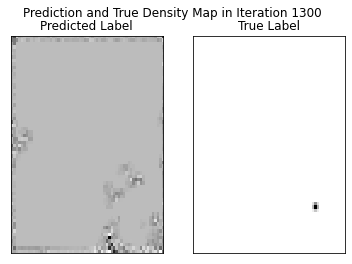

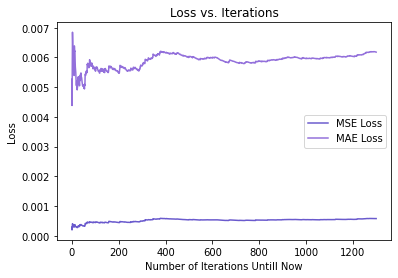



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00644


Train Results:
Iteration:1400 	 Loss1:0.00058
Iteration:1400 	 Loss2:0.00617


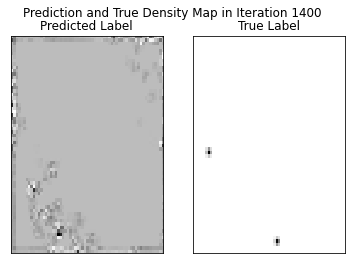

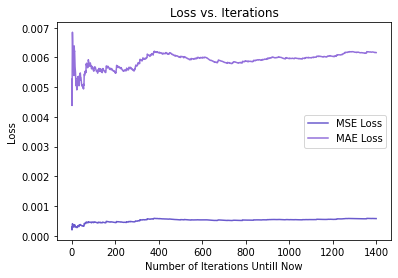



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00601


Train Results:
Iteration:1500 	 Loss1:0.00057
Iteration:1500 	 Loss2:0.00613


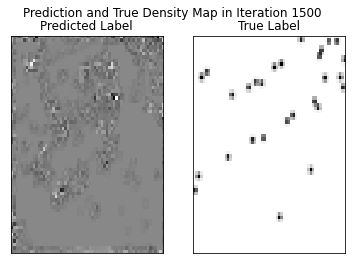

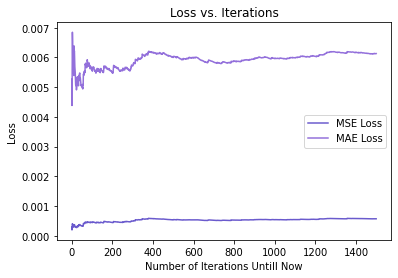



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00579


Train Results:
Iteration:1600 	 Loss1:0.00057
Iteration:1600 	 Loss2:0.00615


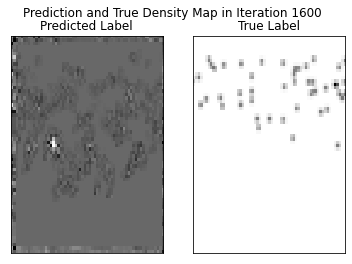

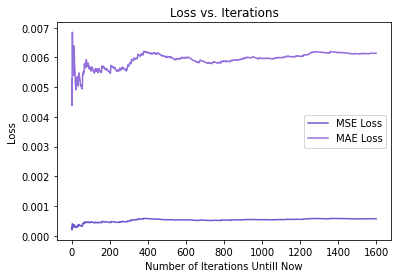



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00609


Train Results:
Iteration:1700 	 Loss1:0.00057
Iteration:1700 	 Loss2:0.00614


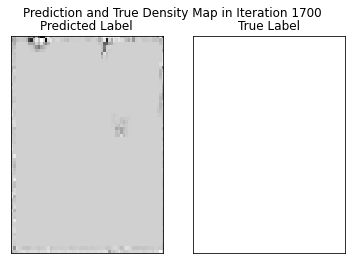

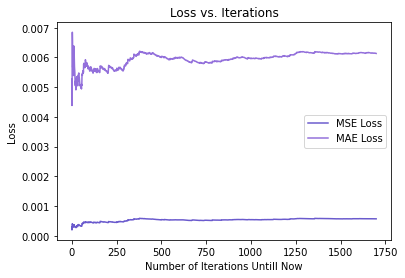



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00624


Train Results:
Iteration:1800 	 Loss1:0.00057
Iteration:1800 	 Loss2:0.00613


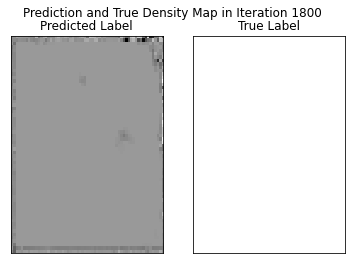

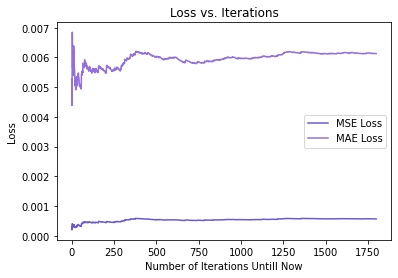



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00591


Train Results:
Iteration:1900 	 Loss1:0.00057
Iteration:1900 	 Loss2:0.00613


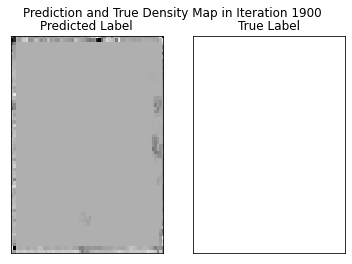

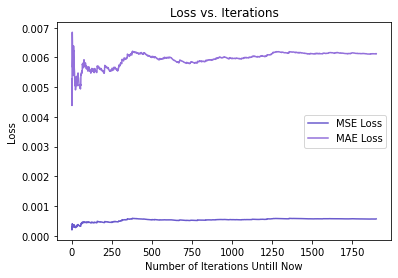



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00076
After 100 data, MAE loss is:0.00726


Train Results:
Iteration:2000 	 Loss1:0.00056
Iteration:2000 	 Loss2:0.00610


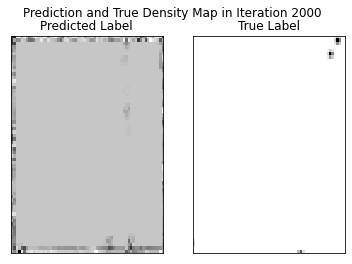

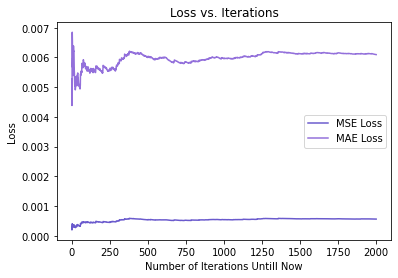



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00059
After 100 data, MAE loss is:0.00589


Train Results:
Iteration:2100 	 Loss1:0.00056
Iteration:2100 	 Loss2:0.00611


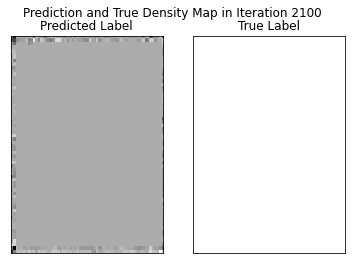

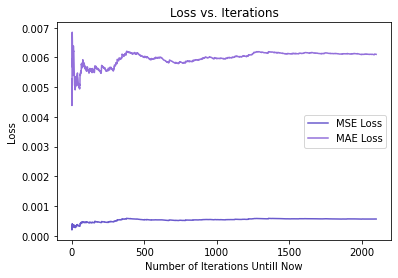



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00056
After 100 data, MAE loss is:0.00587


Train Results:
Iteration:2200 	 Loss1:0.00056
Iteration:2200 	 Loss2:0.00609


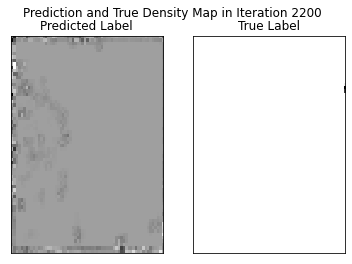

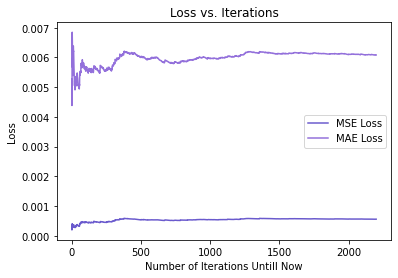



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00526


Train Results:
Iteration:2300 	 Loss1:0.00056
Iteration:2300 	 Loss2:0.00606


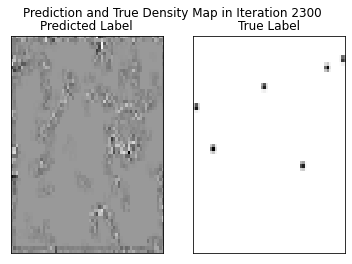

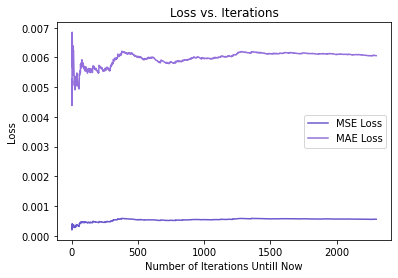



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00066
After 100 data, MAE loss is:0.00622


Train Results:
Iteration:2400 	 Loss1:0.00055
Iteration:2400 	 Loss2:0.00604


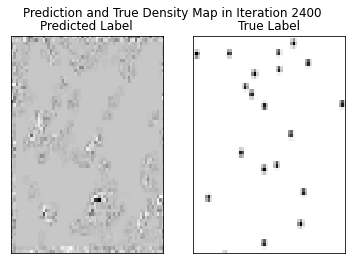

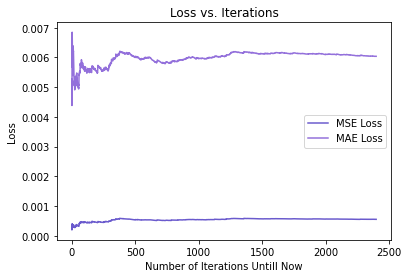



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00042
After 100 data, MAE loss is:0.00515


Train Results:
Iteration:2500 	 Loss1:0.00055
Iteration:2500 	 Loss2:0.00601


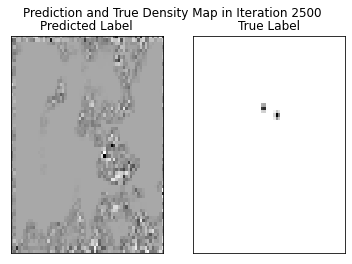

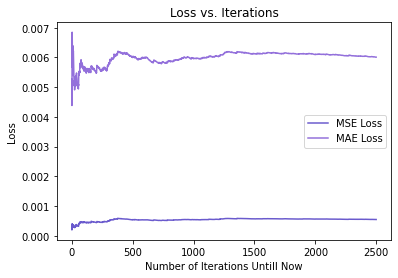



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00526


Train Results:
Iteration:2600 	 Loss1:0.00054
Iteration:2600 	 Loss2:0.00598


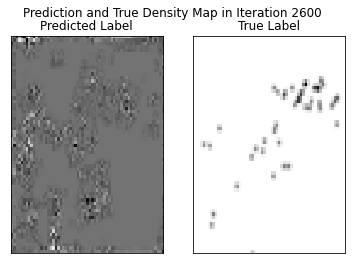

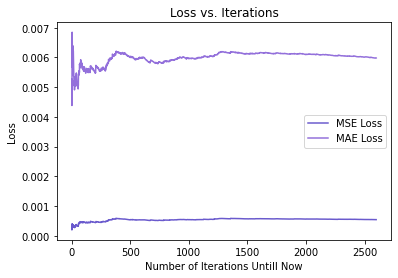



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00535


Train Results:
Iteration:2700 	 Loss1:0.00054
Iteration:2700 	 Loss2:0.00595


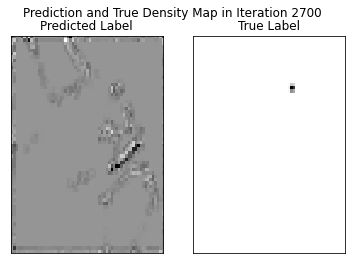

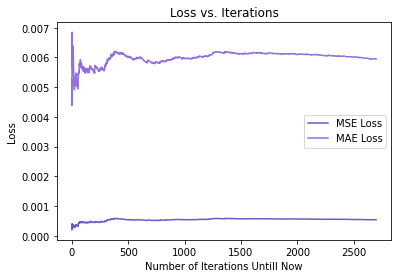



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00046
After 100 data, MAE loss is:0.00545


Train Results:
Iteration:2800 	 Loss1:0.00054
Iteration:2800 	 Loss2:0.00593


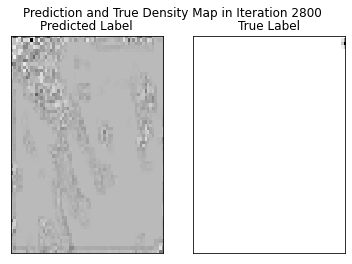

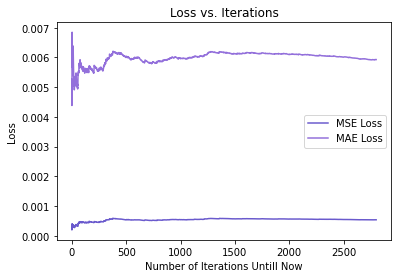



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00037
After 100 data, MAE loss is:0.00488


Train Results:
Iteration:2900 	 Loss1:0.00054
Iteration:2900 	 Loss2:0.00594


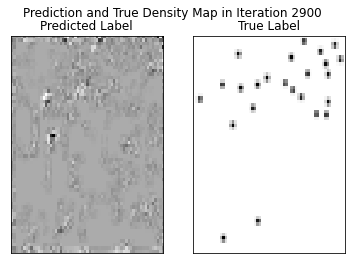

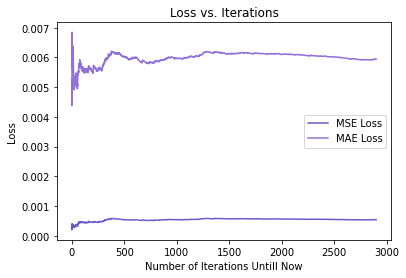



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00074
After 100 data, MAE loss is:0.00702


Train Results:
Iteration:3000 	 Loss1:0.00054
Iteration:3000 	 Loss2:0.00594


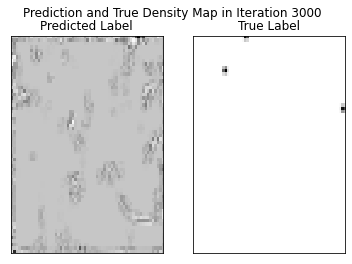

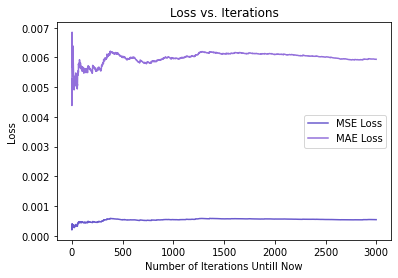



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00076
After 100 data, MAE loss is:0.00646


Train Results:
Iteration:3100 	 Loss1:0.00054
Iteration:3100 	 Loss2:0.00595


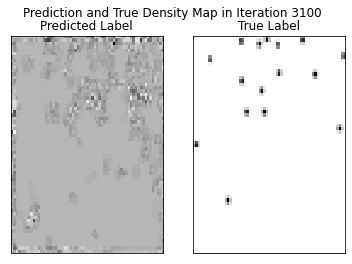

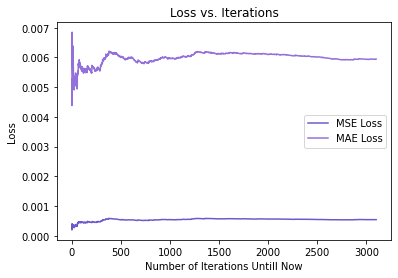



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00039
After 100 data, MAE loss is:0.00515


Train Results:
Iteration:3200 	 Loss1:0.00054
Iteration:3200 	 Loss2:0.00592


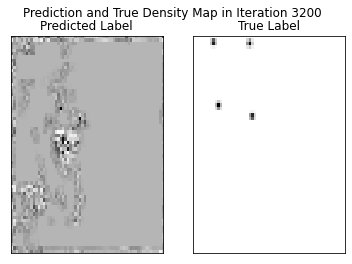

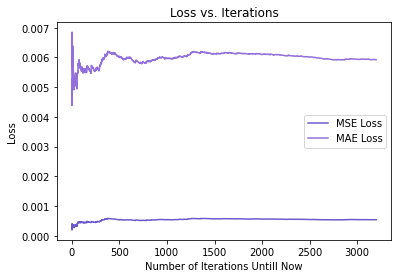



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00066
After 100 data, MAE loss is:0.00657


Train Results:
Iteration:3300 	 Loss1:0.00054
Iteration:3300 	 Loss2:0.00593


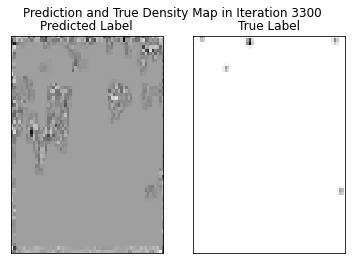

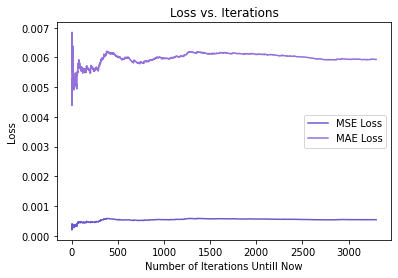



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00071
After 100 data, MAE loss is:0.00652


Train Results:
Iteration:3400 	 Loss1:0.00055
Iteration:3400 	 Loss2:0.00597


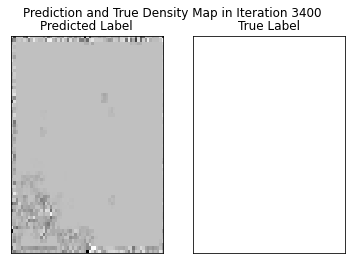

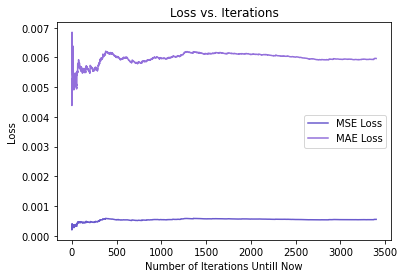



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00047
After 100 data, MAE loss is:0.00583


Train Results:
Iteration:3500 	 Loss1:0.00055
Iteration:3500 	 Loss2:0.00595


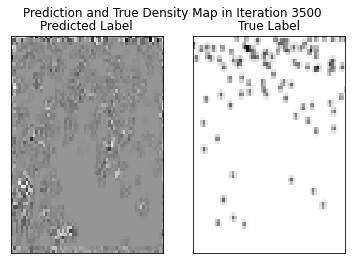

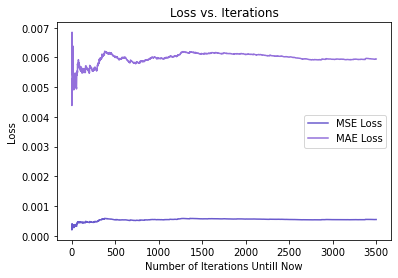



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00072
After 100 data, MAE loss is:0.00619


Train Results:
Iteration:3600 	 Loss1:0.00055
Iteration:3600 	 Loss2:0.00597


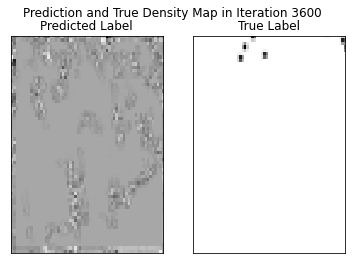

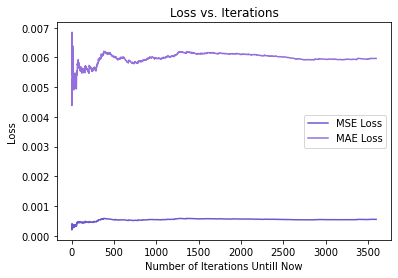



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00031
After 100 data, MAE loss is:0.00476


Train Results:
Iteration:3700 	 Loss1:0.00055
Iteration:3700 	 Loss2:0.00598


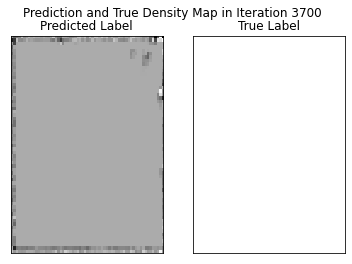

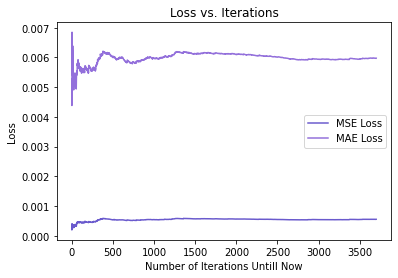



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00068
After 100 data, MAE loss is:0.00676


Train Results:
Iteration:3800 	 Loss1:0.00055
Iteration:3800 	 Loss2:0.00597


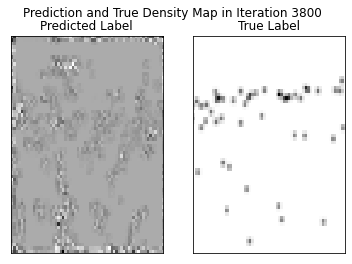

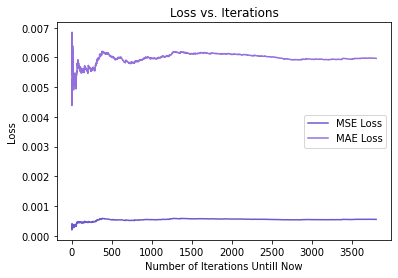



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00037
After 100 data, MAE loss is:0.00518


Train Results:
Iteration:3900 	 Loss1:0.00055
Iteration:3900 	 Loss2:0.00596


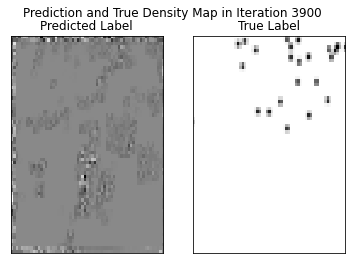

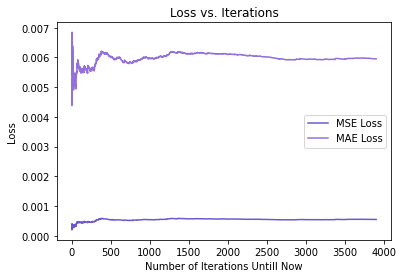



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00039
After 100 data, MAE loss is:0.00484


Train Results:
Iteration:4000 	 Loss1:0.00055
Iteration:4000 	 Loss2:0.00595


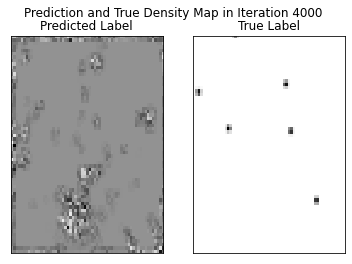

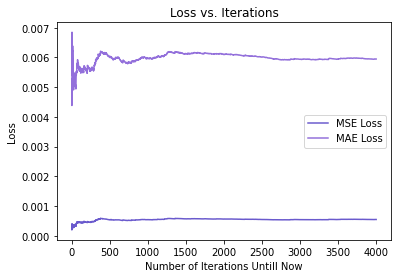



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00577


Train Results:
Iteration:4100 	 Loss1:0.00055
Iteration:4100 	 Loss2:0.00596


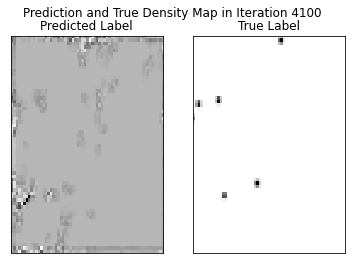

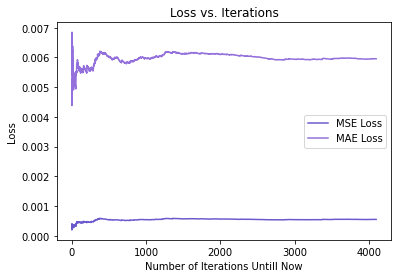



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00504


Train Results:
Iteration:4200 	 Loss1:0.00055
Iteration:4200 	 Loss2:0.00596


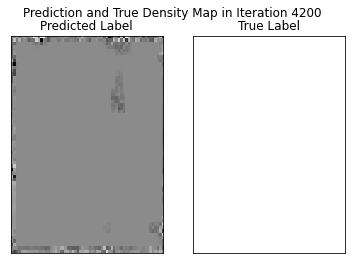

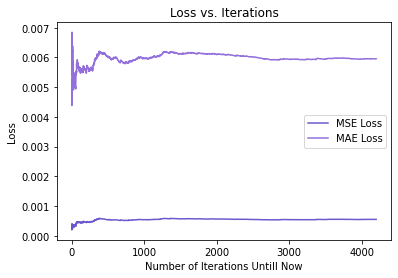



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00038
After 100 data, MAE loss is:0.00497


Train Results:
Iteration:4300 	 Loss1:0.00055
Iteration:4300 	 Loss2:0.00595


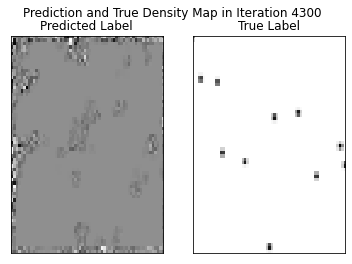

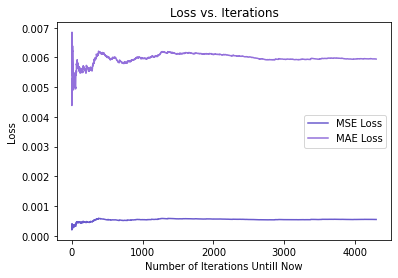



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00063
After 100 data, MAE loss is:0.00593


Train Results:
Iteration:4400 	 Loss1:0.00054
Iteration:4400 	 Loss2:0.00592


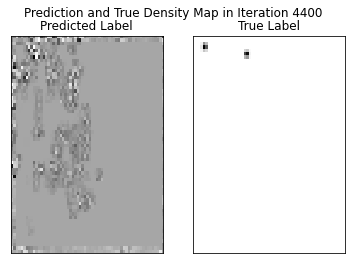

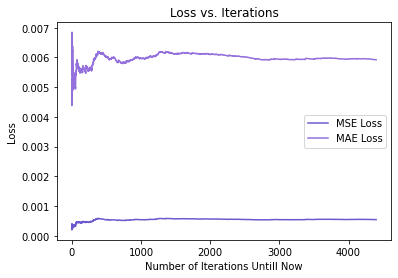



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00050
After 100 data, MAE loss is:0.00557


Train Results:
Iteration:4500 	 Loss1:0.00054
Iteration:4500 	 Loss2:0.00590


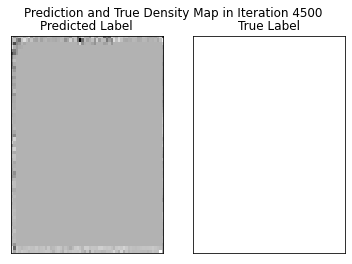

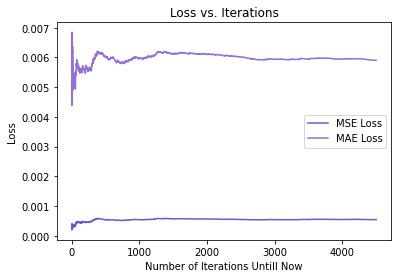



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00044
After 100 data, MAE loss is:0.00538


Train Results:
Iteration:4600 	 Loss1:0.00054
Iteration:4600 	 Loss2:0.00587


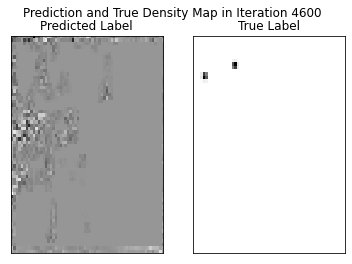

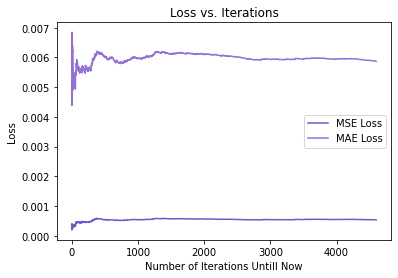



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00037
After 100 data, MAE loss is:0.00440


Train Results:
Iteration:4700 	 Loss1:0.00054
Iteration:4700 	 Loss2:0.00586


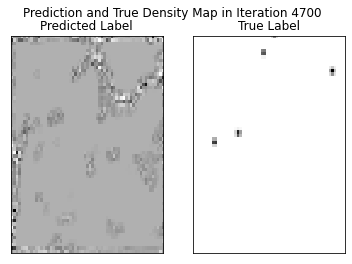

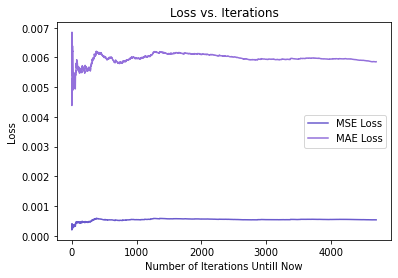



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00046
After 100 data, MAE loss is:0.00528


Train Results:
Iteration:4800 	 Loss1:0.00054
Iteration:4800 	 Loss2:0.00587


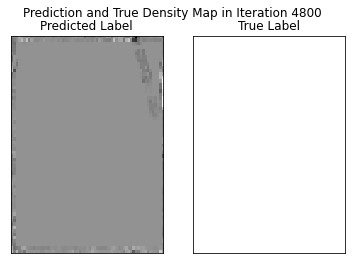

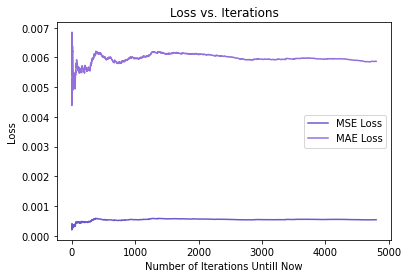



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00557


At the end of epoch 2 the average train loss of MSE is: 0.00054
At the end of epoch 2 the average train loss of MAE is: 0.00587
Epoch 3 has started......
Training the network......
Train Results:
Iteration:100 	 Loss1:0.00064
Iteration:100 	 Loss2:0.00619


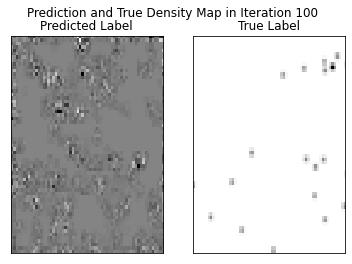

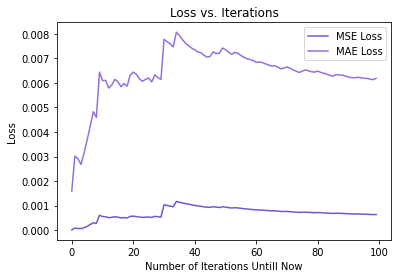



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00567


Train Results:
Iteration:200 	 Loss1:0.00059
Iteration:200 	 Loss2:0.00607


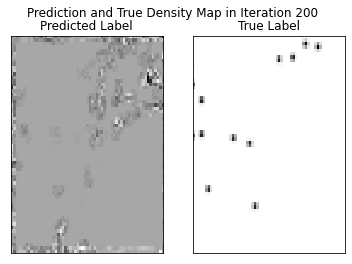

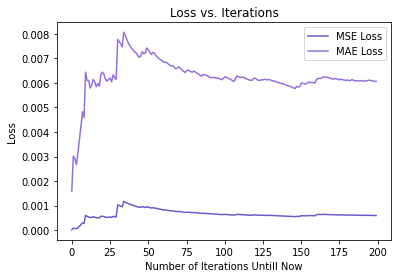



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00076
After 100 data, MAE loss is:0.00613


Train Results:
Iteration:300 	 Loss1:0.00055
Iteration:300 	 Loss2:0.00588


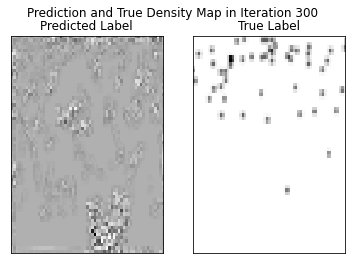

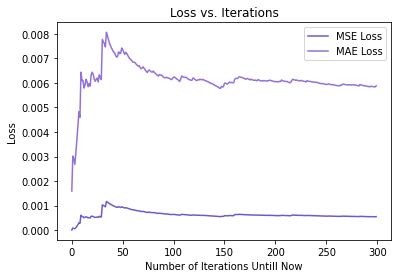



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00067
After 100 data, MAE loss is:0.00607


Train Results:
Iteration:400 	 Loss1:0.00057
Iteration:400 	 Loss2:0.00597


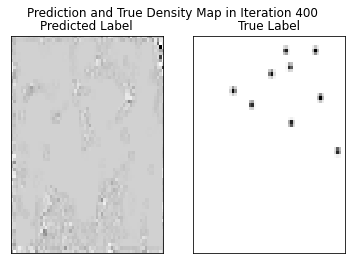

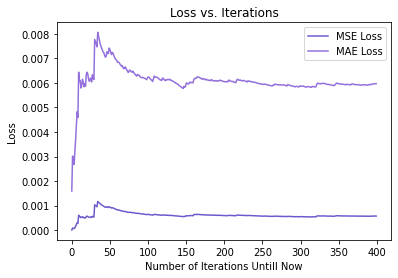



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00052
After 100 data, MAE loss is:0.00574


Train Results:
Iteration:500 	 Loss1:0.00057
Iteration:500 	 Loss2:0.00602


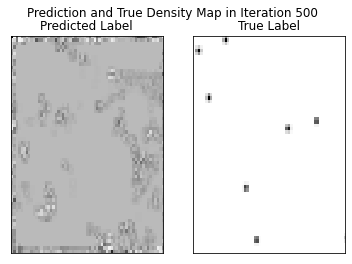

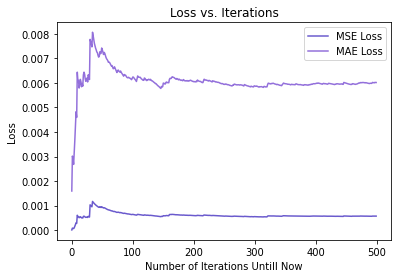



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00598


Train Results:
Iteration:600 	 Loss1:0.00057
Iteration:600 	 Loss2:0.00604


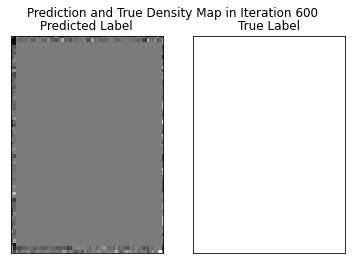

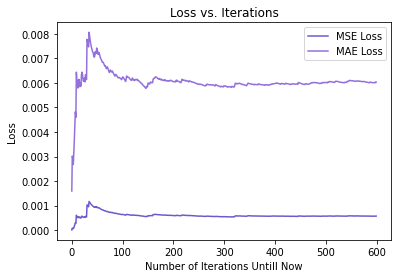



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00049
After 100 data, MAE loss is:0.00590


Train Results:
Iteration:700 	 Loss1:0.00056
Iteration:700 	 Loss2:0.00594


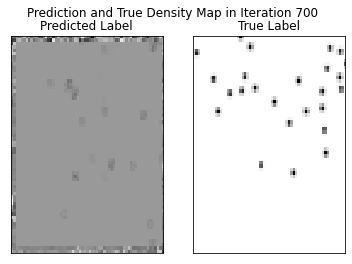

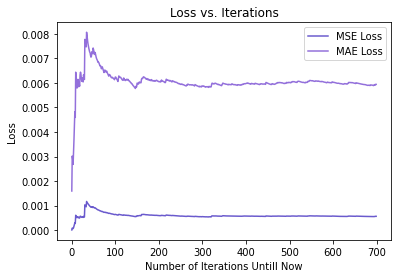



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00042
After 100 data, MAE loss is:0.00547


Train Results:
Iteration:800 	 Loss1:0.00056
Iteration:800 	 Loss2:0.00593


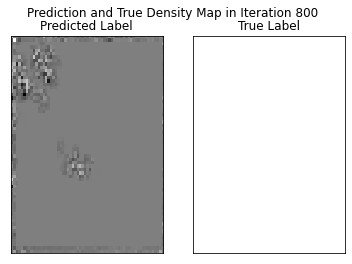

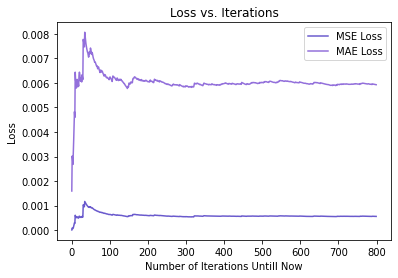



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00068
After 100 data, MAE loss is:0.00604


Train Results:
Iteration:900 	 Loss1:0.00056
Iteration:900 	 Loss2:0.00595


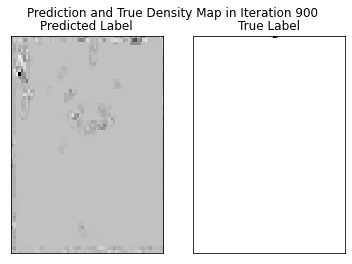

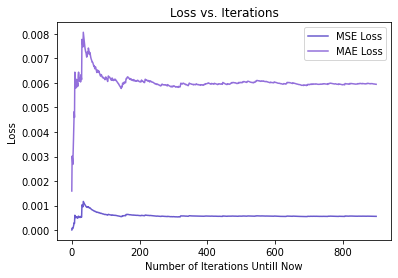



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00580


Train Results:
Iteration:1000 	 Loss1:0.00054
Iteration:1000 	 Loss2:0.00581


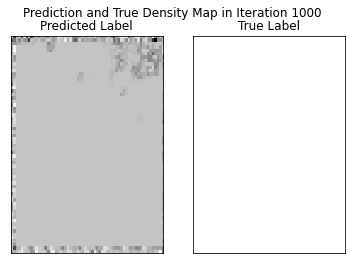

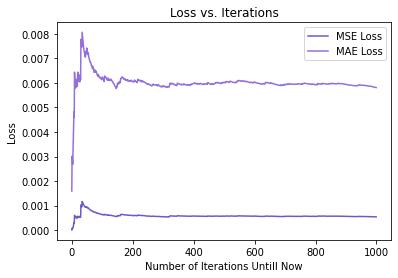



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00046
After 100 data, MAE loss is:0.00535


Train Results:
Iteration:1100 	 Loss1:0.00053
Iteration:1100 	 Loss2:0.00571


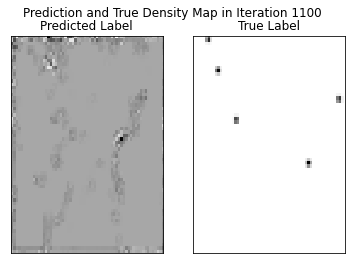

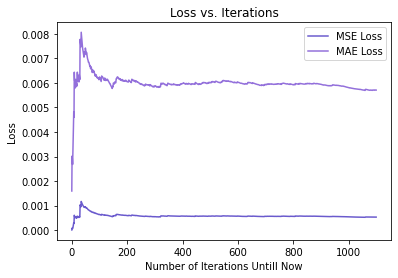



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00508


Train Results:
Iteration:1200 	 Loss1:0.00053
Iteration:1200 	 Loss2:0.00569


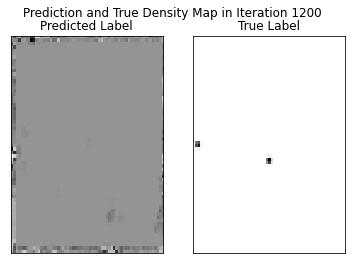

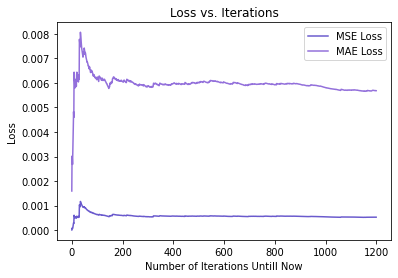



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00071
After 100 data, MAE loss is:0.00629


Train Results:
Iteration:1300 	 Loss1:0.00054
Iteration:1300 	 Loss2:0.00575


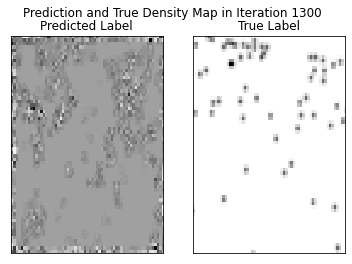

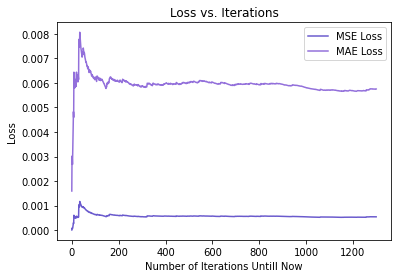



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00062
After 100 data, MAE loss is:0.00620


Train Results:
Iteration:1400 	 Loss1:0.00054
Iteration:1400 	 Loss2:0.00573


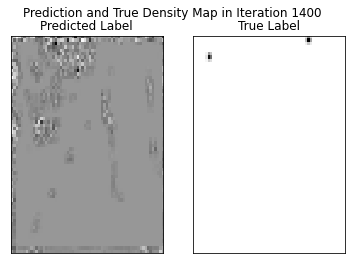

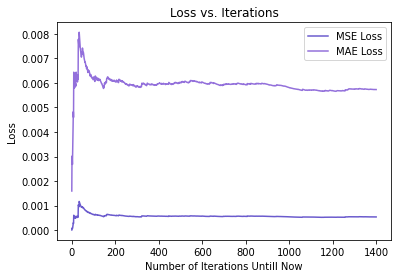



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00488


Train Results:
Iteration:1500 	 Loss1:0.00053
Iteration:1500 	 Loss2:0.00569


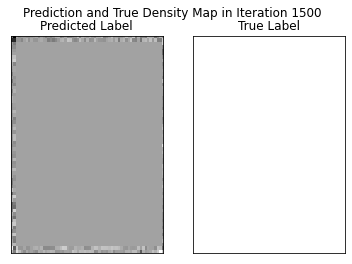

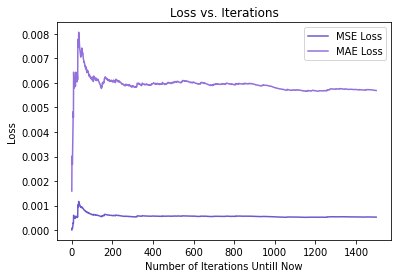



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00036
After 100 data, MAE loss is:0.00478


Train Results:
Iteration:1600 	 Loss1:0.00053
Iteration:1600 	 Loss2:0.00570


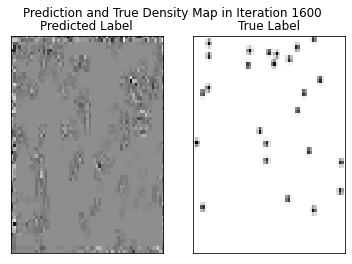

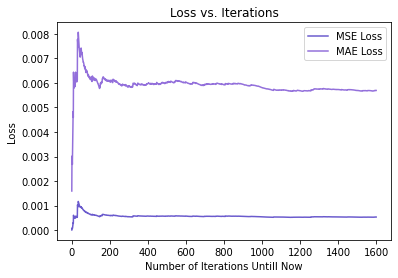



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00039
After 100 data, MAE loss is:0.00503


Train Results:
Iteration:1700 	 Loss1:0.00053
Iteration:1700 	 Loss2:0.00569


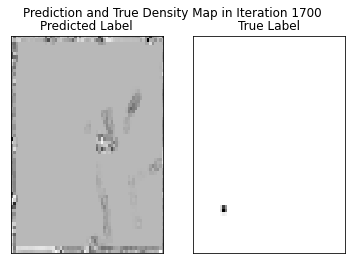

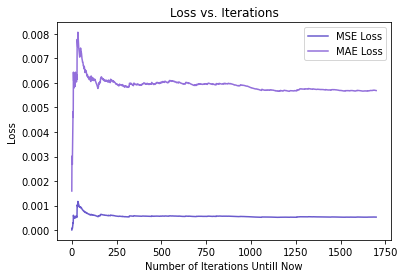



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00044
After 100 data, MAE loss is:0.00514


Train Results:
Iteration:1800 	 Loss1:0.00053
Iteration:1800 	 Loss2:0.00566


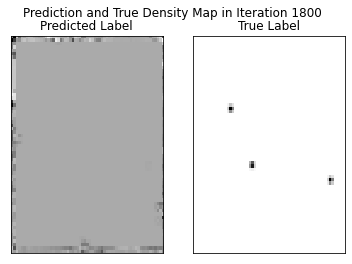

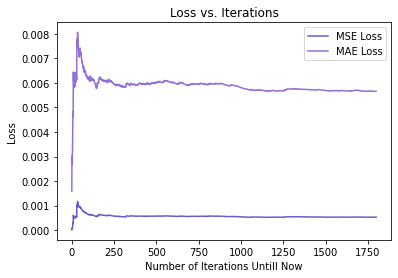



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00072
After 100 data, MAE loss is:0.00636


Train Results:
Iteration:1900 	 Loss1:0.00053
Iteration:1900 	 Loss2:0.00570


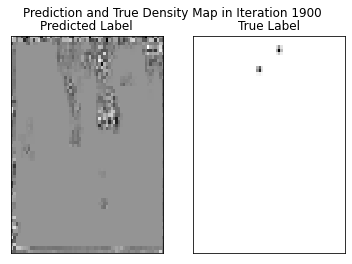

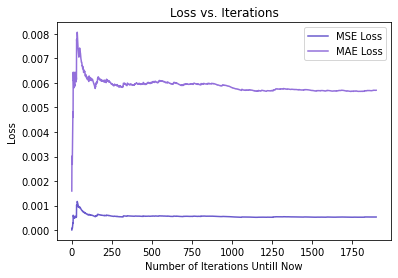



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00532


Train Results:
Iteration:2000 	 Loss1:0.00054
Iteration:2000 	 Loss2:0.00573


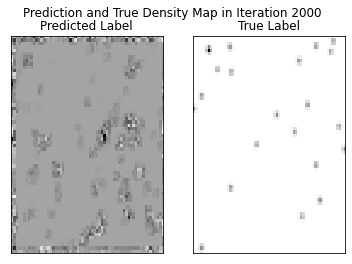

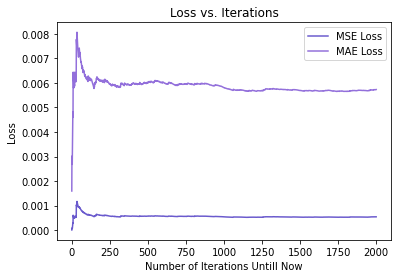



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00565


Train Results:
Iteration:2100 	 Loss1:0.00055
Iteration:2100 	 Loss2:0.00578


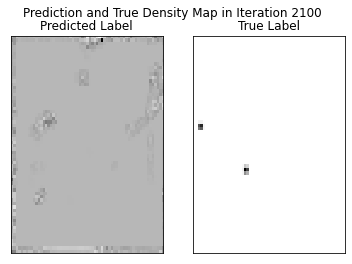

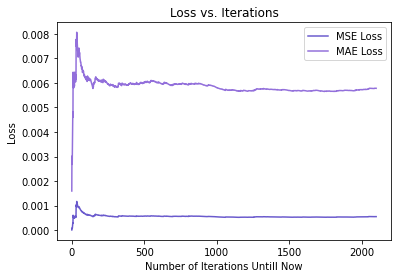



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00056
After 100 data, MAE loss is:0.00593


Train Results:
Iteration:2200 	 Loss1:0.00054
Iteration:2200 	 Loss2:0.00577


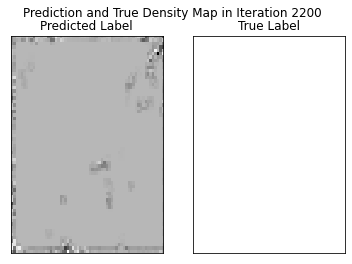

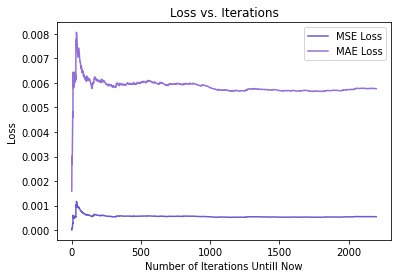



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00050
After 100 data, MAE loss is:0.00553


Train Results:
Iteration:2300 	 Loss1:0.00054
Iteration:2300 	 Loss2:0.00573


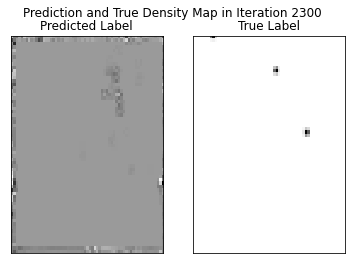

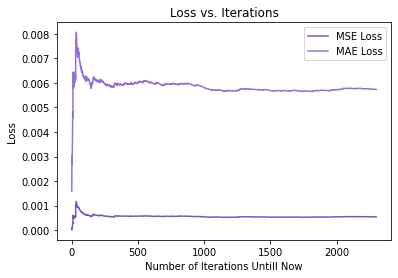



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00074
After 100 data, MAE loss is:0.00648


Train Results:
Iteration:2400 	 Loss1:0.00053
Iteration:2400 	 Loss2:0.00570


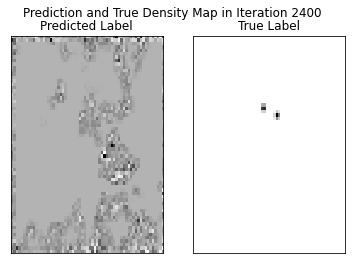

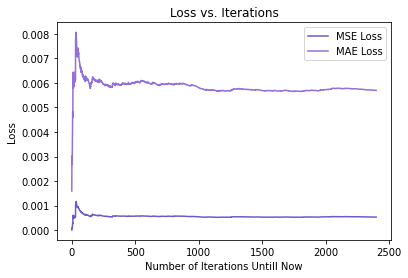



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00589


Train Results:
Iteration:2500 	 Loss1:0.00053
Iteration:2500 	 Loss2:0.00566


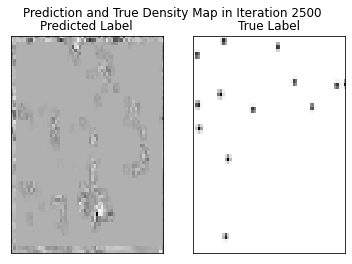

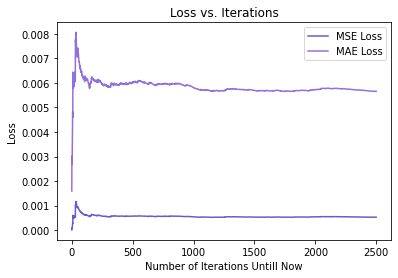



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00057
After 100 data, MAE loss is:0.00571


Train Results:
Iteration:2600 	 Loss1:0.00052
Iteration:2600 	 Loss2:0.00563


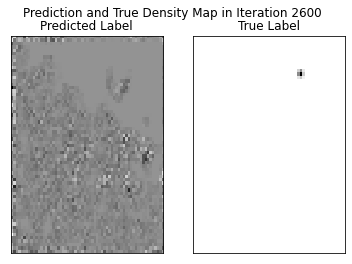

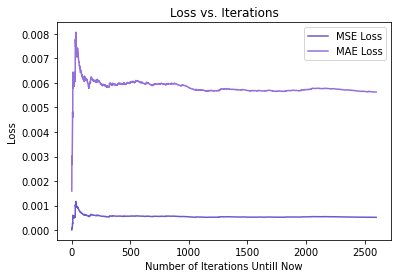



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00560


Train Results:
Iteration:2700 	 Loss1:0.00052
Iteration:2700 	 Loss2:0.00564


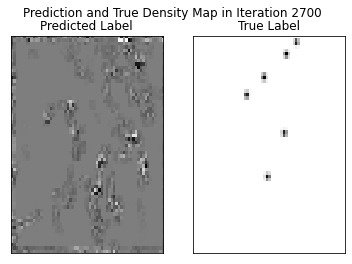

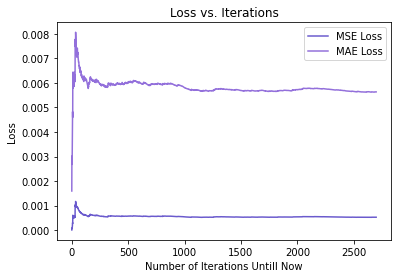



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00482


Train Results:
Iteration:2800 	 Loss1:0.00053
Iteration:2800 	 Loss2:0.00565


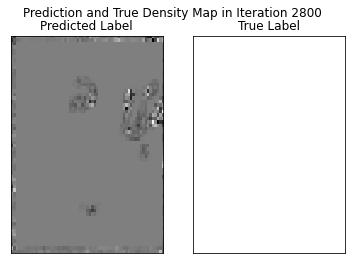

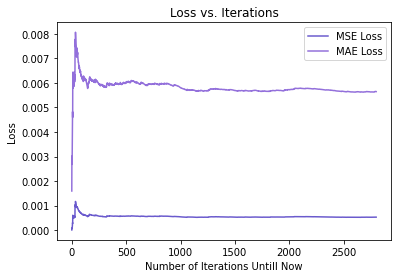



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00059
After 100 data, MAE loss is:0.00608


Train Results:
Iteration:2900 	 Loss1:0.00053
Iteration:2900 	 Loss2:0.00568


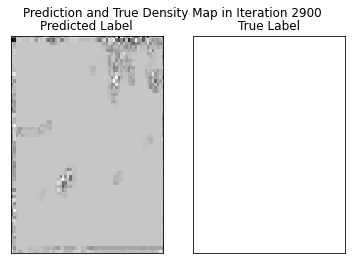

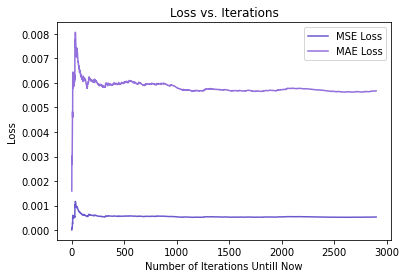



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00038
After 100 data, MAE loss is:0.00544


Train Results:
Iteration:3000 	 Loss1:0.00053
Iteration:3000 	 Loss2:0.00567


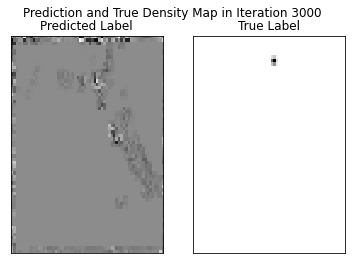

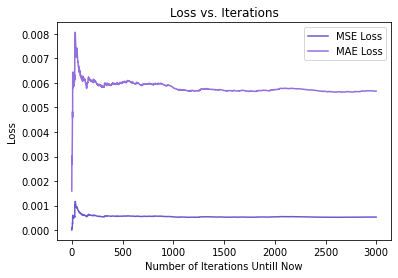



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00062
After 100 data, MAE loss is:0.00627


Train Results:
Iteration:3100 	 Loss1:0.00053
Iteration:3100 	 Loss2:0.00566


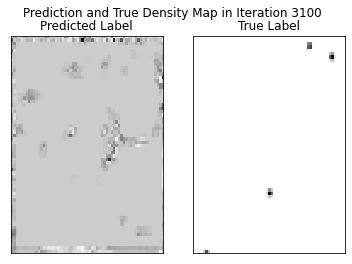

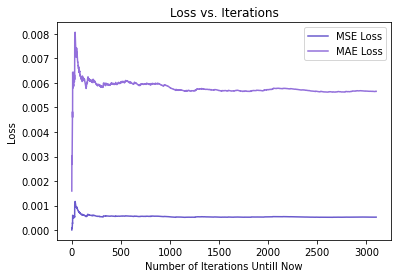



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00530


Train Results:
Iteration:3200 	 Loss1:0.00053
Iteration:3200 	 Loss2:0.00567


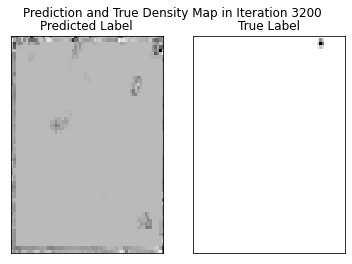

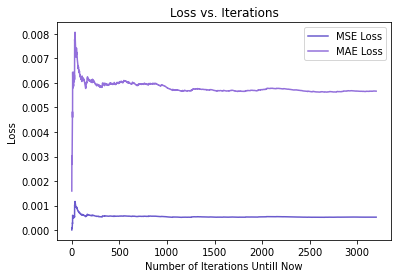



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00054
After 100 data, MAE loss is:0.00566


Train Results:
Iteration:3300 	 Loss1:0.00053
Iteration:3300 	 Loss2:0.00565


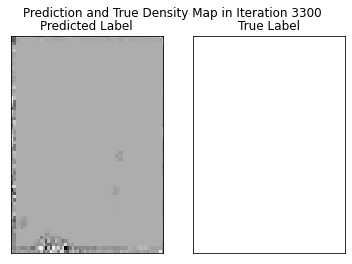

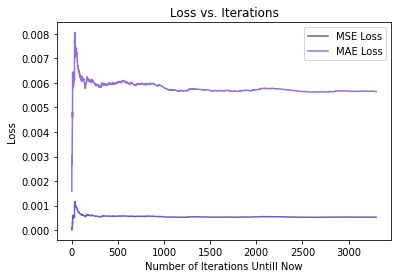



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00046
After 100 data, MAE loss is:0.00526


Train Results:
Iteration:3400 	 Loss1:0.00053
Iteration:3400 	 Loss2:0.00565


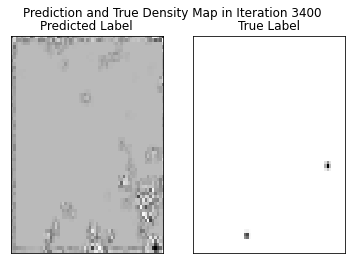

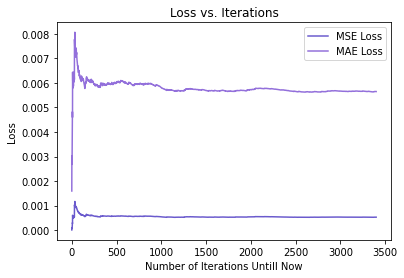



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00072
After 100 data, MAE loss is:0.00597


Train Results:
Iteration:3500 	 Loss1:0.00052
Iteration:3500 	 Loss2:0.00564


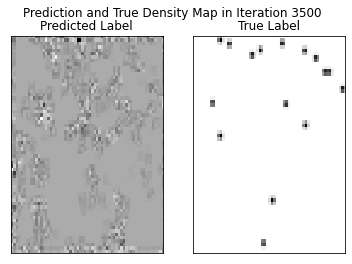

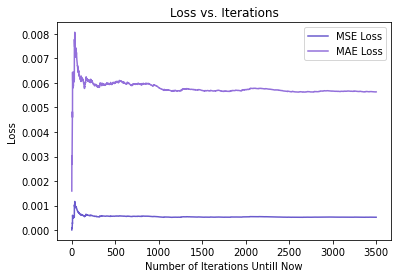



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00044
After 100 data, MAE loss is:0.00496


Train Results:
Iteration:3600 	 Loss1:0.00053
Iteration:3600 	 Loss2:0.00565


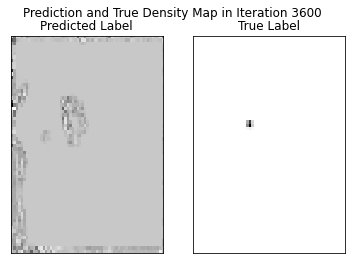

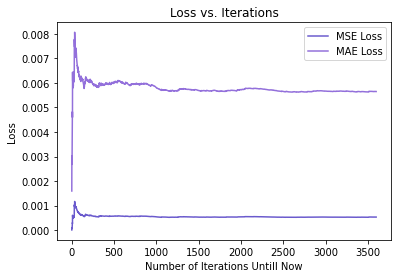



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00528


Train Results:
Iteration:3700 	 Loss1:0.00053
Iteration:3700 	 Loss2:0.00566


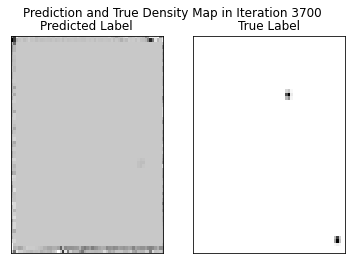

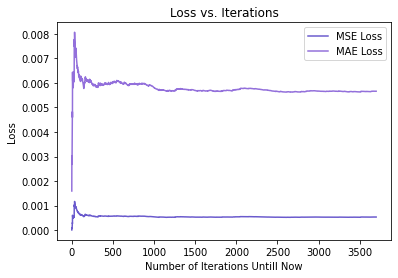



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00544


Train Results:
Iteration:3800 	 Loss1:0.00053
Iteration:3800 	 Loss2:0.00567


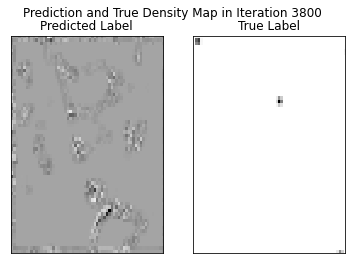

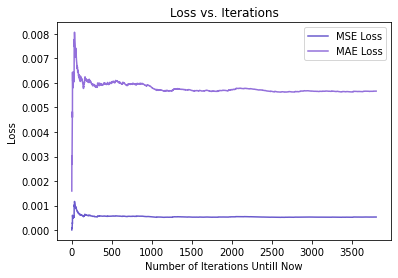



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00052
After 100 data, MAE loss is:0.00607


Train Results:
Iteration:3900 	 Loss1:0.00054
Iteration:3900 	 Loss2:0.00568


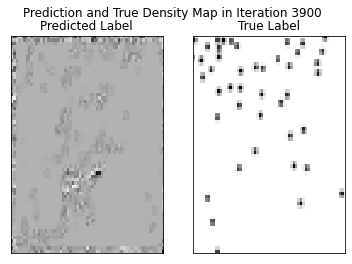

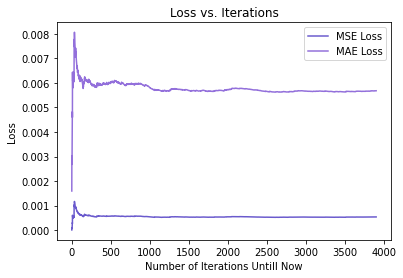



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00591


Train Results:
Iteration:4000 	 Loss1:0.00053
Iteration:4000 	 Loss2:0.00566


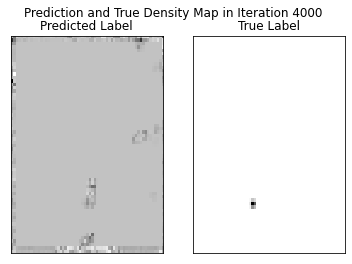

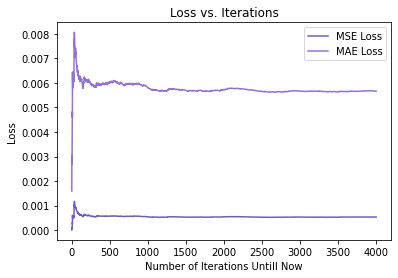



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00039
After 100 data, MAE loss is:0.00466


Train Results:
Iteration:4100 	 Loss1:0.00053
Iteration:4100 	 Loss2:0.00564


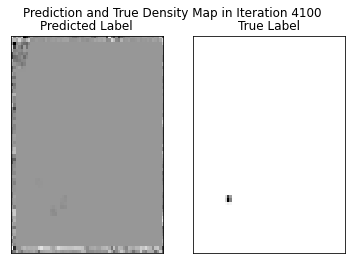

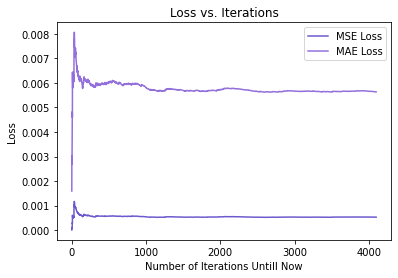



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00042
After 100 data, MAE loss is:0.00483


Train Results:
Iteration:4200 	 Loss1:0.00052
Iteration:4200 	 Loss2:0.00563


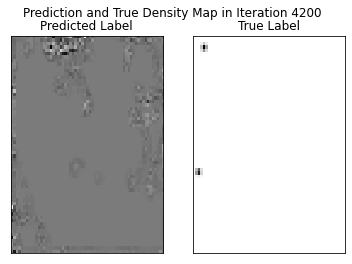

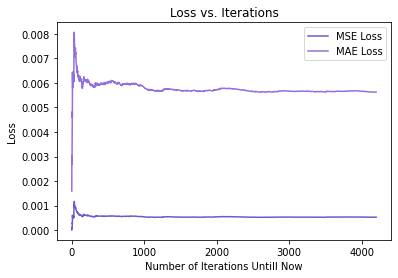



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00491


Train Results:
Iteration:4300 	 Loss1:0.00052
Iteration:4300 	 Loss2:0.00560


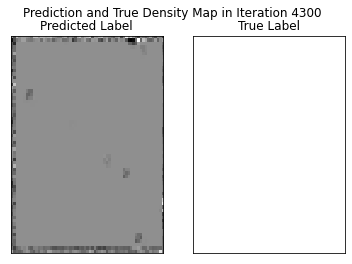

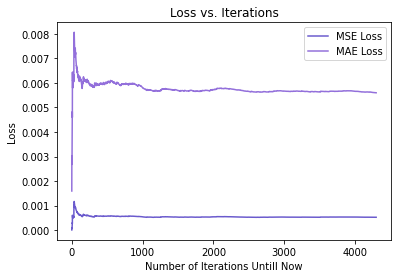



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00063
After 100 data, MAE loss is:0.00566


Train Results:
Iteration:4400 	 Loss1:0.00053
Iteration:4400 	 Loss2:0.00563


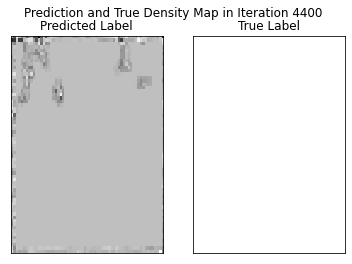

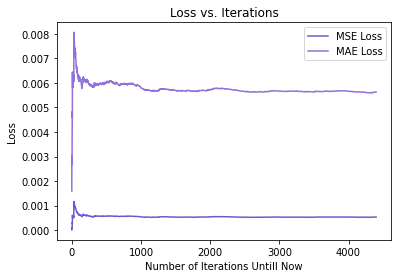



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00538


Train Results:
Iteration:4500 	 Loss1:0.00053
Iteration:4500 	 Loss2:0.00563


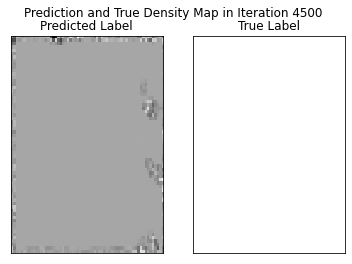

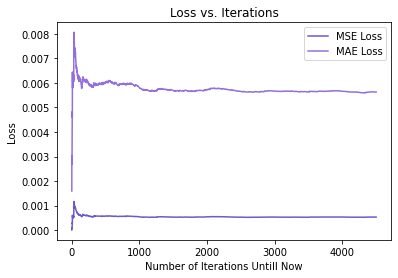



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00034
After 100 data, MAE loss is:0.00473


Train Results:
Iteration:4600 	 Loss1:0.00053
Iteration:4600 	 Loss2:0.00561


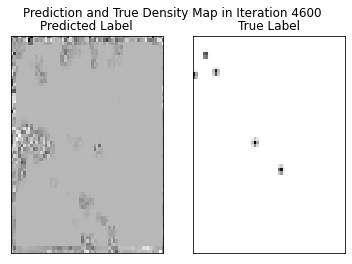

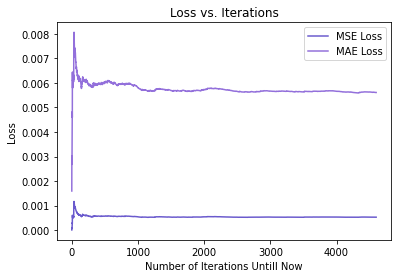



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00047
After 100 data, MAE loss is:0.00522


Train Results:
Iteration:4700 	 Loss1:0.00052
Iteration:4700 	 Loss2:0.00560


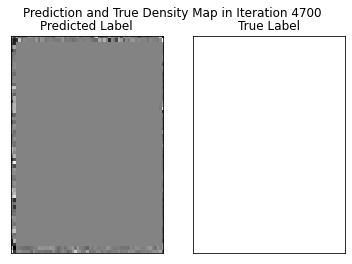

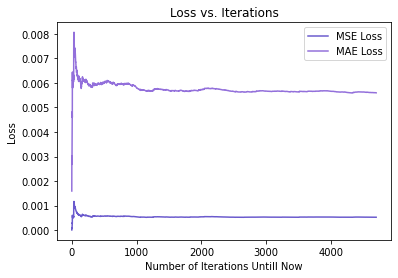



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00063
After 100 data, MAE loss is:0.00592


Train Results:
Iteration:4800 	 Loss1:0.00052
Iteration:4800 	 Loss2:0.00560


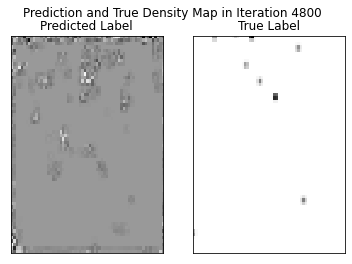

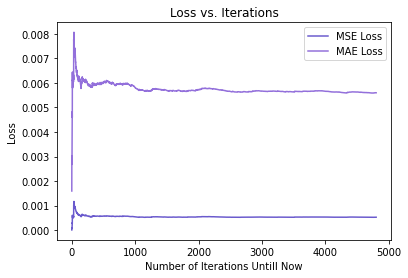



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00545


At the end of epoch 3 the average train loss of MSE is: 0.00052
At the end of epoch 3 the average train loss of MAE is: 0.00560
Epoch 4 has started......
Training the network......
Train Results:
Iteration:100 	 Loss1:0.00056
Iteration:100 	 Loss2:0.00590


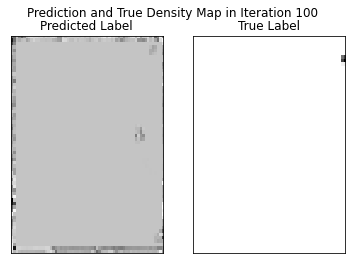

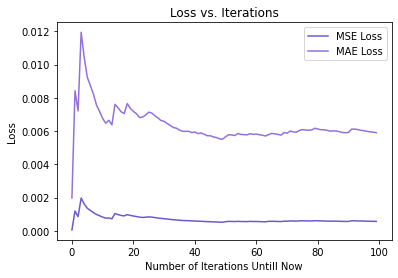



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00090
After 100 data, MAE loss is:0.00657


Train Results:
Iteration:200 	 Loss1:0.00053
Iteration:200 	 Loss2:0.00561


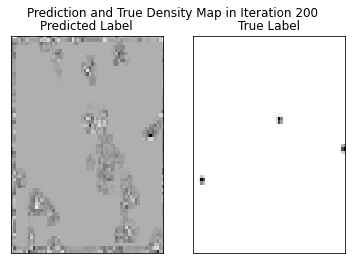

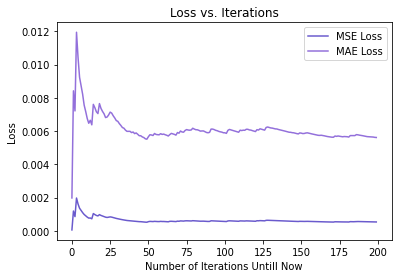



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00065
After 100 data, MAE loss is:0.00589


Train Results:
Iteration:300 	 Loss1:0.00050
Iteration:300 	 Loss2:0.00550


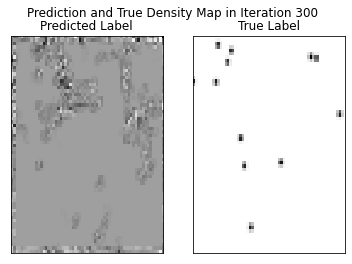

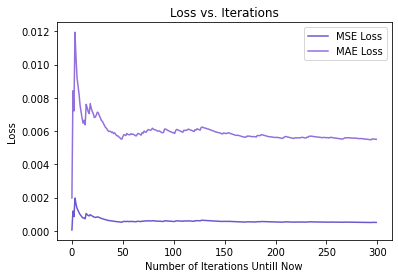



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00037
After 100 data, MAE loss is:0.00472


Train Results:
Iteration:400 	 Loss1:0.00050
Iteration:400 	 Loss2:0.00547


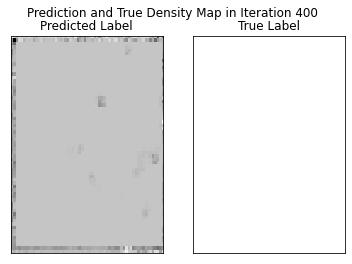

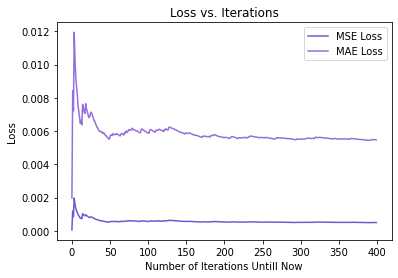



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00072
After 100 data, MAE loss is:0.00618


Train Results:
Iteration:500 	 Loss1:0.00049
Iteration:500 	 Loss2:0.00544


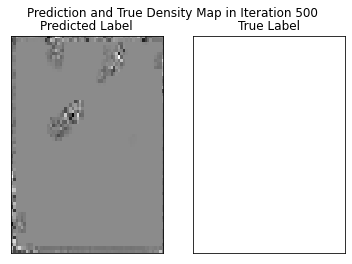

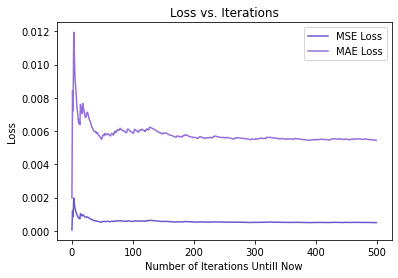



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00516


Train Results:
Iteration:600 	 Loss1:0.00048
Iteration:600 	 Loss2:0.00537


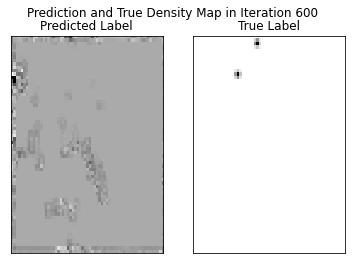

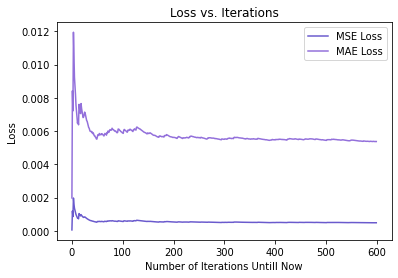



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00065
After 100 data, MAE loss is:0.00593


Train Results:
Iteration:700 	 Loss1:0.00048
Iteration:700 	 Loss2:0.00536


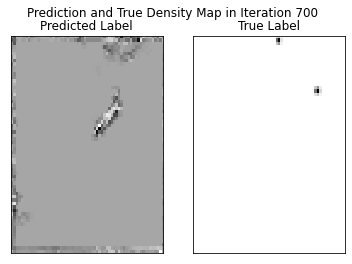

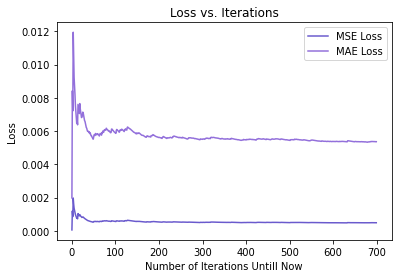



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00512


Train Results:
Iteration:800 	 Loss1:0.00050
Iteration:800 	 Loss2:0.00542


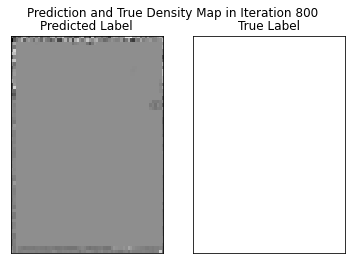

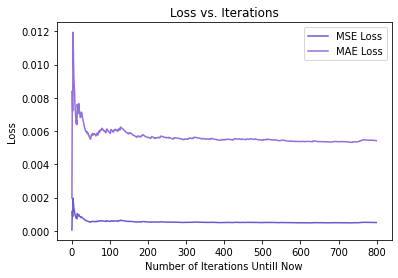



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00541


Train Results:
Iteration:900 	 Loss1:0.00049
Iteration:900 	 Loss2:0.00541


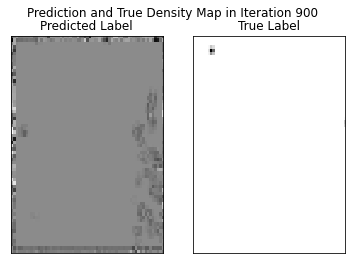

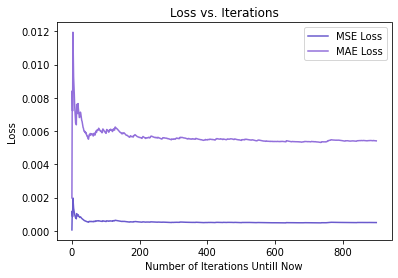



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00551


Train Results:
Iteration:1000 	 Loss1:0.00050
Iteration:1000 	 Loss2:0.00541


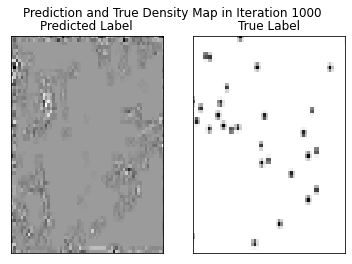

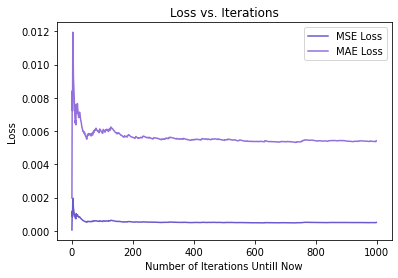



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00052
After 100 data, MAE loss is:0.00562


Train Results:
Iteration:1100 	 Loss1:0.00049
Iteration:1100 	 Loss2:0.00535


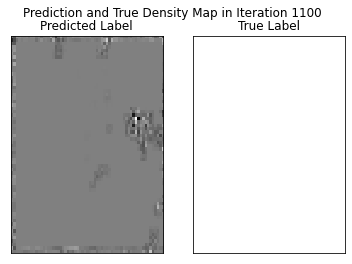

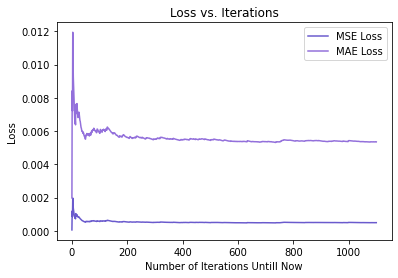



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00068
After 100 data, MAE loss is:0.00615


Train Results:
Iteration:1200 	 Loss1:0.00050
Iteration:1200 	 Loss2:0.00539


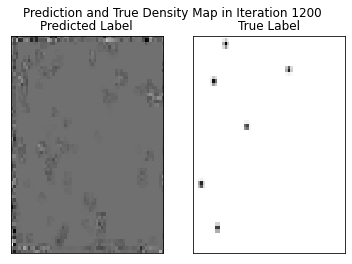

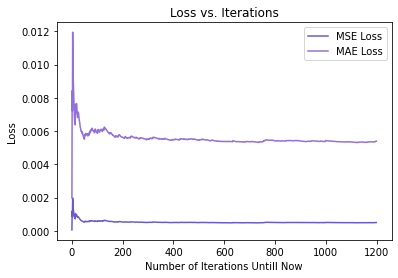



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00602


Train Results:
Iteration:1300 	 Loss1:0.00051
Iteration:1300 	 Loss2:0.00547


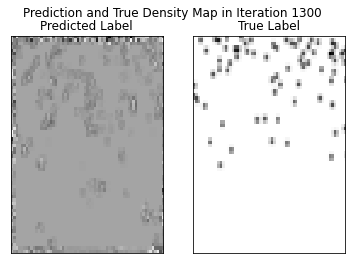

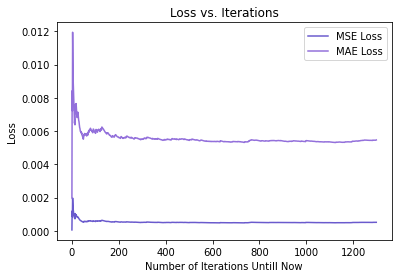



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00049
After 100 data, MAE loss is:0.00542


Train Results:
Iteration:1400 	 Loss1:0.00051
Iteration:1400 	 Loss2:0.00549


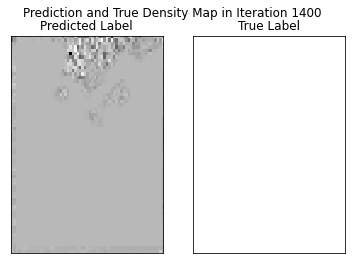

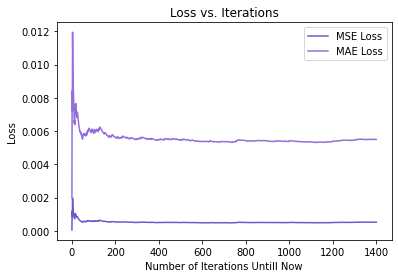



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00041
After 100 data, MAE loss is:0.00527


Train Results:
Iteration:1500 	 Loss1:0.00052
Iteration:1500 	 Loss2:0.00551


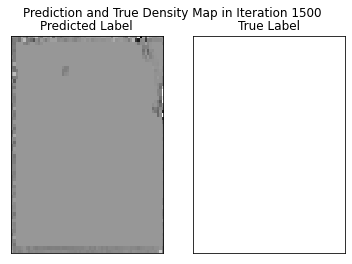

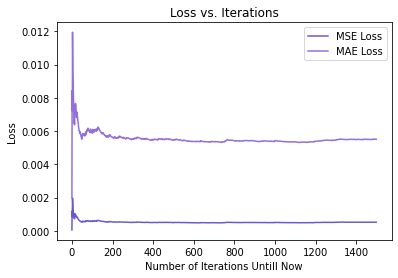



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00591


Train Results:
Iteration:1600 	 Loss1:0.00054
Iteration:1600 	 Loss2:0.00558


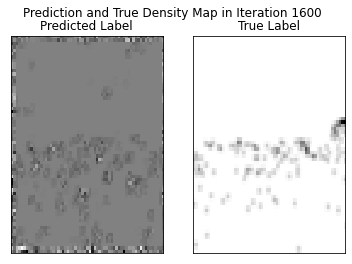

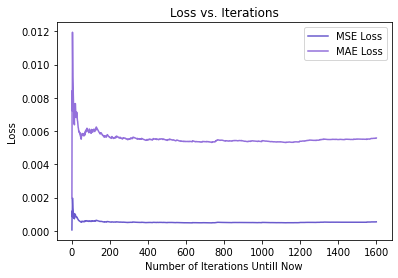



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00044
After 100 data, MAE loss is:0.00553


Train Results:
Iteration:1700 	 Loss1:0.00053
Iteration:1700 	 Loss2:0.00558


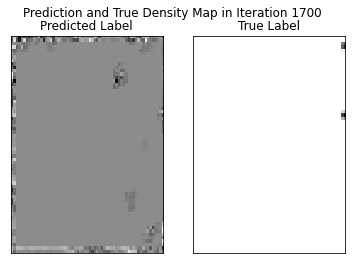

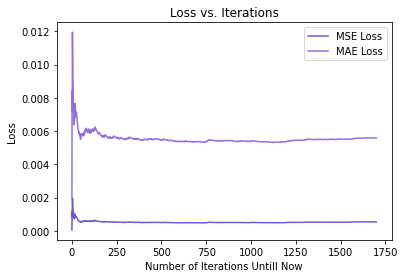



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00036
After 100 data, MAE loss is:0.00499


Train Results:
Iteration:1800 	 Loss1:0.00053
Iteration:1800 	 Loss2:0.00555


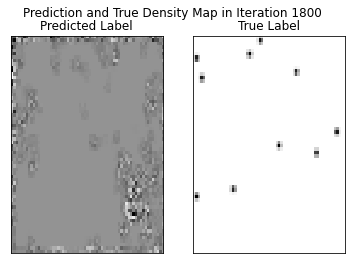

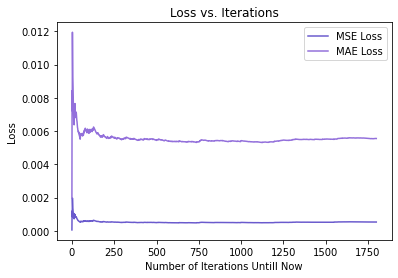



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00037
After 100 data, MAE loss is:0.00476


Train Results:
Iteration:1900 	 Loss1:0.00052
Iteration:1900 	 Loss2:0.00557


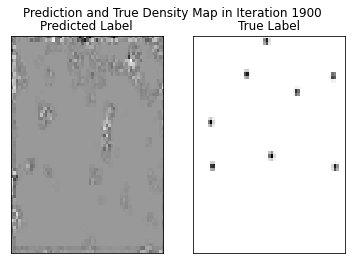

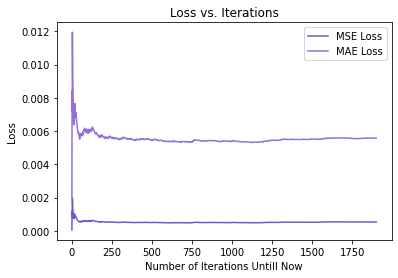



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00054
After 100 data, MAE loss is:0.00538


Train Results:
Iteration:2000 	 Loss1:0.00053
Iteration:2000 	 Loss2:0.00561


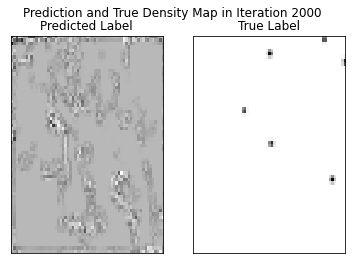

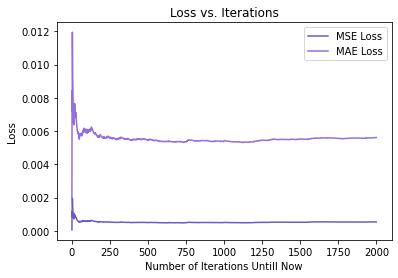



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00605


Train Results:
Iteration:2100 	 Loss1:0.00053
Iteration:2100 	 Loss2:0.00562


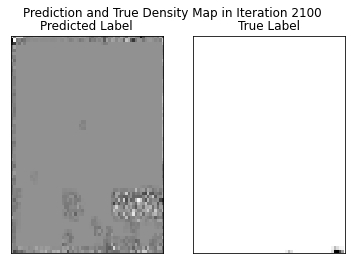

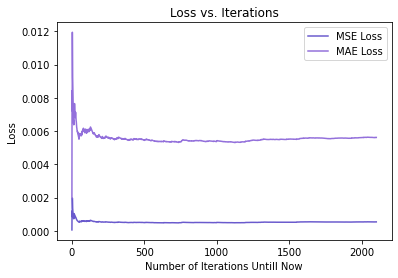



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00050
After 100 data, MAE loss is:0.00571


Train Results:
Iteration:2200 	 Loss1:0.00054
Iteration:2200 	 Loss2:0.00564


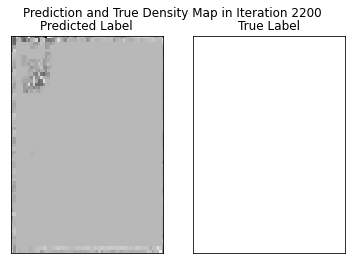

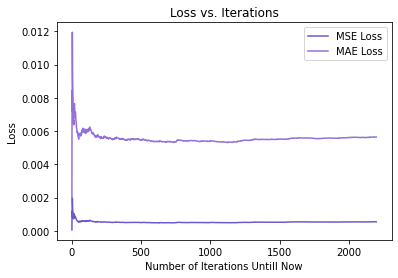



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00041
After 100 data, MAE loss is:0.00518


Train Results:
Iteration:2300 	 Loss1:0.00054
Iteration:2300 	 Loss2:0.00563


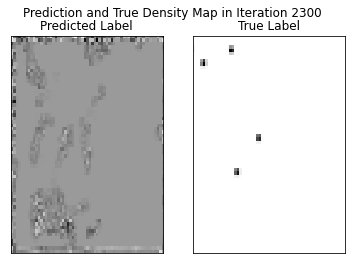

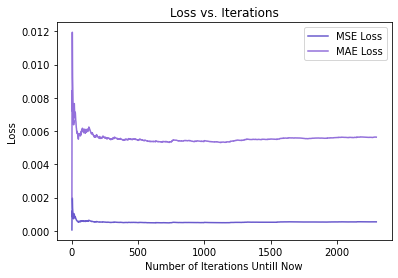



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00568


Train Results:
Iteration:2400 	 Loss1:0.00053
Iteration:2400 	 Loss2:0.00563


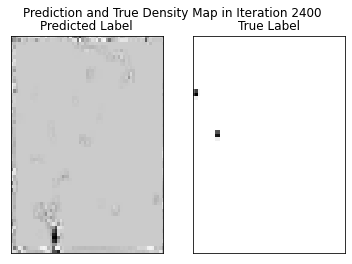

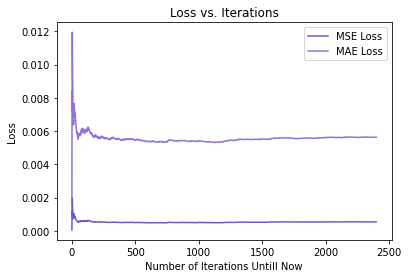



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00524


Train Results:
Iteration:2500 	 Loss1:0.00053
Iteration:2500 	 Loss2:0.00563


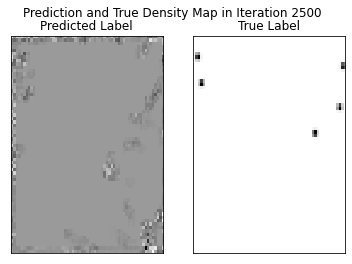

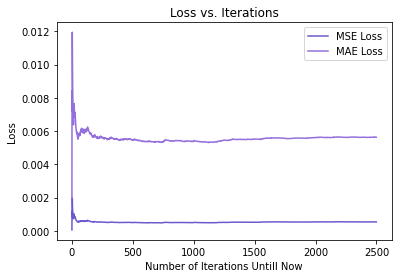



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00546


Train Results:
Iteration:2600 	 Loss1:0.00053
Iteration:2600 	 Loss2:0.00561


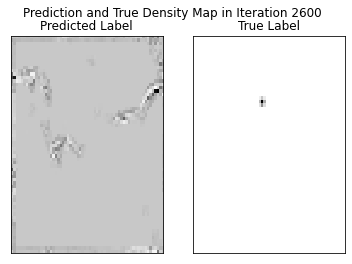

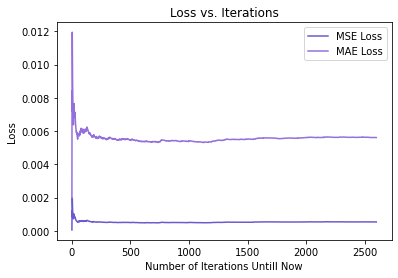



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00047
After 100 data, MAE loss is:0.00547


Train Results:
Iteration:2700 	 Loss1:0.00052
Iteration:2700 	 Loss2:0.00557


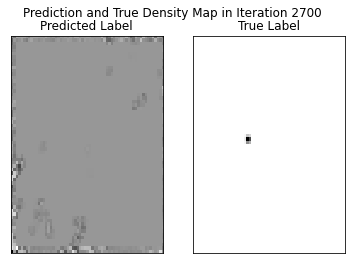

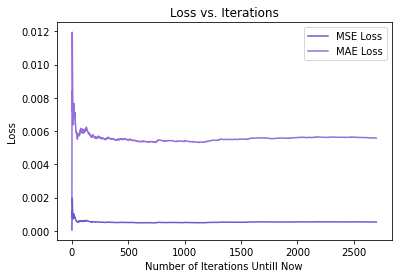



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00037
After 100 data, MAE loss is:0.00469


Train Results:
Iteration:2800 	 Loss1:0.00053
Iteration:2800 	 Loss2:0.00557


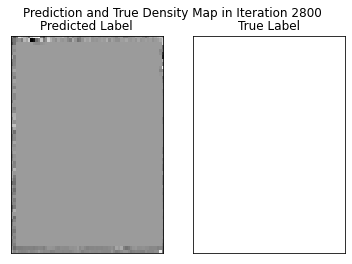

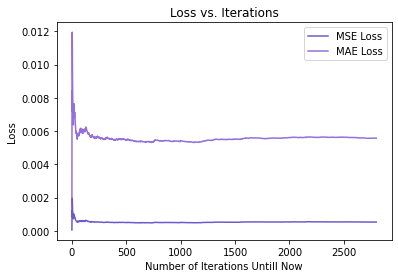



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00049
After 100 data, MAE loss is:0.00508


Train Results:
Iteration:2900 	 Loss1:0.00053
Iteration:2900 	 Loss2:0.00557


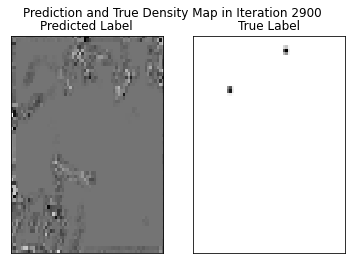

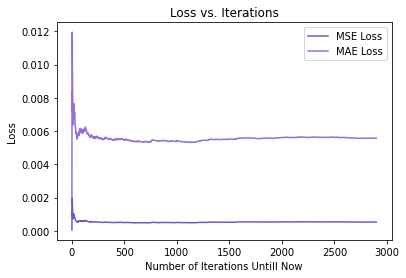



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00033
After 100 data, MAE loss is:0.00461


Train Results:
Iteration:3000 	 Loss1:0.00052
Iteration:3000 	 Loss2:0.00555


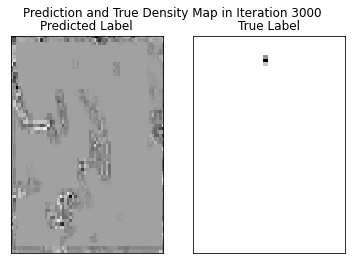

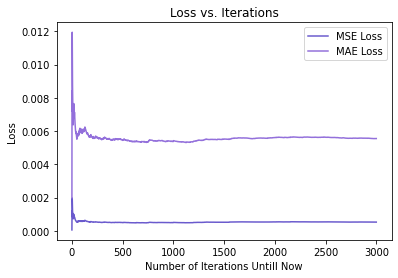



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00594


Train Results:
Iteration:3100 	 Loss1:0.00052
Iteration:3100 	 Loss2:0.00552


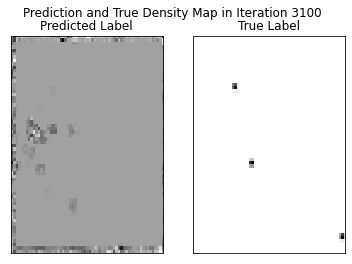

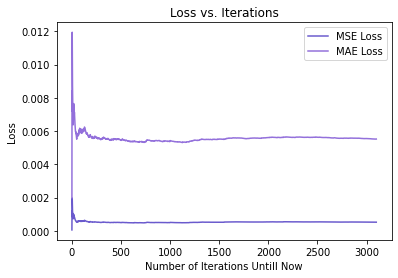



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00046
After 100 data, MAE loss is:0.00501


Train Results:
Iteration:3200 	 Loss1:0.00052
Iteration:3200 	 Loss2:0.00551


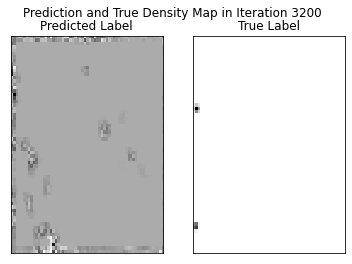

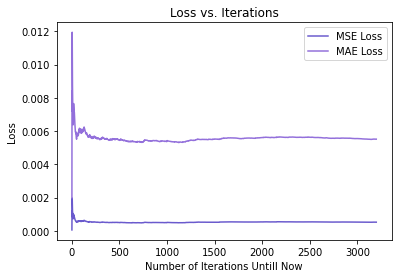



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00058
After 100 data, MAE loss is:0.00571


Train Results:
Iteration:3300 	 Loss1:0.00052
Iteration:3300 	 Loss2:0.00550


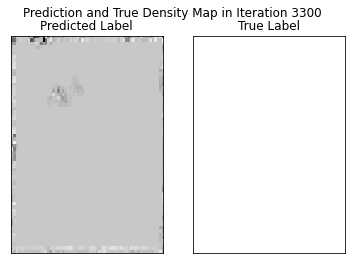

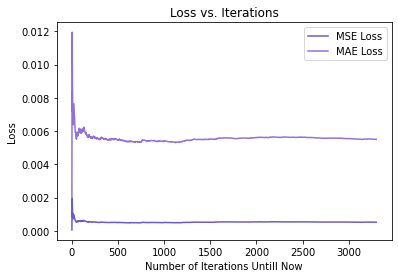



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00616


Train Results:
Iteration:3400 	 Loss1:0.00052
Iteration:3400 	 Loss2:0.00550


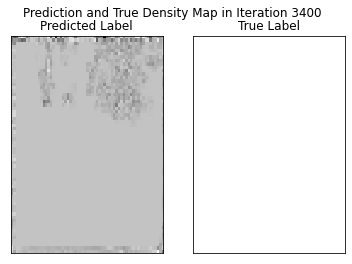

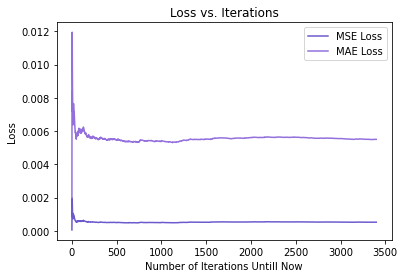



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00083
After 100 data, MAE loss is:0.00639


Train Results:
Iteration:3500 	 Loss1:0.00051
Iteration:3500 	 Loss2:0.00548


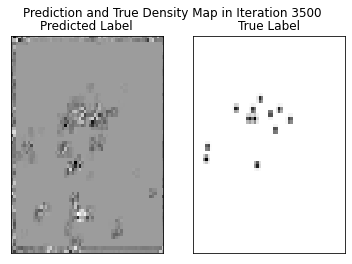

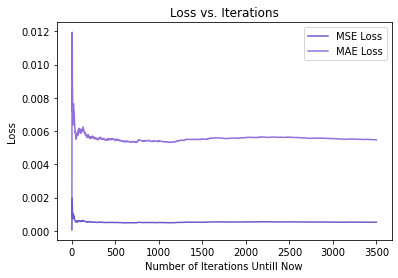



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00077
After 100 data, MAE loss is:0.00643


Train Results:
Iteration:3600 	 Loss1:0.00052
Iteration:3600 	 Loss2:0.00549


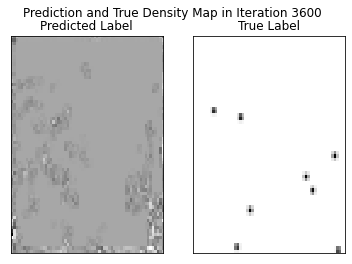

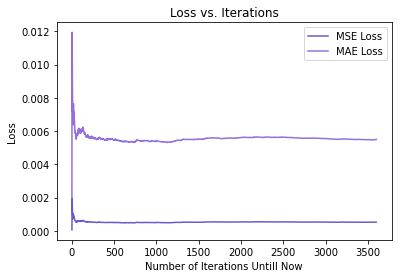



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00057
After 100 data, MAE loss is:0.00589


Train Results:
Iteration:3700 	 Loss1:0.00052
Iteration:3700 	 Loss2:0.00550


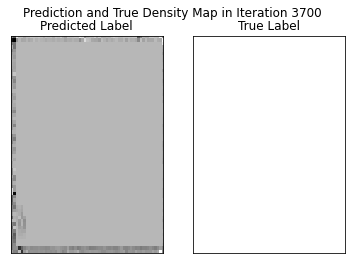

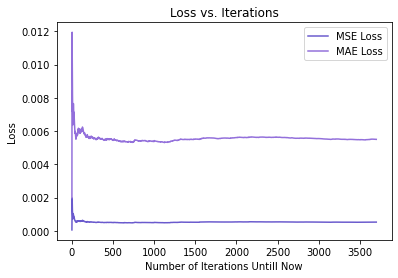



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00039
After 100 data, MAE loss is:0.00502


Train Results:
Iteration:3800 	 Loss1:0.00052
Iteration:3800 	 Loss2:0.00551


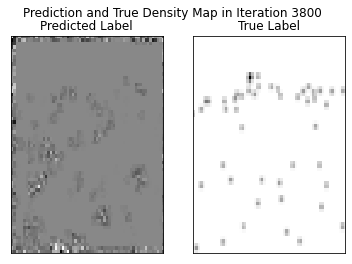

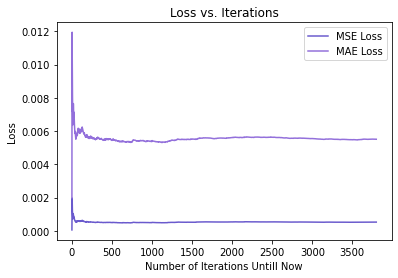



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00081
After 100 data, MAE loss is:0.00670


Train Results:
Iteration:3900 	 Loss1:0.00052
Iteration:3900 	 Loss2:0.00550


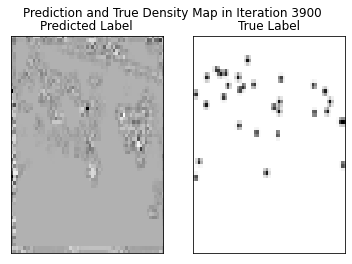

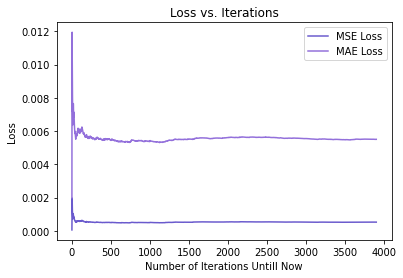



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00603


Train Results:
Iteration:4000 	 Loss1:0.00051
Iteration:4000 	 Loss2:0.00546


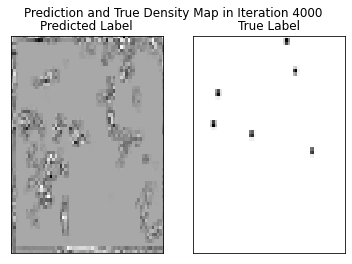

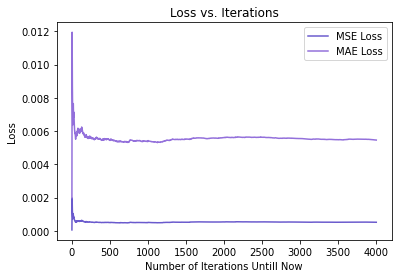



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00548


Train Results:
Iteration:4100 	 Loss1:0.00051
Iteration:4100 	 Loss2:0.00546


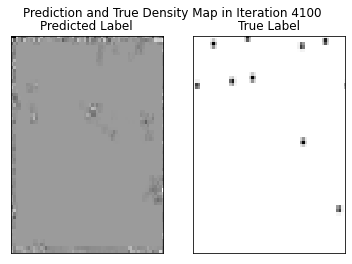

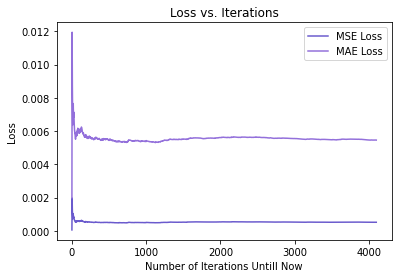



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00064
After 100 data, MAE loss is:0.00589


Train Results:
Iteration:4200 	 Loss1:0.00051
Iteration:4200 	 Loss2:0.00545


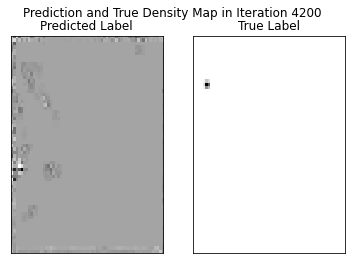

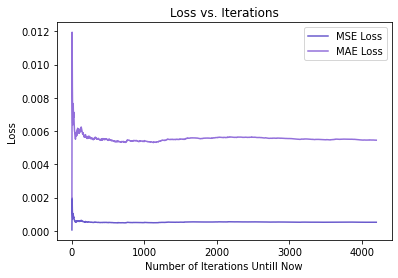



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00531


Train Results:
Iteration:4300 	 Loss1:0.00051
Iteration:4300 	 Loss2:0.00544


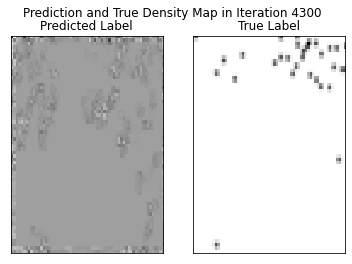

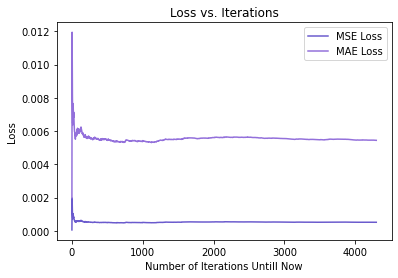



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00492


Train Results:
Iteration:4400 	 Loss1:0.00052
Iteration:4400 	 Loss2:0.00546


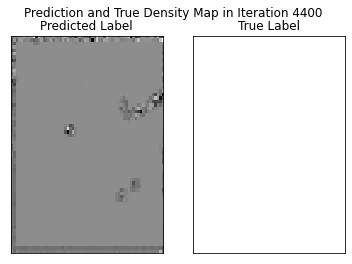

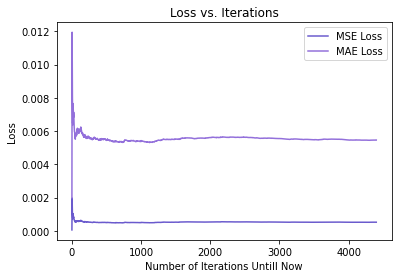



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00059
After 100 data, MAE loss is:0.00574


Train Results:
Iteration:4500 	 Loss1:0.00051
Iteration:4500 	 Loss2:0.00543


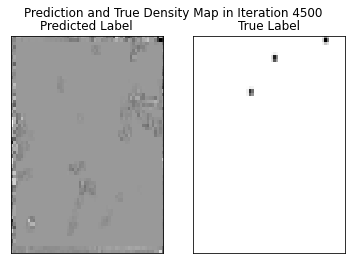

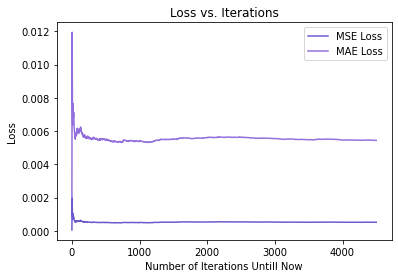



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00517


Train Results:
Iteration:4600 	 Loss1:0.00051
Iteration:4600 	 Loss2:0.00544


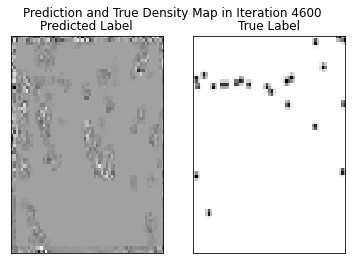

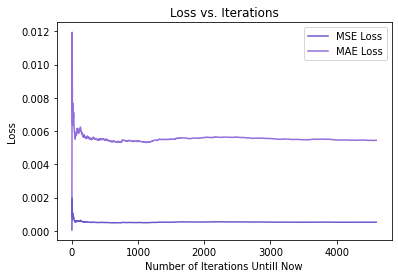



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00038
After 100 data, MAE loss is:0.00459


Train Results:
Iteration:4700 	 Loss1:0.00052
Iteration:4700 	 Loss2:0.00548


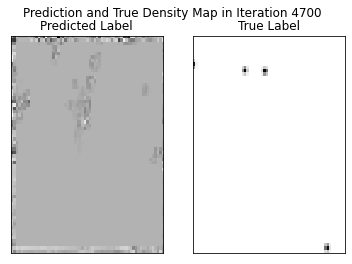

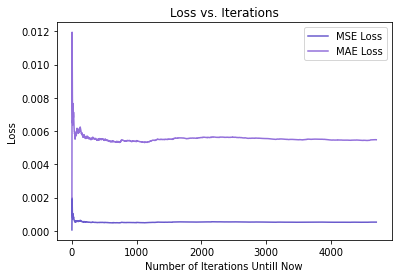



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00078
After 100 data, MAE loss is:0.00677


Train Results:
Iteration:4800 	 Loss1:0.00052
Iteration:4800 	 Loss2:0.00547


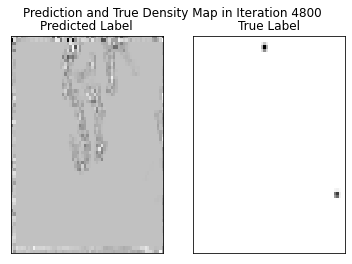

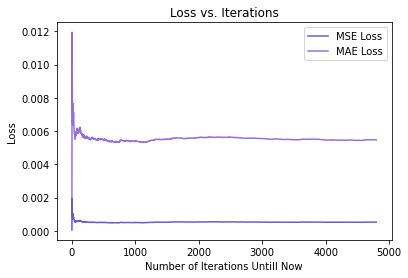



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00553


At the end of epoch 4 the average train loss of MSE is: 0.00052
At the end of epoch 4 the average train loss of MAE is: 0.00547
Epoch 5 has started......
Training the network......
Train Results:
Iteration:100 	 Loss1:0.00045
Iteration:100 	 Loss2:0.00519


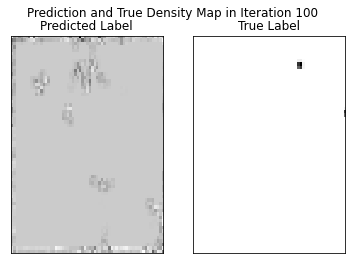

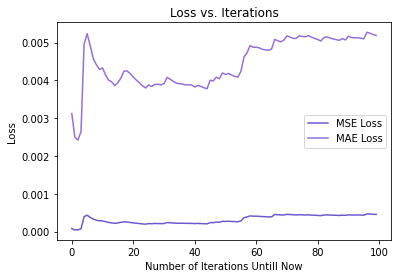



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00045
After 100 data, MAE loss is:0.00520


Train Results:
Iteration:200 	 Loss1:0.00044
Iteration:200 	 Loss2:0.00510


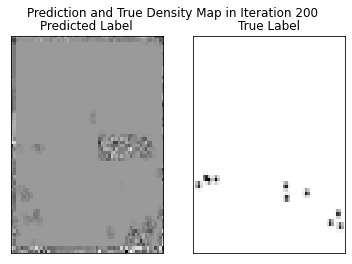

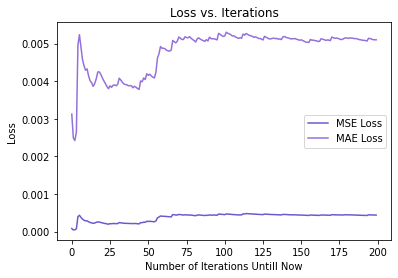



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00063
After 100 data, MAE loss is:0.00575


Train Results:
Iteration:300 	 Loss1:0.00044
Iteration:300 	 Loss2:0.00506


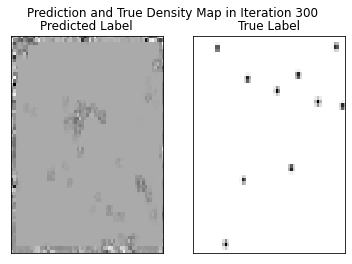

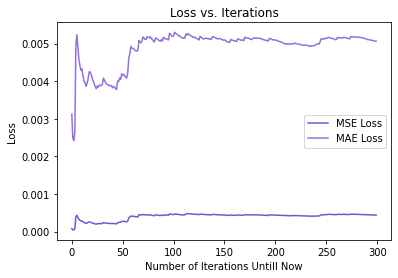



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00044
After 100 data, MAE loss is:0.00509


Train Results:
Iteration:400 	 Loss1:0.00045
Iteration:400 	 Loss2:0.00502


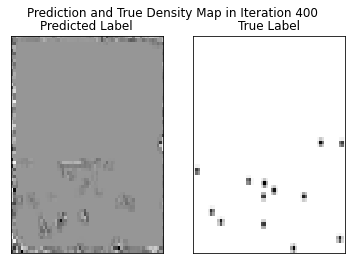

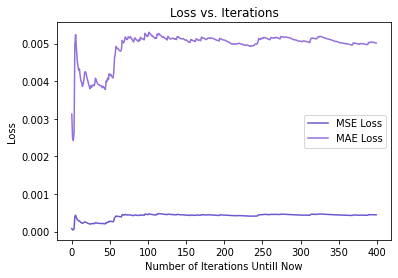



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00496


Train Results:
Iteration:500 	 Loss1:0.00047
Iteration:500 	 Loss2:0.00514


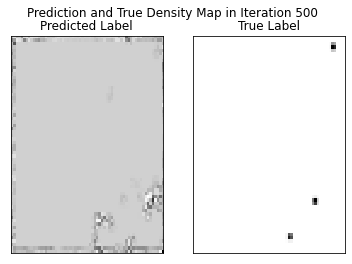

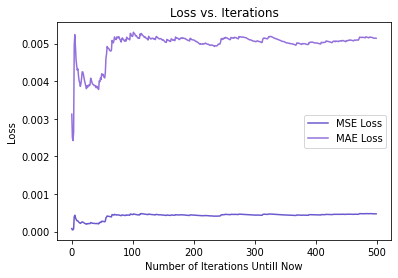



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00028
After 100 data, MAE loss is:0.00431


Train Results:
Iteration:600 	 Loss1:0.00048
Iteration:600 	 Loss2:0.00522


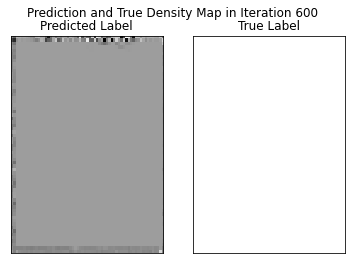

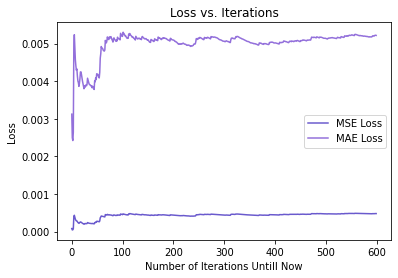



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00070
After 100 data, MAE loss is:0.00584


Train Results:
Iteration:700 	 Loss1:0.00047
Iteration:700 	 Loss2:0.00517


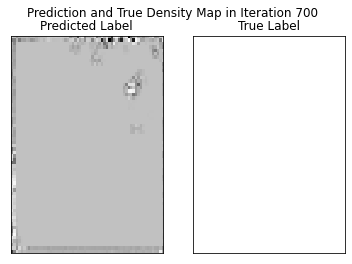

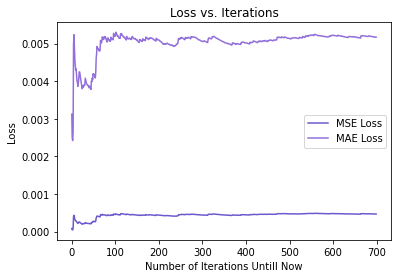



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00537


Train Results:
Iteration:800 	 Loss1:0.00050
Iteration:800 	 Loss2:0.00531


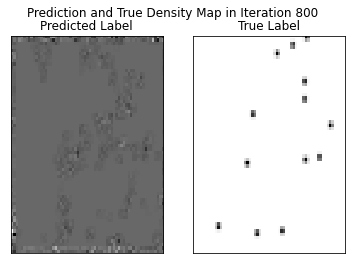

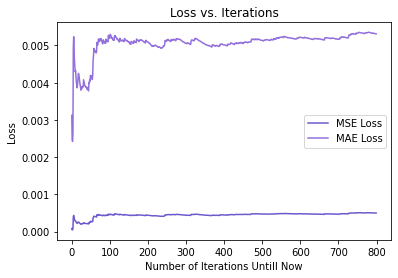



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00539


Train Results:
Iteration:900 	 Loss1:0.00049
Iteration:900 	 Loss2:0.00528


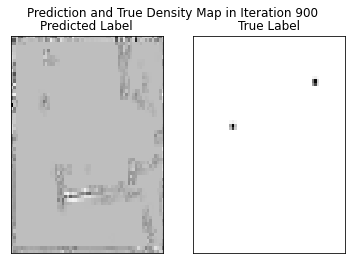

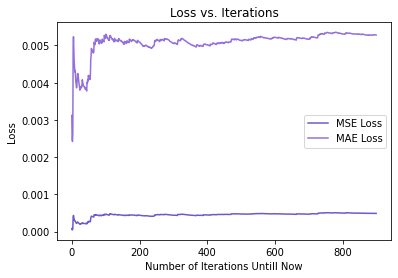



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00534


Train Results:
Iteration:1000 	 Loss1:0.00049
Iteration:1000 	 Loss2:0.00529


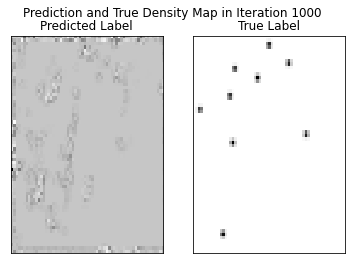

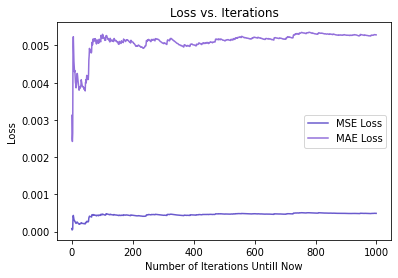



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00047
After 100 data, MAE loss is:0.00516


Train Results:
Iteration:1100 	 Loss1:0.00048
Iteration:1100 	 Loss2:0.00526


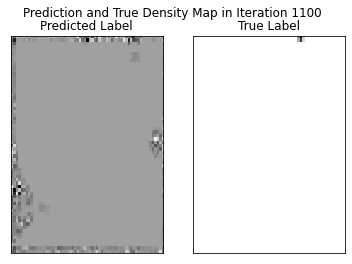

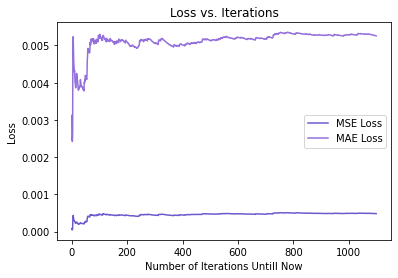



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00059
After 100 data, MAE loss is:0.00548


Train Results:
Iteration:1200 	 Loss1:0.00050
Iteration:1200 	 Loss2:0.00532


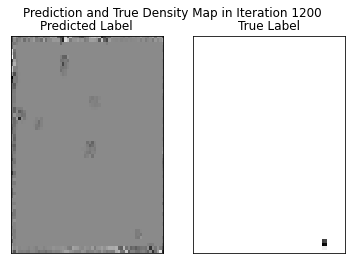

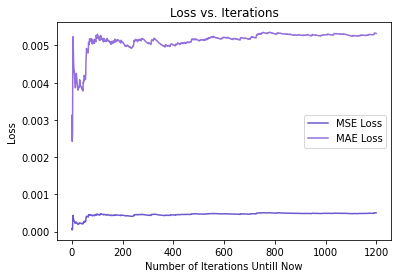



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00539


Train Results:
Iteration:1300 	 Loss1:0.00051
Iteration:1300 	 Loss2:0.00538


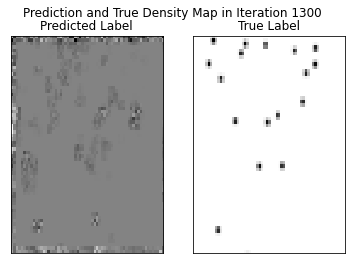

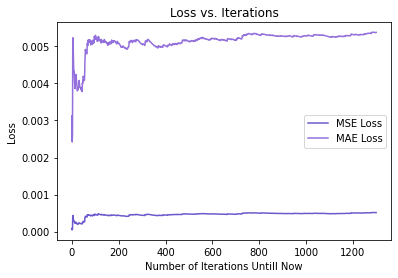



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00082
After 100 data, MAE loss is:0.00652


Train Results:
Iteration:1400 	 Loss1:0.00052
Iteration:1400 	 Loss2:0.00540


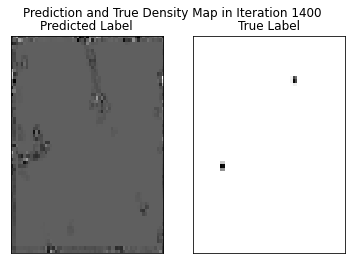

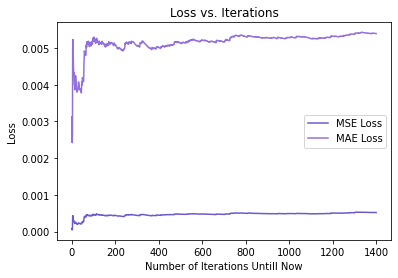



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00044
After 100 data, MAE loss is:0.00511


Train Results:
Iteration:1500 	 Loss1:0.00051
Iteration:1500 	 Loss2:0.00539


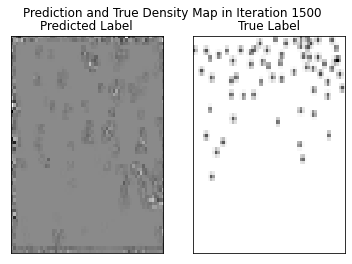

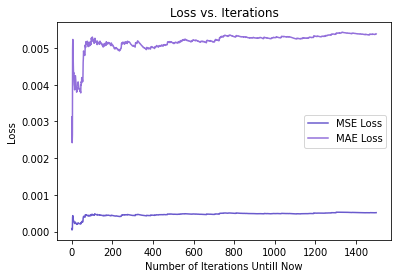



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00038
After 100 data, MAE loss is:0.00495


Train Results:
Iteration:1600 	 Loss1:0.00052
Iteration:1600 	 Loss2:0.00541


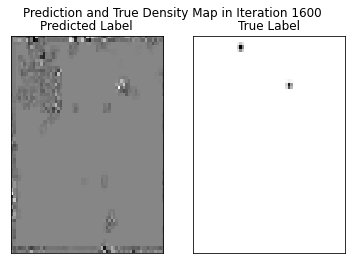

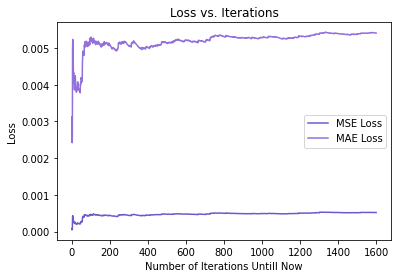



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00067
After 100 data, MAE loss is:0.00582


Train Results:
Iteration:1700 	 Loss1:0.00052
Iteration:1700 	 Loss2:0.00543


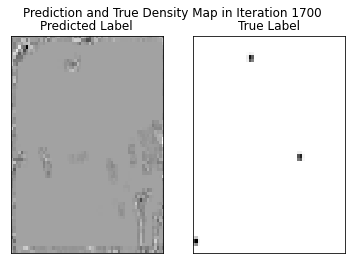

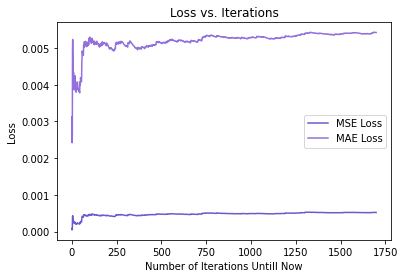



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00051
After 100 data, MAE loss is:0.00567


Train Results:
Iteration:1800 	 Loss1:0.00053
Iteration:1800 	 Loss2:0.00547


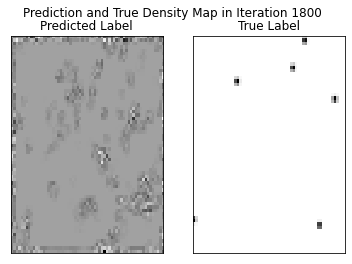

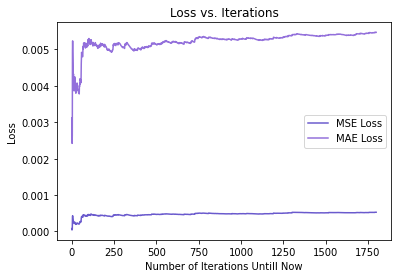



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00564


Train Results:
Iteration:1900 	 Loss1:0.00053
Iteration:1900 	 Loss2:0.00547


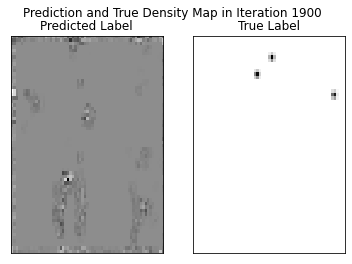

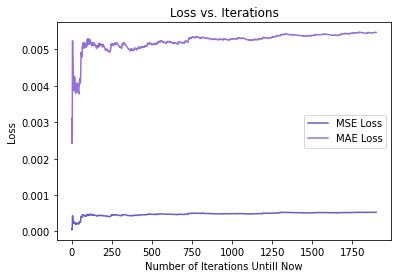



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00060
After 100 data, MAE loss is:0.00613


Train Results:
Iteration:2000 	 Loss1:0.00053
Iteration:2000 	 Loss2:0.00548


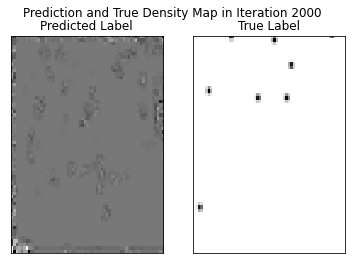

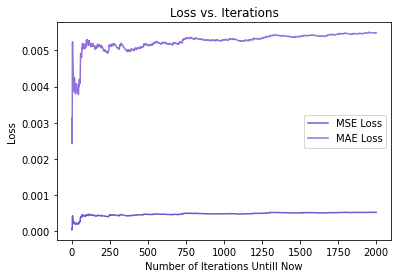



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00034
After 100 data, MAE loss is:0.00464


Train Results:
Iteration:2100 	 Loss1:0.00053
Iteration:2100 	 Loss2:0.00549


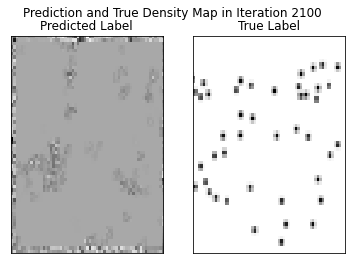

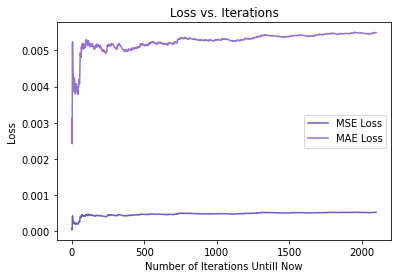



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00039
After 100 data, MAE loss is:0.00515


Train Results:
Iteration:2200 	 Loss1:0.00052
Iteration:2200 	 Loss2:0.00547


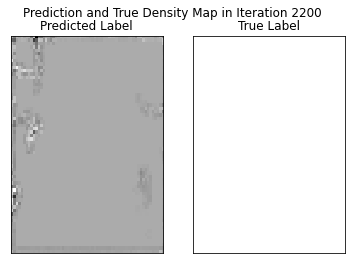

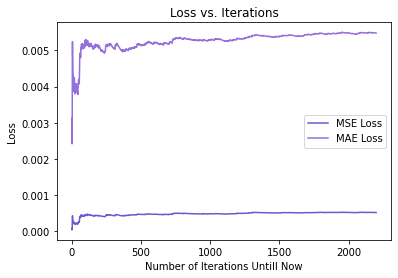



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00527


Train Results:
Iteration:2300 	 Loss1:0.00053
Iteration:2300 	 Loss2:0.00549


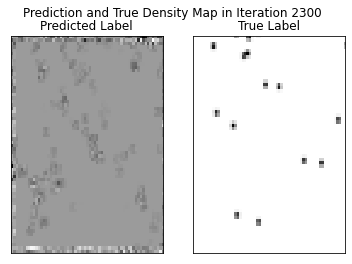

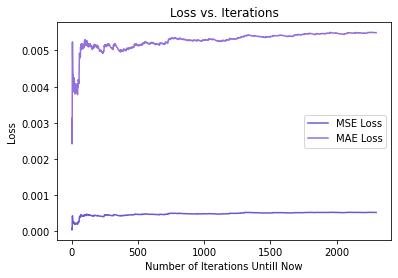



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00509


Train Results:
Iteration:2400 	 Loss1:0.00052
Iteration:2400 	 Loss2:0.00547


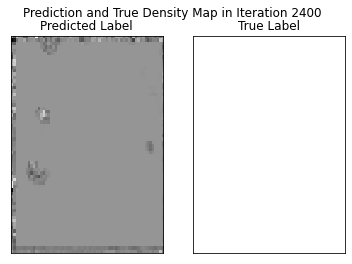

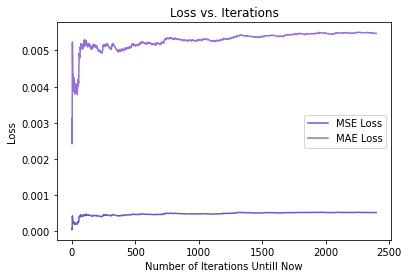



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00059
After 100 data, MAE loss is:0.00582


Train Results:
Iteration:2500 	 Loss1:0.00052
Iteration:2500 	 Loss2:0.00547


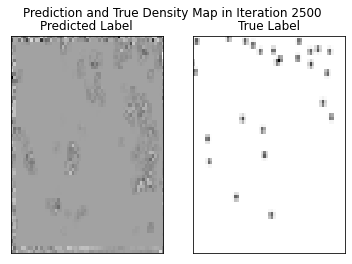

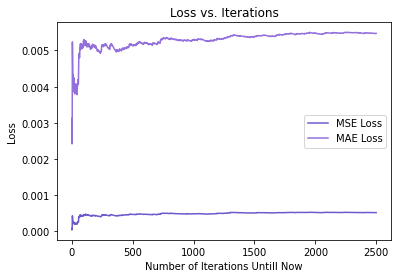



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00063
After 100 data, MAE loss is:0.00604


Train Results:
Iteration:2600 	 Loss1:0.00052
Iteration:2600 	 Loss2:0.00546


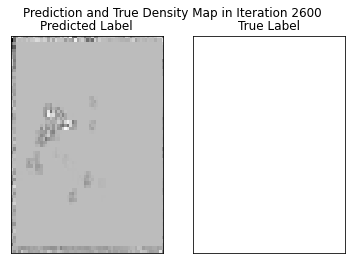

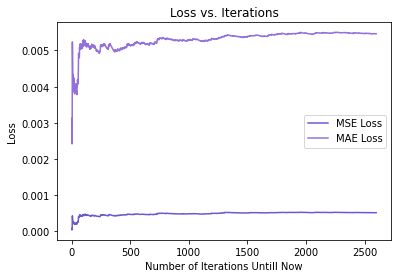



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00055
After 100 data, MAE loss is:0.00557


Train Results:
Iteration:2700 	 Loss1:0.00052
Iteration:2700 	 Loss2:0.00546


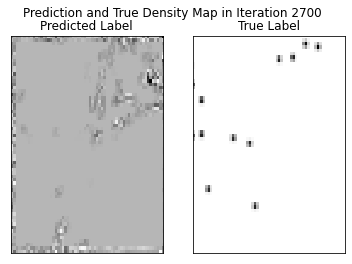

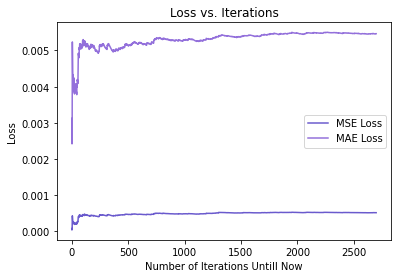



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00038
After 100 data, MAE loss is:0.00456


Train Results:
Iteration:2800 	 Loss1:0.00051
Iteration:2800 	 Loss2:0.00544


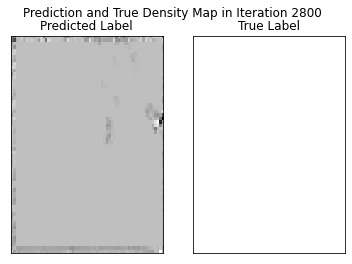

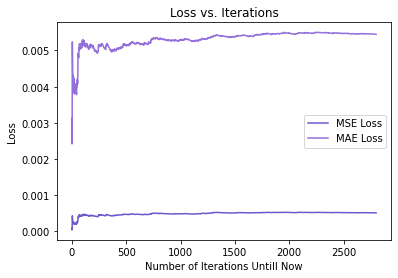



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00485


Train Results:
Iteration:2900 	 Loss1:0.00051
Iteration:2900 	 Loss2:0.00544


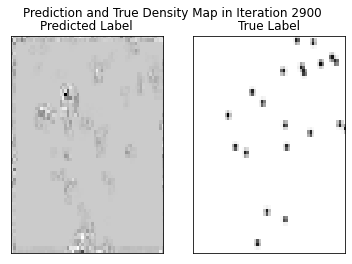

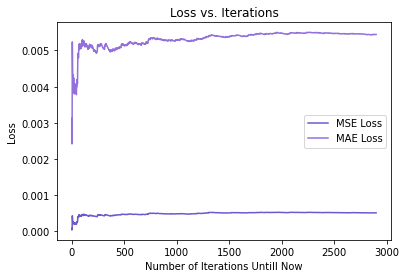



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00507


Train Results:
Iteration:3000 	 Loss1:0.00051
Iteration:3000 	 Loss2:0.00540


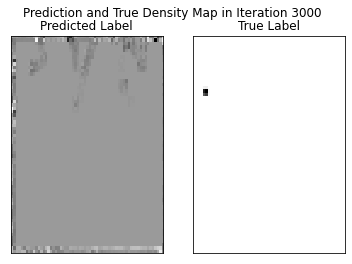

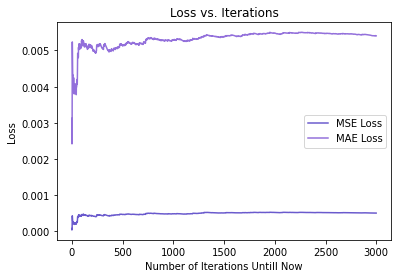



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00526


Train Results:
Iteration:3100 	 Loss1:0.00050
Iteration:3100 	 Loss2:0.00536


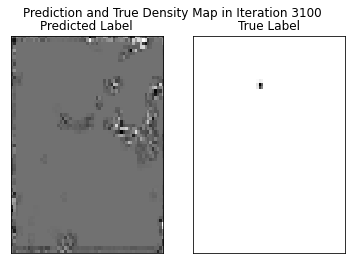

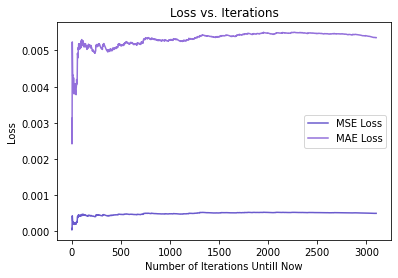



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00054
After 100 data, MAE loss is:0.00510


Train Results:
Iteration:3200 	 Loss1:0.00051
Iteration:3200 	 Loss2:0.00537


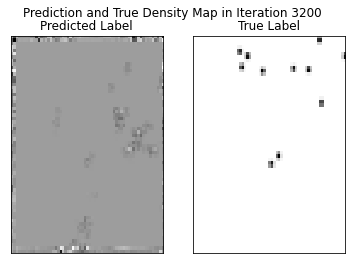

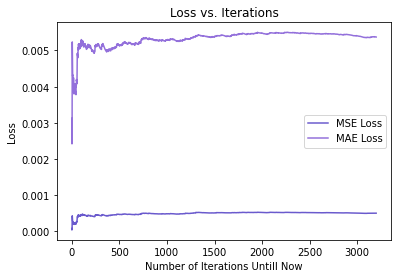



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00503


Train Results:
Iteration:3300 	 Loss1:0.00051
Iteration:3300 	 Loss2:0.00537


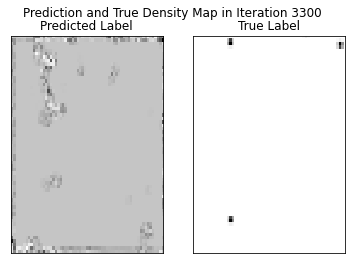

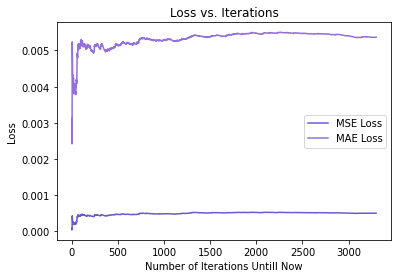



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00058
After 100 data, MAE loss is:0.00585


Train Results:
Iteration:3400 	 Loss1:0.00051
Iteration:3400 	 Loss2:0.00537


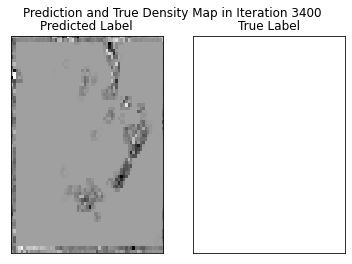

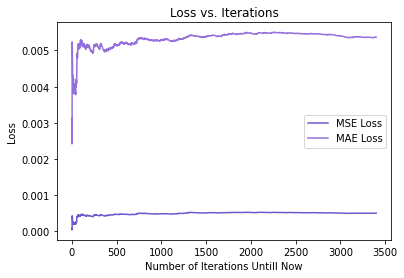



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00037
After 100 data, MAE loss is:0.00480


Train Results:
Iteration:3500 	 Loss1:0.00050
Iteration:3500 	 Loss2:0.00537


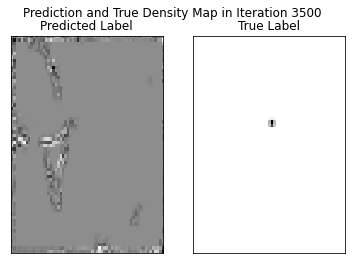

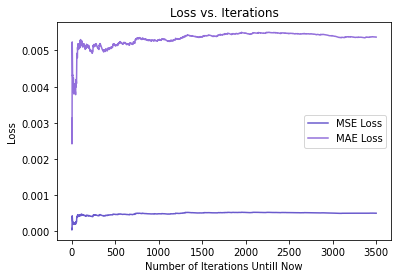



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00040
After 100 data, MAE loss is:0.00507


Train Results:
Iteration:3600 	 Loss1:0.00051
Iteration:3600 	 Loss2:0.00539


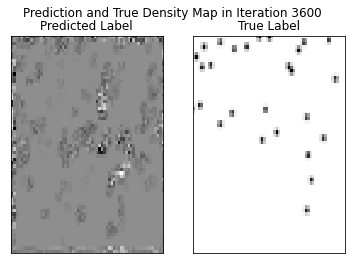

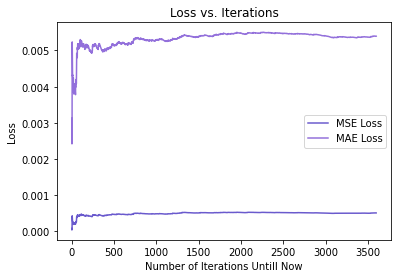



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00028
After 100 data, MAE loss is:0.00442


Train Results:
Iteration:3700 	 Loss1:0.00051
Iteration:3700 	 Loss2:0.00539


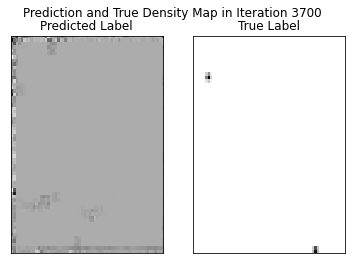

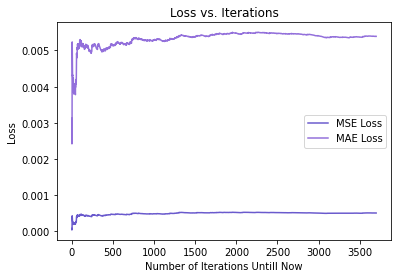



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00046
After 100 data, MAE loss is:0.00533


Train Results:
Iteration:3800 	 Loss1:0.00052
Iteration:3800 	 Loss2:0.00541


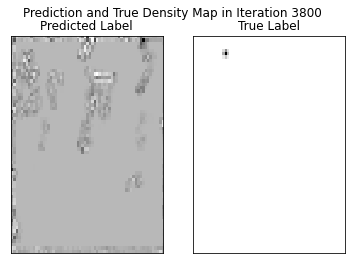

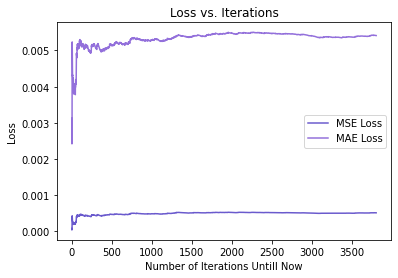



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00050
After 100 data, MAE loss is:0.00509


Train Results:
Iteration:3900 	 Loss1:0.00052
Iteration:3900 	 Loss2:0.00541


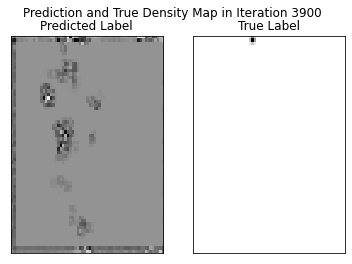

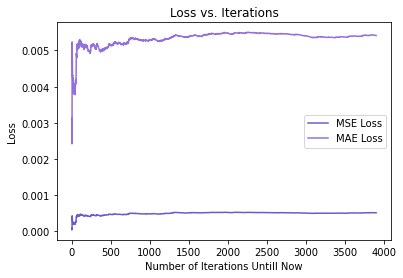



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00061
After 100 data, MAE loss is:0.00595


Train Results:
Iteration:4000 	 Loss1:0.00052
Iteration:4000 	 Loss2:0.00543


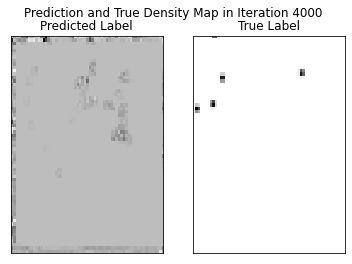

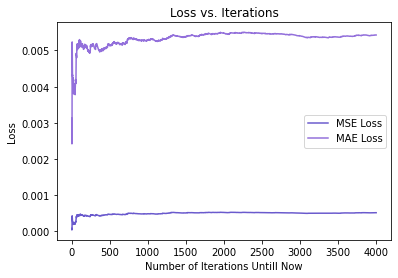



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00053
After 100 data, MAE loss is:0.00538


Train Results:
Iteration:4100 	 Loss1:0.00052
Iteration:4100 	 Loss2:0.00542


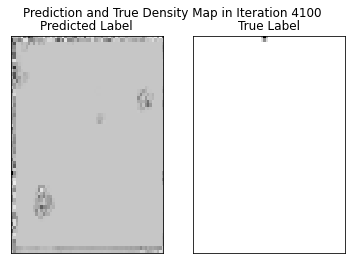

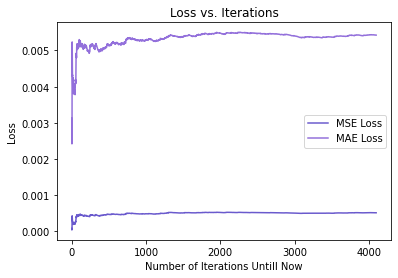



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00043
After 100 data, MAE loss is:0.00519


Train Results:
Iteration:4200 	 Loss1:0.00051
Iteration:4200 	 Loss2:0.00541


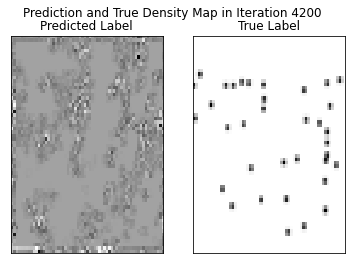

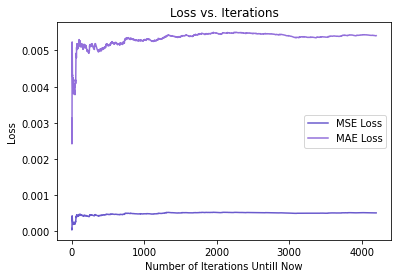



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00042
After 100 data, MAE loss is:0.00488


Train Results:
Iteration:4300 	 Loss1:0.00052
Iteration:4300 	 Loss2:0.00542


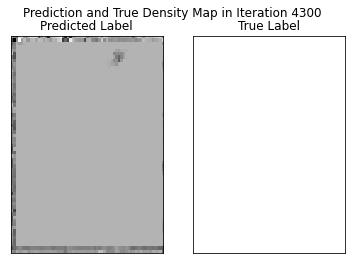

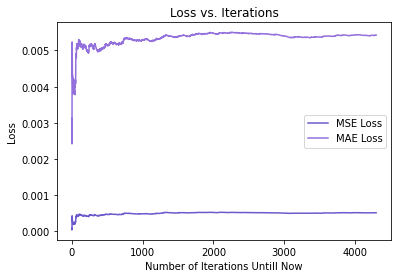



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00042
After 100 data, MAE loss is:0.00505


Train Results:
Iteration:4400 	 Loss1:0.00052
Iteration:4400 	 Loss2:0.00543


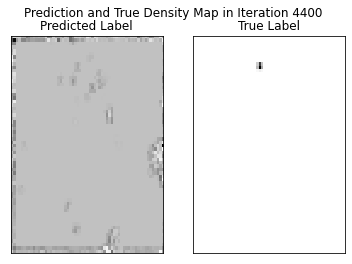

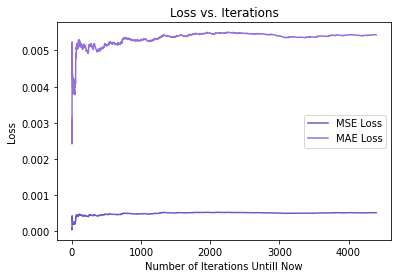



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00052
After 100 data, MAE loss is:0.00586


Train Results:
Iteration:4500 	 Loss1:0.00052
Iteration:4500 	 Loss2:0.00543


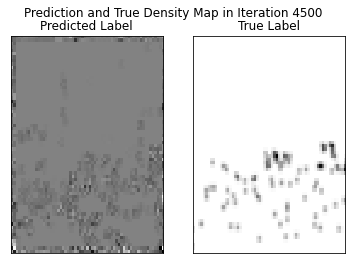

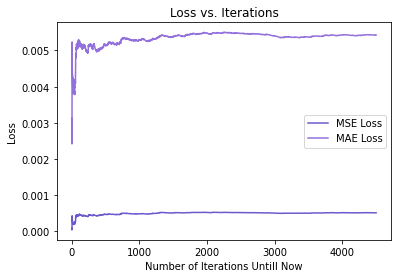



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00058
After 100 data, MAE loss is:0.00534


Train Results:
Iteration:4600 	 Loss1:0.00052
Iteration:4600 	 Loss2:0.00542


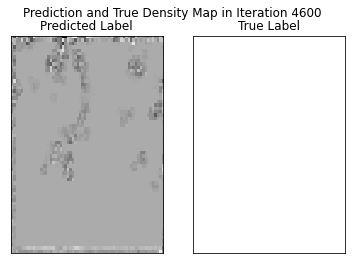

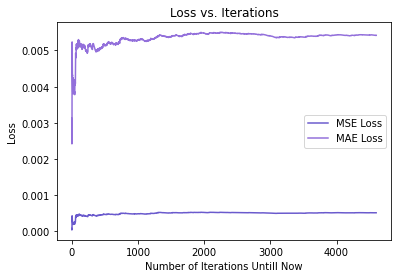



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00058
After 100 data, MAE loss is:0.00579


Train Results:
Iteration:4700 	 Loss1:0.00052
Iteration:4700 	 Loss2:0.00541


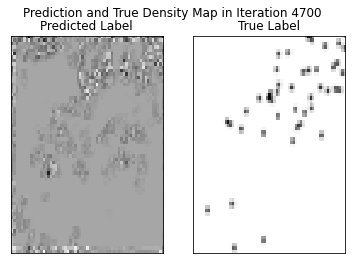

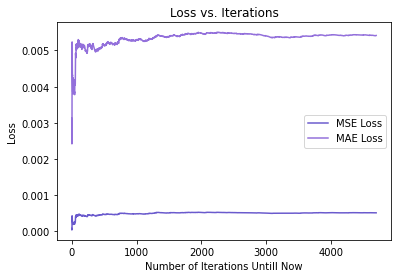



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00035
After 100 data, MAE loss is:0.00453


Train Results:
Iteration:4800 	 Loss1:0.00052
Iteration:4800 	 Loss2:0.00541


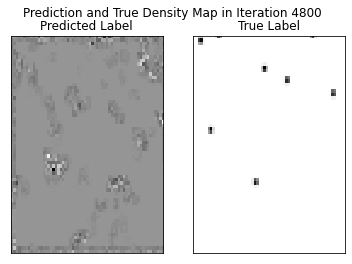

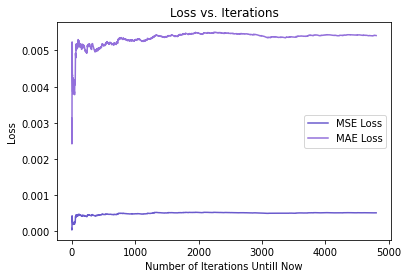



Testing the network......
Test Results:
After 100 data, MSE loss is:0.00048
After 100 data, MAE loss is:0.00511


At the end of epoch 5 the average train loss of MSE is: 0.00052
At the end of epoch 5 the average train loss of MAE is: 0.00541


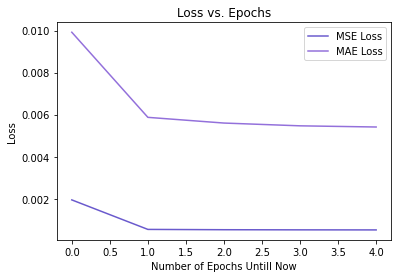

In [ ]:
train(myCCNN, criterionMSE, criterionMAE, optimizer, batchTrainDataset, batchTrainDataset, 5)